# Car Racing DQN agent 
Training a DQN agent for the OpenAI gym Car-Racing-v0 environment.


### Notes
- The first 50 frames afer resetting the environment are of the camera zooming into the track, and look very different from "normal" gameplay.
    - I exclude these frames from the training of each episode.
- Preprocessing
    - I have applied similar preprocessing steps as used in the DeepMind paper.
    - Images are converted to grayscale and cropped to $56 x 56$ to reduce dimensionality and speed up training.
    - Consecutive frames are then stacked to form a $56 x 56 x 3$ image, where the channels represent the game screen at different points in time instead of RGB channels.
- How often the target network weights are updated seems to make a BIG difference on training performance. Less seems to be more.

### To do
- Research literature.
- Increase replay buffer size.
- Trial simplified CNN architectures.
- Add more frames to the frame stack.
- Adjust max consecutive negative rewards threholds.
- Trial different epsilon decay schedules.

### Environment setup

        conda create -c conda-forge -n gymenv swig pip  
        conda activate gymenv  
        pip install gym==0.17.3
        pip install Box2D gym
        pip install gym[all]

        pip install tensorflow
        pip install matplotlib

        pip install gym pyvirtualdisplay   
        sudo apt-get install -y xvfb python-opengl ffmpeg  

        # The following steps are so that I can access the new env in Azure ML notebooks
        conda install ipykernel
        python -m ipykernel install --user --name gymenv --display-name "Python (gymenv)"




### Useful links

#### Papers
https://arxiv.org/pdf/1312.5602.pdf 

#### Environment setup  
https://stackoverflow.com/questions/60268769/gyms-box-2d-openai-doesnt-install-successfully-pip-error  
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-access-terminal#add-new-kernels  

#### Code adapted from:   
https://keras.io/examples/rl/deep_q_network_breakout/  
https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c  
https://pythonprogramming.net/training-deep-q-learning-dqn-reinforcement-learning-python-tutorial/?completed=/deep-q-learning-dqn-reinforcement-learning-python-tutorial/   
https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN  
https://github.com/pekaalto/DQN 

#### Import libraries

In [1]:
import gym
import numpy as np
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from collections import deque
import time
import random
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, \
                        GlobalMaxPool2D, BatchNormalization, Dropout, Activation
from keras.backend import clear_session

display = Display(visible=0, size=(1400, 900))
display.start()

from dqn_agent import *
from dqn_agent_trainer import *

## Train the DQN agent

In [2]:
actions = np.array([[0.0, 1.0, 0.0],  
                    [1.0, 0.0, 0.0],
                    [-1.0, 0.0, 0.0],
                    [0.0, 0.0, 0.8],
                    [0.0, 0.0, 0.0]]   
                )
action_probs = np.array([0.5] + [(1 - 0.5)/4.0] * 4)

# Create a DQN agent
dqn_agent = DQNAgent(actions,
                    action_probs,
                    lr=0.00025, 
                    batch_size=32, 
                    gamma=0.95)

# Create the agent trainer
agent_trainer = DQNAgentTrainer(img_len=48, 
                                frame_stack_num=4, 
                                number_of_episodes=1000, 
                                epsilon=0.1, 
                                epsilon_min=0.05, 
                                epsilon_step_episodes=50.0,
                                final_epsilon_episode=10000,
                                max_replay_memory_size=100000, 
                                min_replay_memory_size=1000, 
                                random_action_frames=2000,
                                max_consecutive_negative_rewards=100, 
                                update_target_model_frames=5000, 
                                max_frames_per_episode=10000,
                                skip_frames=4, 
                                save_training_frequency=10000, 
                                save_models=False, 
                                save_run_results=True,
                                verbose_cnn=50, 
                                verbose=True)

# Define environment and train agent
env = gym.make("CarRacing-v0")
agent_trainer.train_agent(env, dqn_agent)


/anaconda/envs/gymenv/lib/python3.10/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2022-04-09 22:30:49.465326: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-09 22:30:49.465415: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x-wing): /proc/driver/nvidia/version does not exist
2022-04-09 22:30:49.466082: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


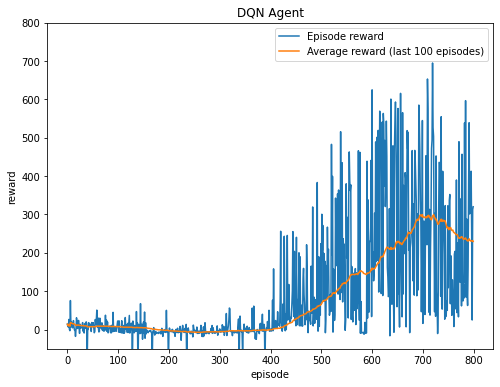

In [6]:
# Plot the rewards
episode_rewards = agent_trainer.episode_rewards

def plot_rewards(episode_rewards):
    """Plot episode rewards."""
    plt.figure(figsize=(8, 6))
    plt.title('DQN Agent')
    plt.plot(episode_rewards, label='Episode reward')
    plt.plot([np.mean(episode_rewards[::-1][i:i+100]) for i in range(len(episode_rewards))][::-1], label='Average reward (last 100 episodes)')
    plt.ylim((-50, 800))
    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.legend()
    plt.show()

In [5]:
with open("./runs/dqn_results_20220409-160900.pickle", 'rb') as fp:
    results = pickle.load(fp)

model = results['model']


2022-04-09 21:19:32.868800: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-09 21:19:32.868873: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x-wing): /proc/driver/nvidia/version does not exist
2022-04-09 21:19:32.869548: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [50]:
env.close()

## Analysis

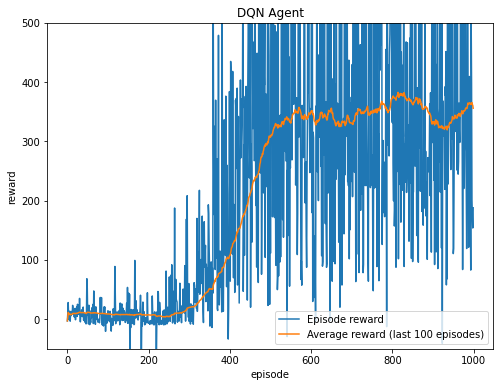

In [6]:
# Plot the rewards
plt.figure(figsize=(8, 6))
plt.title('DQN Agent')
plt.plot(episode_rewards, label='Episode reward')
plt.plot([np.mean(episode_rewards[::-1][i:i+100]) for i in range(len(episode_rewards))][::-1], label='Average reward (last 100 episodes)')
plt.ylim((-50, 500))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()
plt.show()

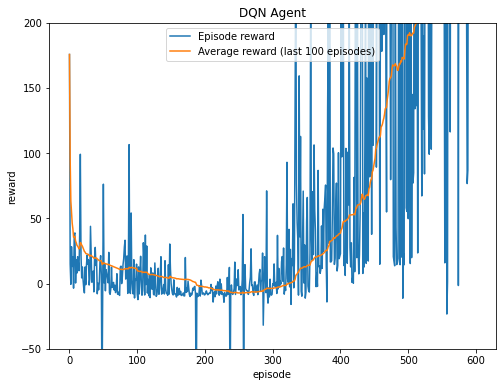

In [15]:
# Plot the rewards
plt.figure(figsize=(8, 6))
plt.title('DQN Agent')
plt.plot(episode_rewards, label='Episode reward')
plt.plot([np.mean(episode_rewards[::-1][i:i+100]) for i in range(len(episode_rewards))][::-1], label='Average reward (last 100 episodes)')
plt.ylim((-50, 200))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()
plt.show()

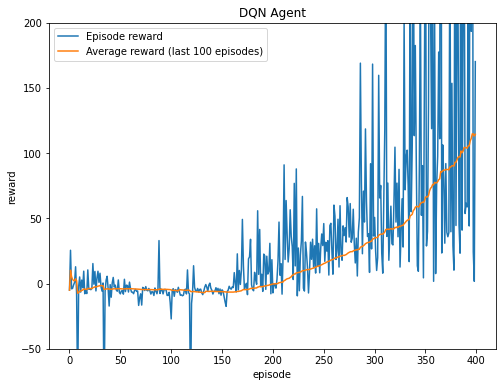

In [5]:
# Plot the rewards
plt.figure(figsize=(8, 6))
plt.title('DQN Agent')
plt.plot(episode_rewards, label='Episode reward')
plt.plot([np.mean(episode_rewards[::-1][i:i+100]) for i in range(len(episode_rewards))][::-1], label='Average reward (last 100 episodes)')
plt.ylim((-50, 200))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()
plt.show()

### Render the DQN agent

In [2]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [13]:
def get_stacked_state_live(gs_buffer):
    """Returns a stacked image from the grayscale buffer."""

    # Create image from grayscale buffer
    img = np.zeros((56, 56, 4))
    img[:, :, 0] = gs_buffer[0]
    img[:, :, 1] = gs_buffer[4]
    img[:, :, 2] = gs_buffer[8]
    img[:, :, 3] = gs_buffer[12]
    img = np.reshape(img, (1, 56, 56, 4))

    # Remove first image from buffer
    gs_buffer.popleft()
    return img

In [14]:
actions = results['actions']
model = results['model']

render = True

episode_rewards = 0

env = wrap_env(gym.make("CarRacing-v0"))
s_0 = env.reset()
s_0 = image_processing(s_0, 56)
grayscale_state_buffer = deque([s_0]*13)
s_0_stacked = get_stacked_state_live(grayscale_state_buffer)

i = 0
while True:
    if render:
        env.render()
    if i < 5:
        a_0 = 0
    else:
        a_0 = np.argmax(model.predict(s_0_stacked))
    s_1, reward, done, _ = env.step(actions[a_0])
    episode_rewards += reward

    if done:
        break

    # Append latest state and get new stacked representation
    s_1 = image_processing(s_1, 56)
    grayscale_state_buffer.append(s_1)
    s_0_stacked = get_stacked_state_live(grayscale_state_buffer)

    i += 1

env.close()
if render:
    show_video()

print(episode_rewards)


/anaconda/envs/gymenv/lib/python3.10/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Track generation: 1022..1282 -> 260-tiles track


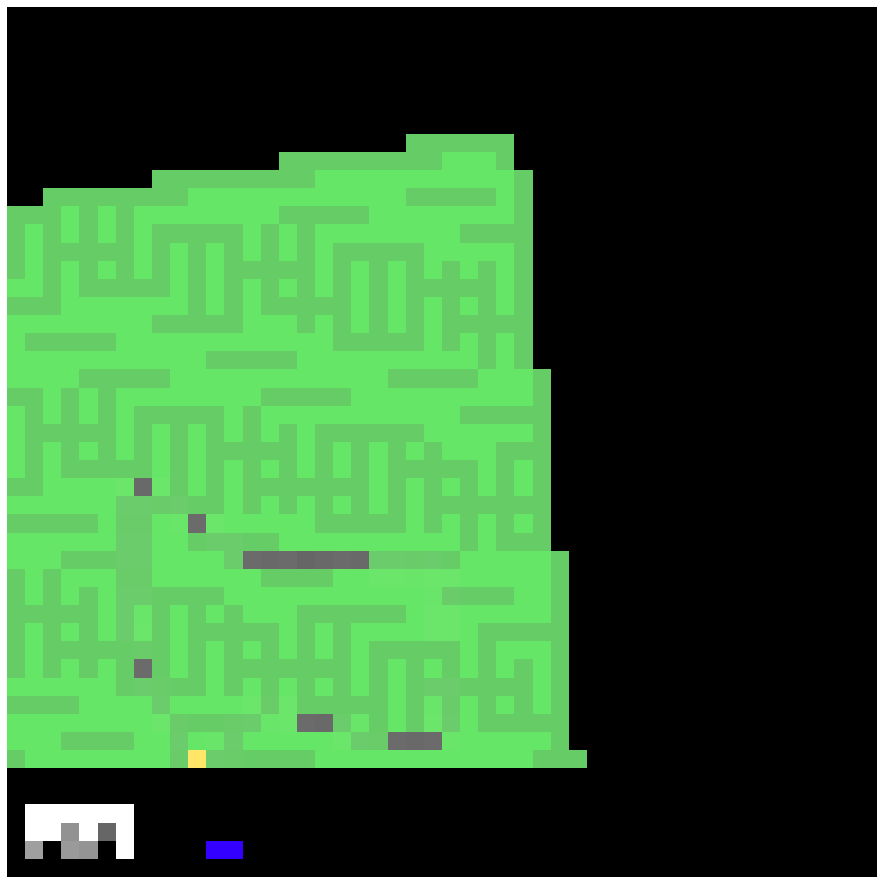

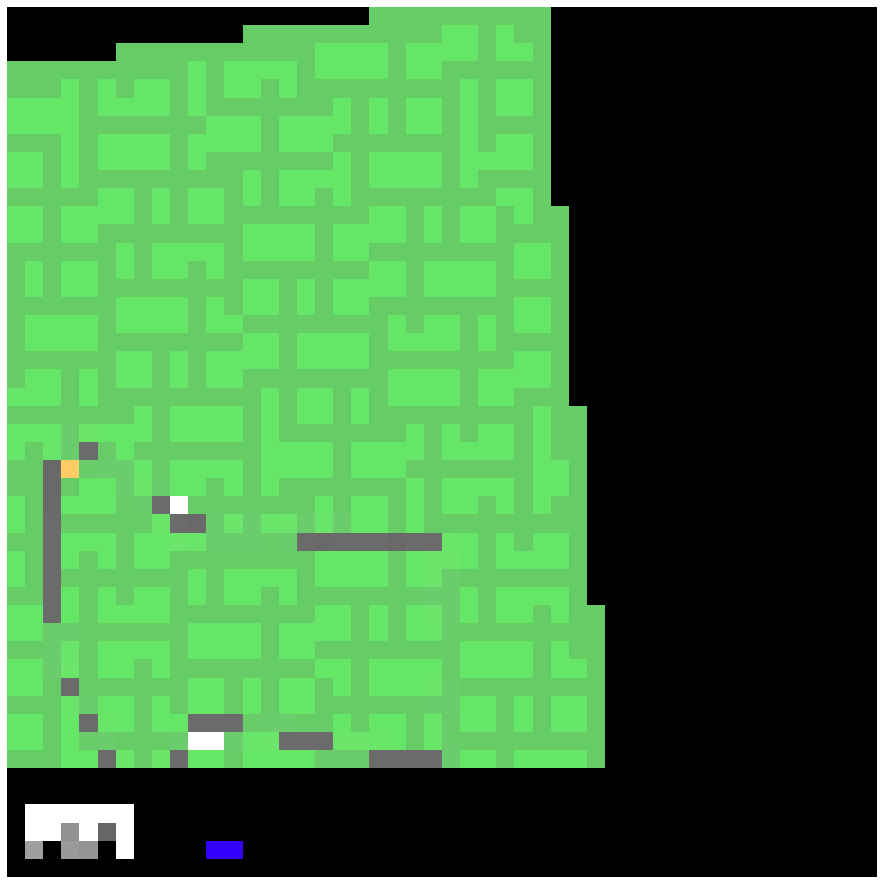

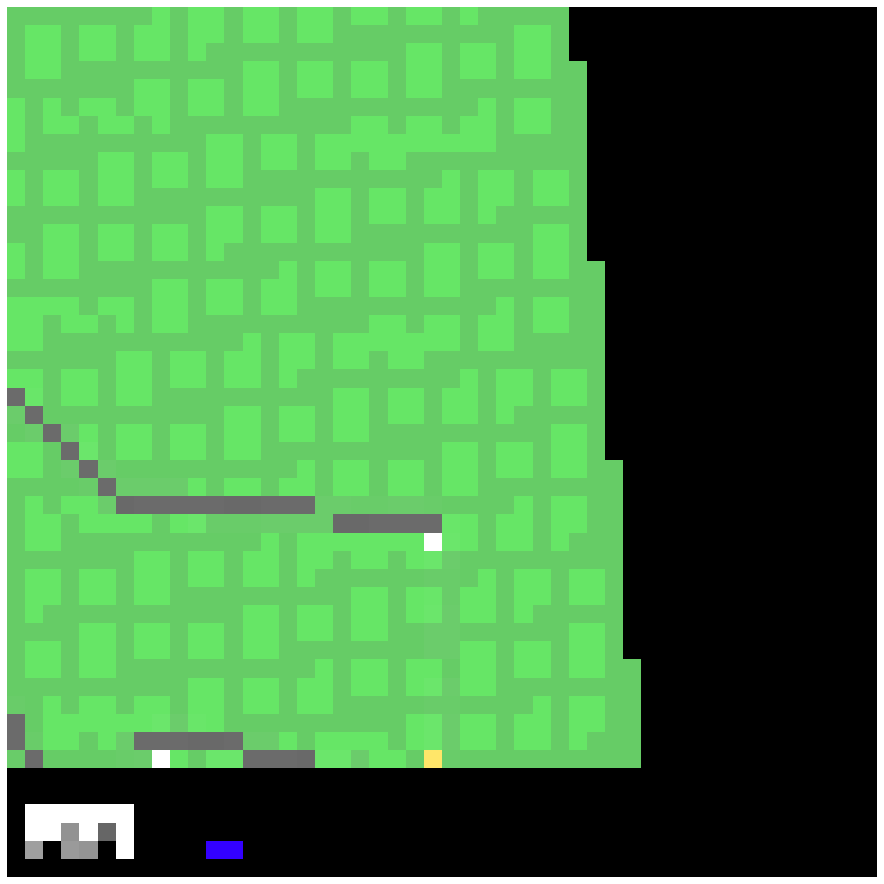

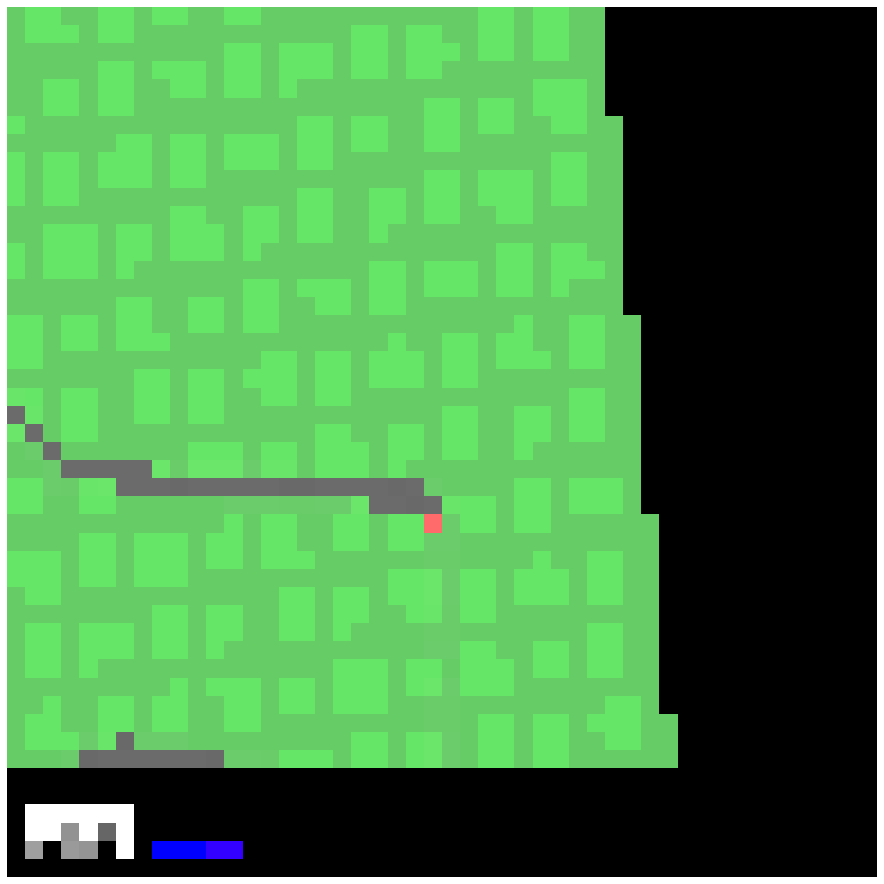

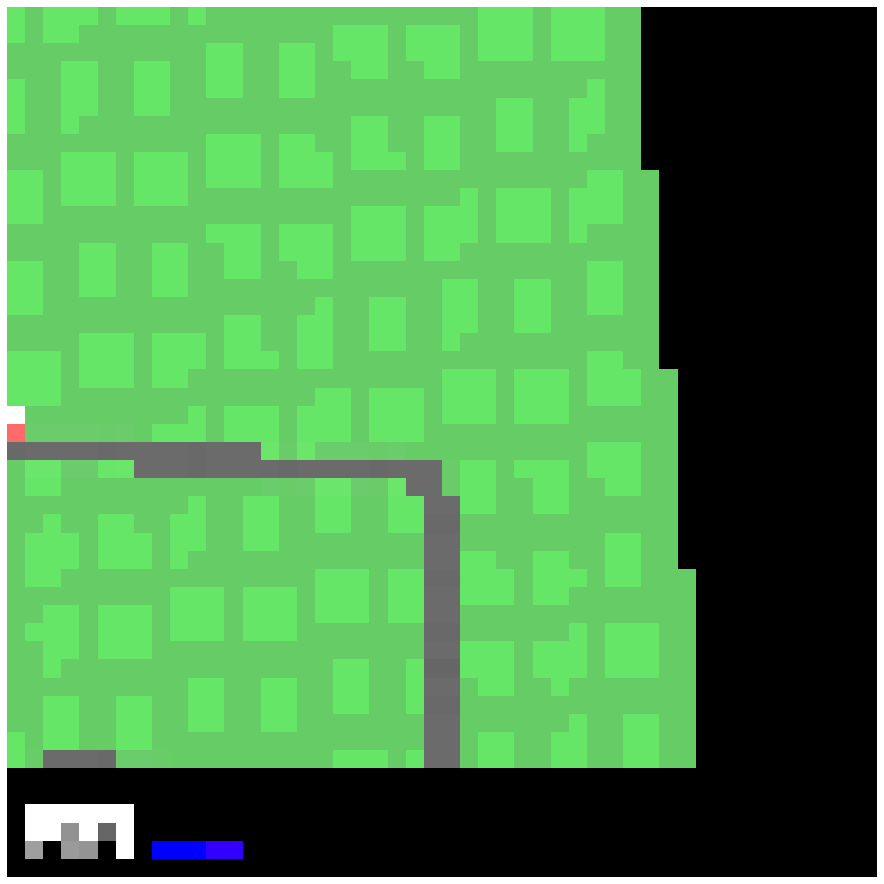

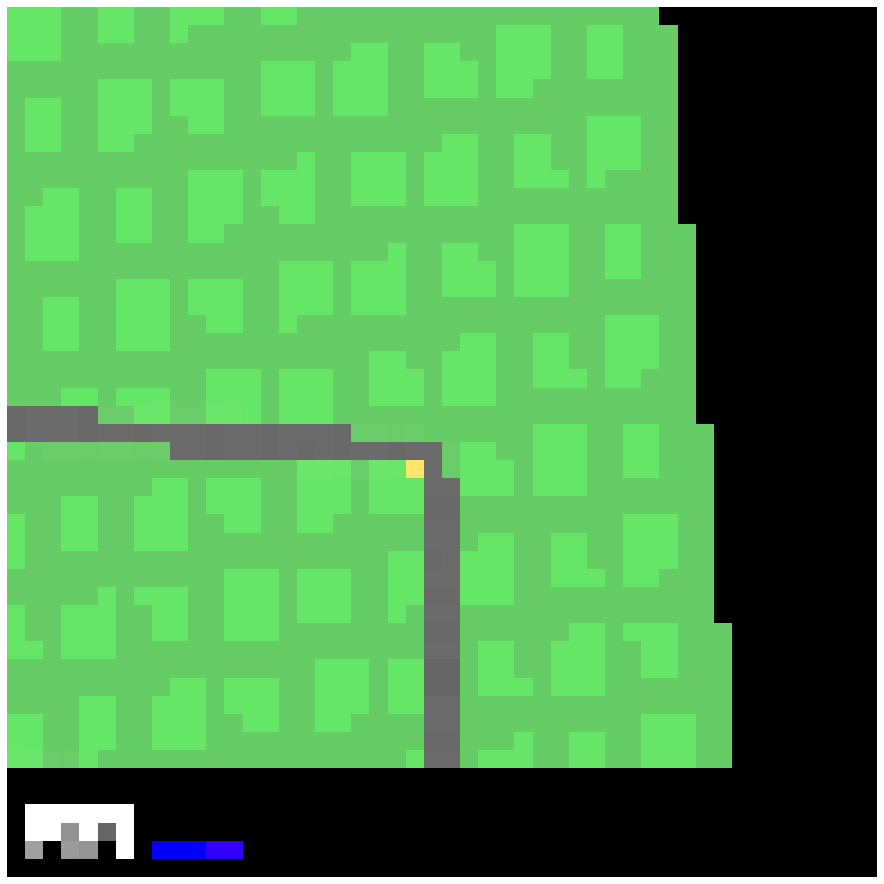

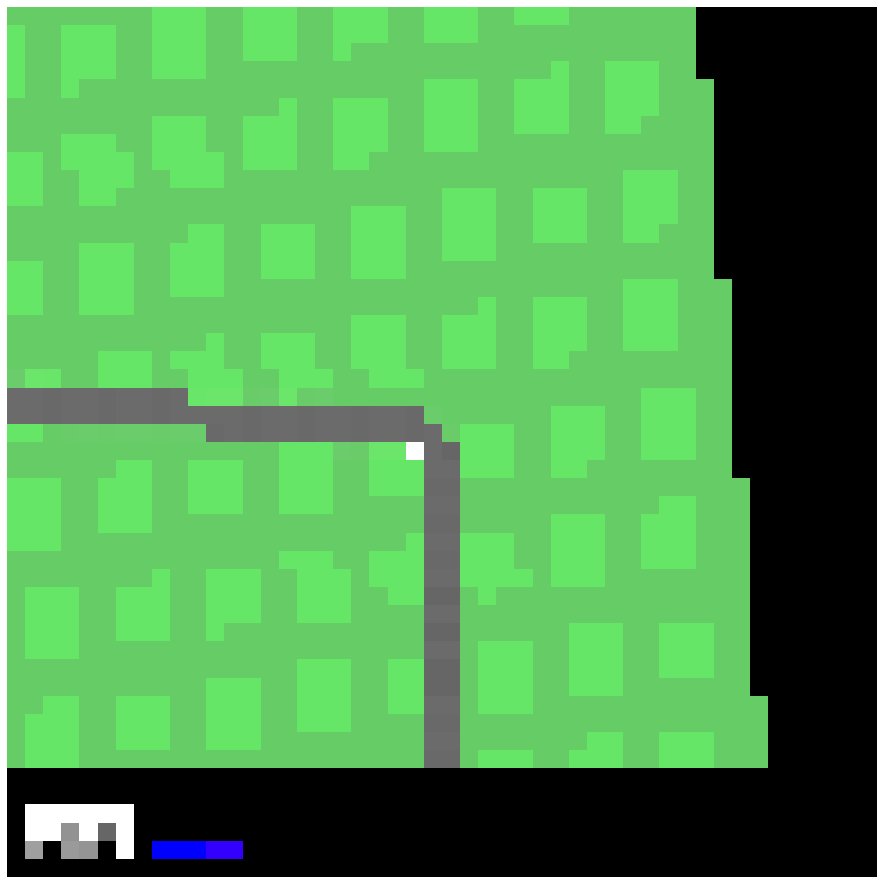

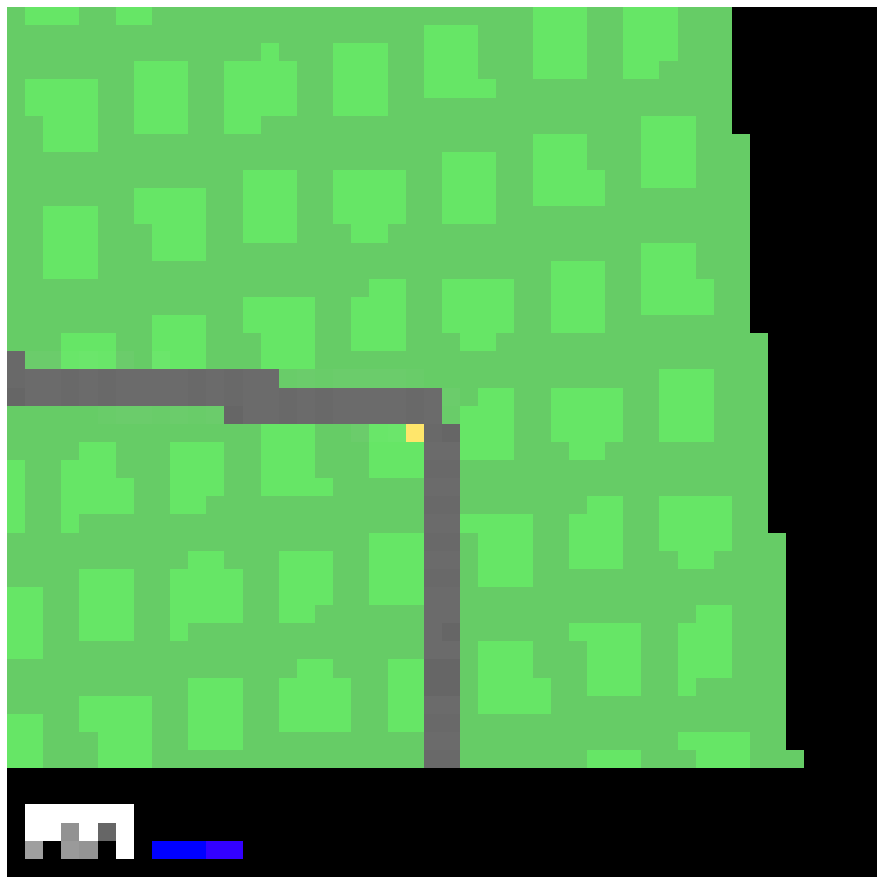

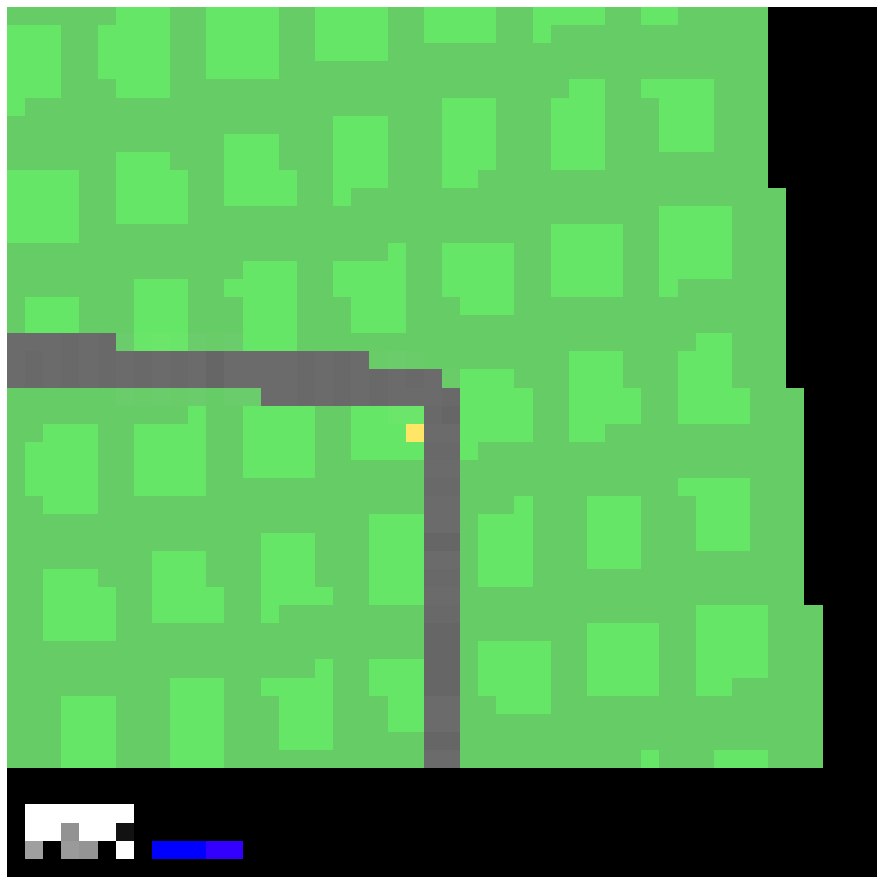

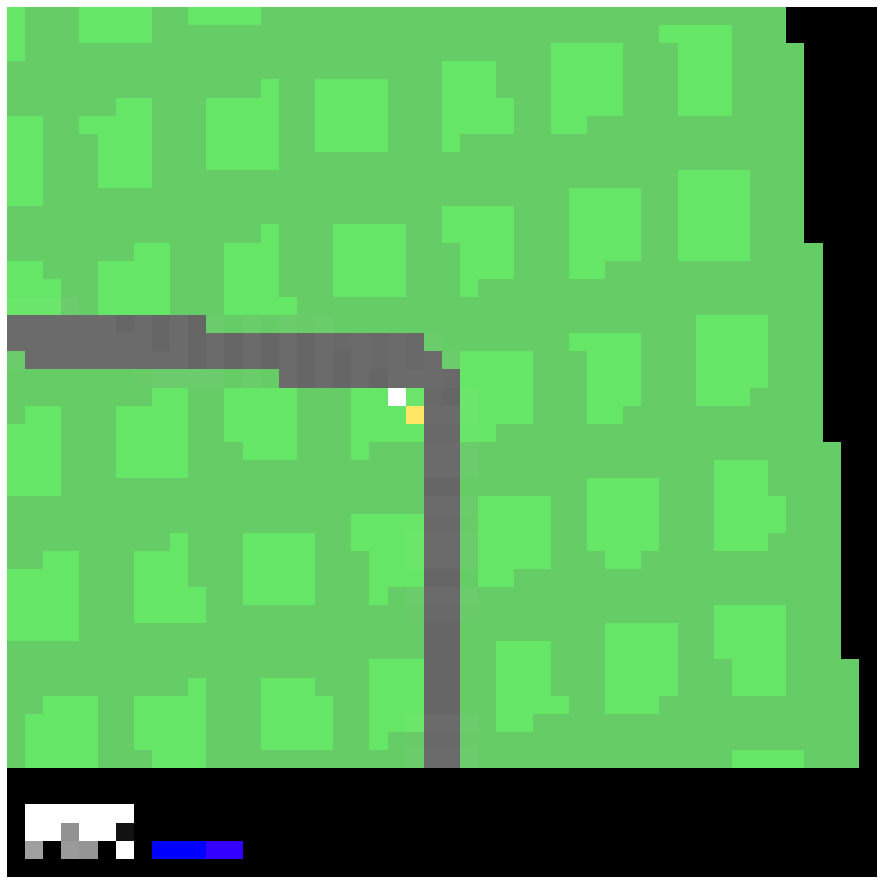

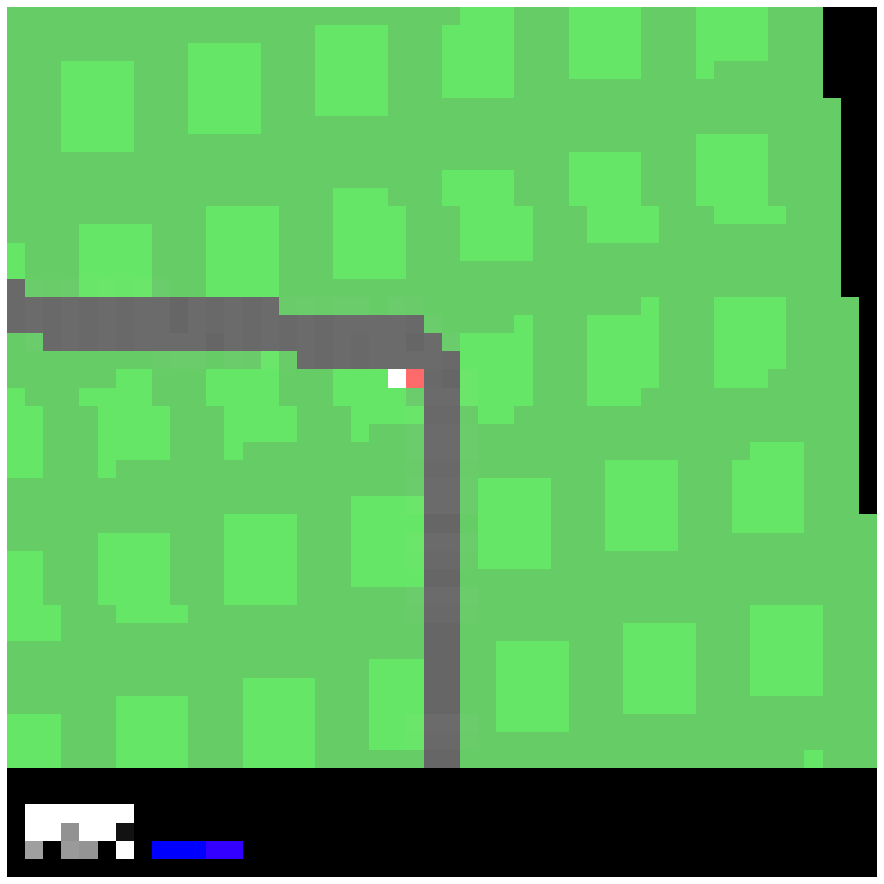

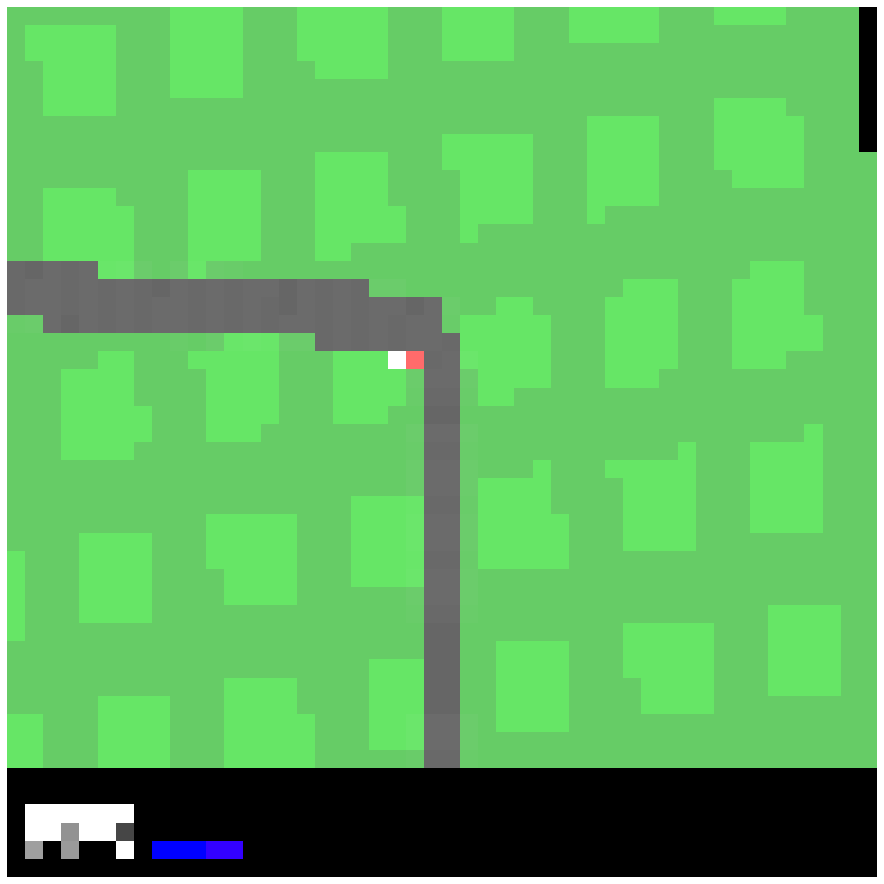

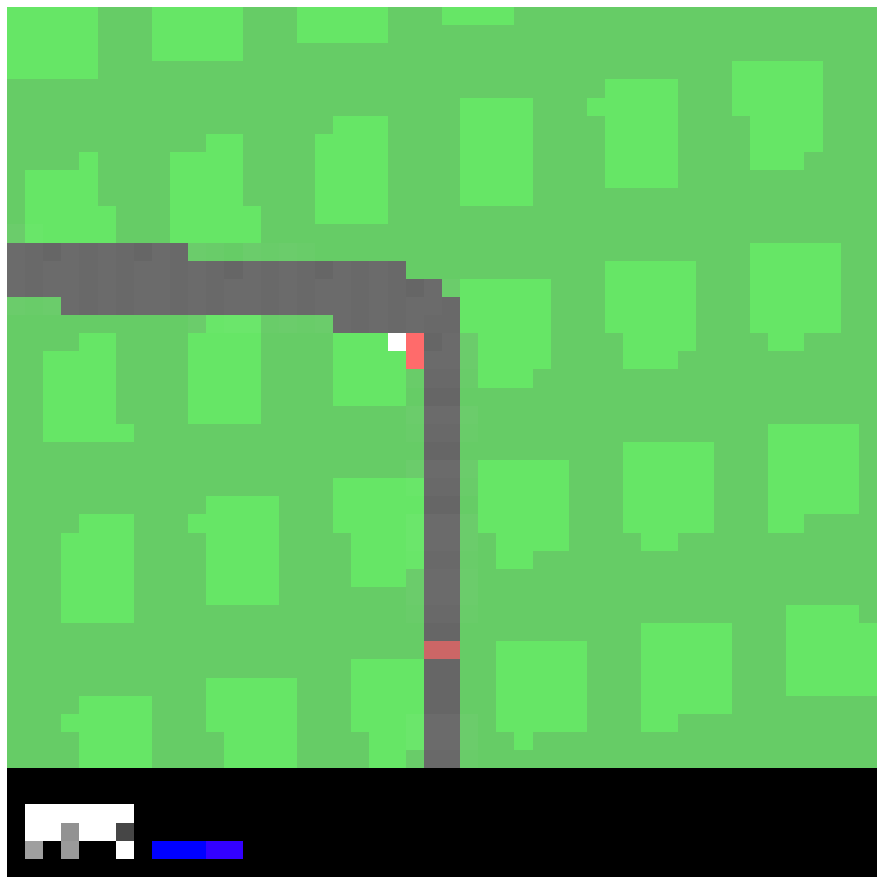

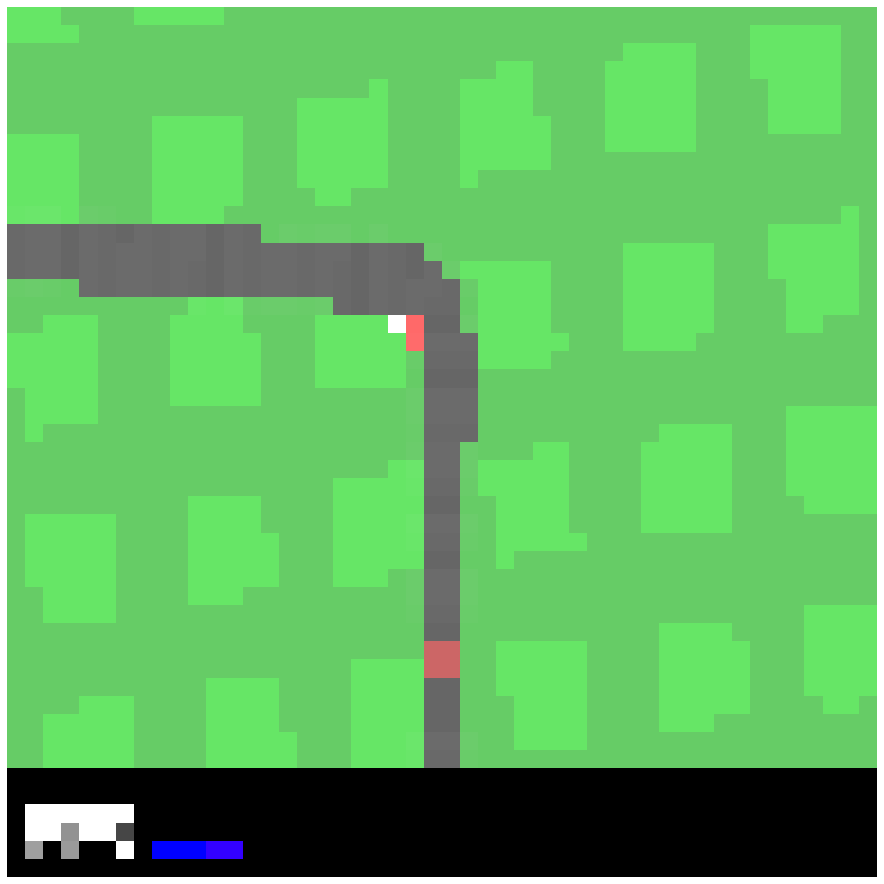

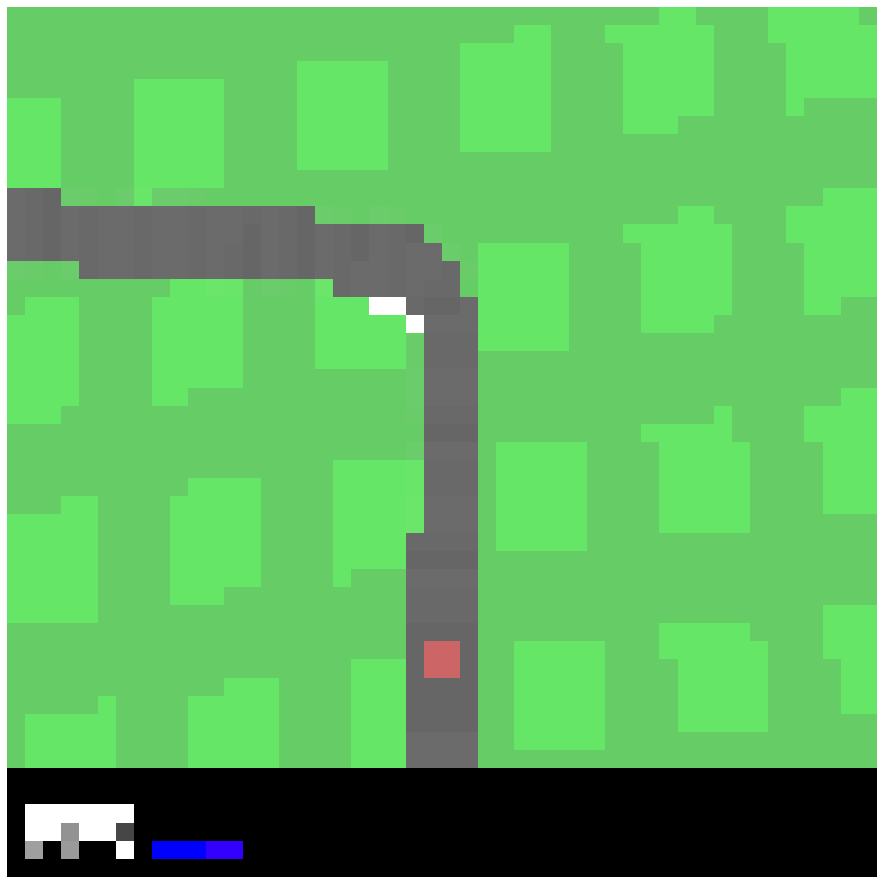

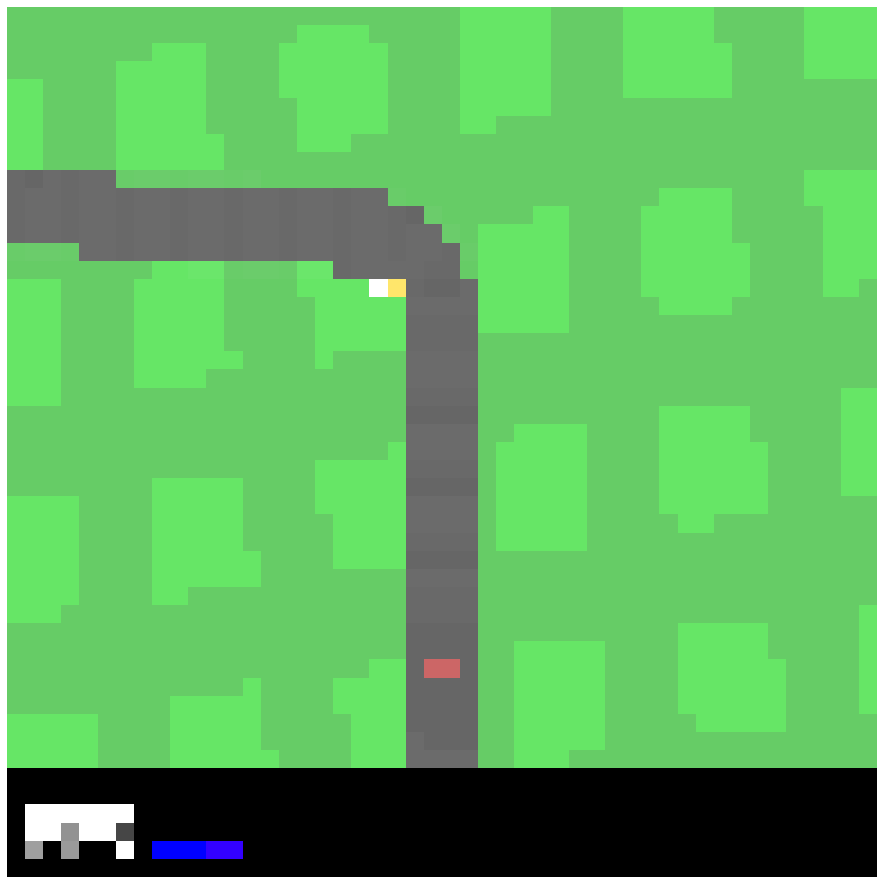

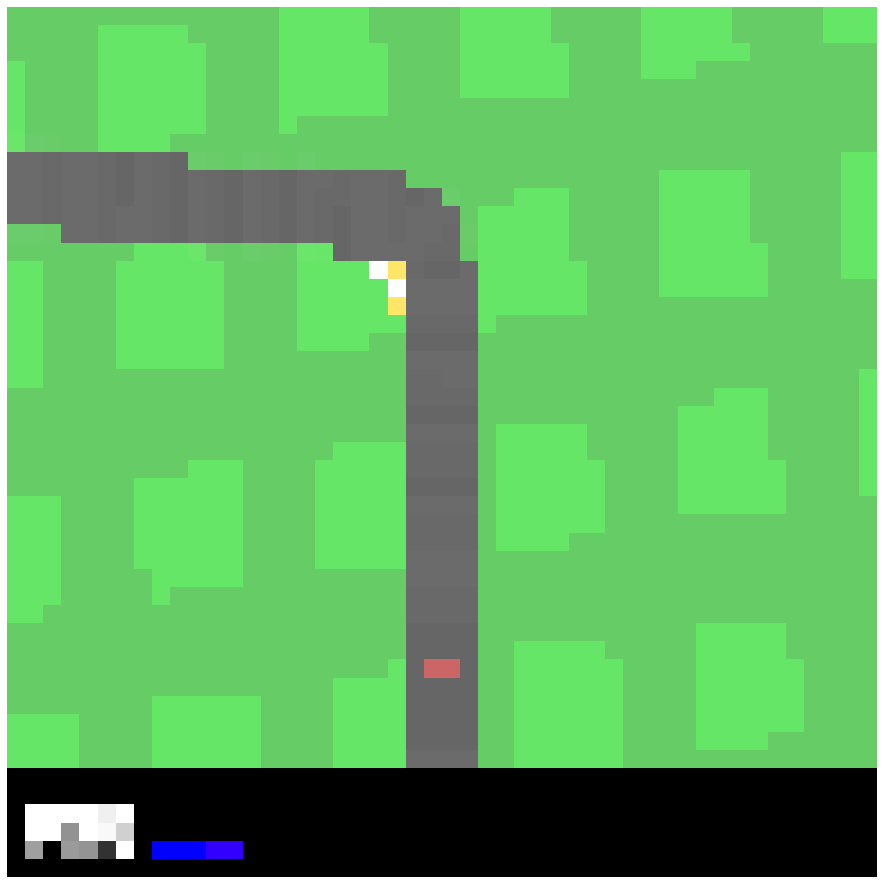

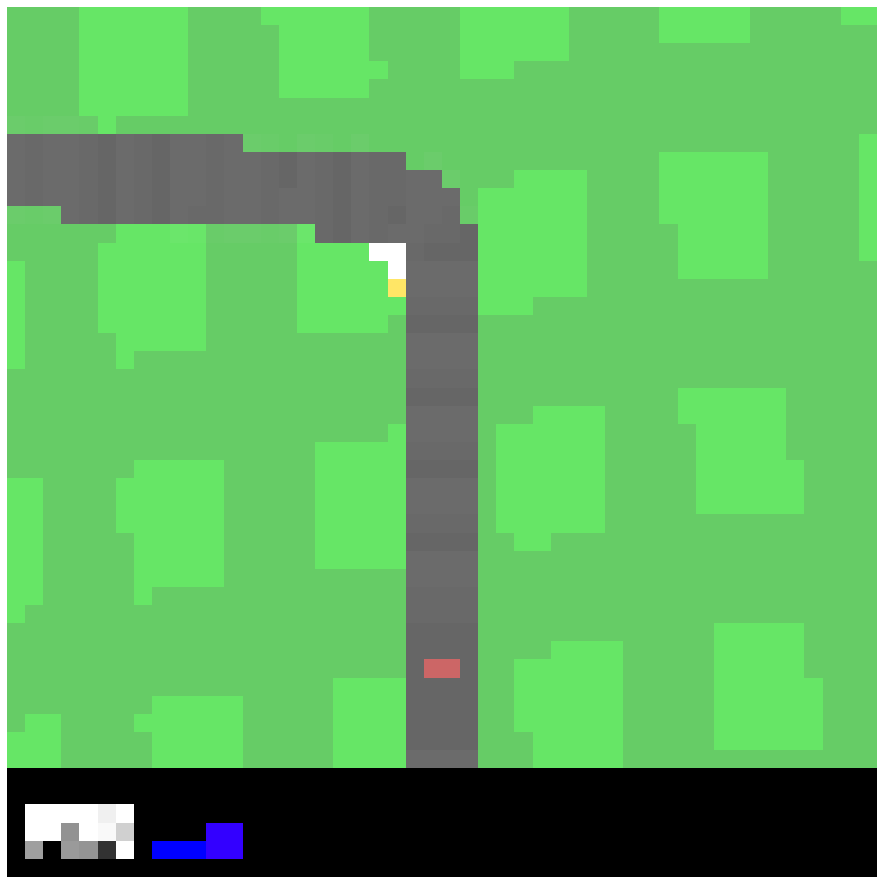

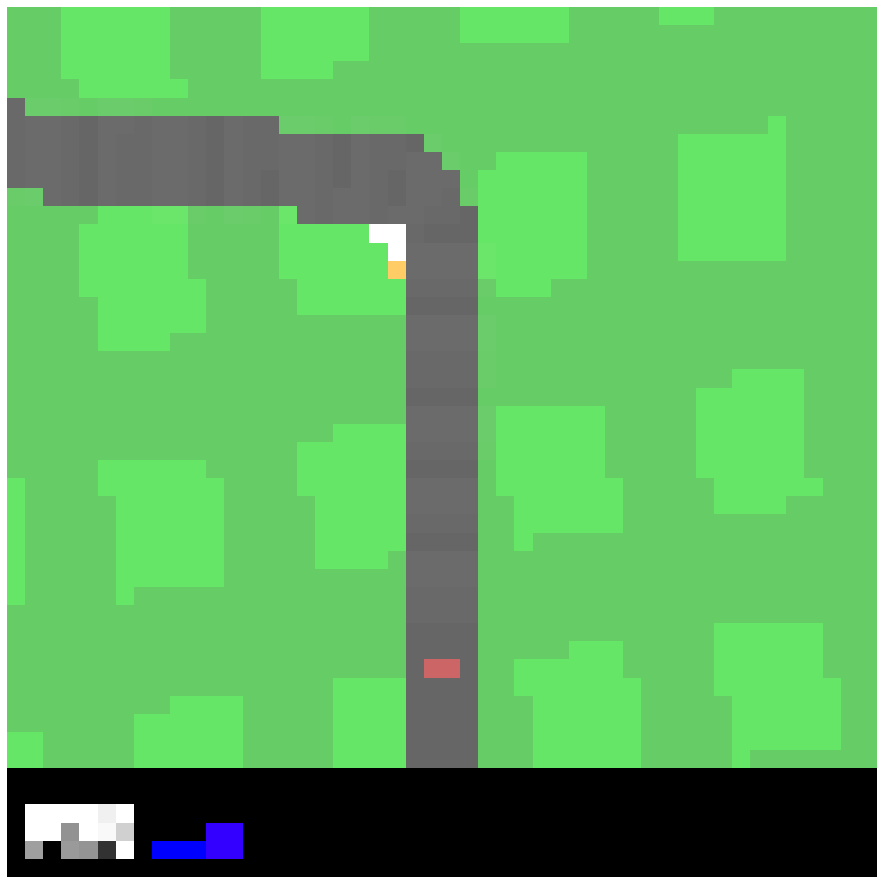

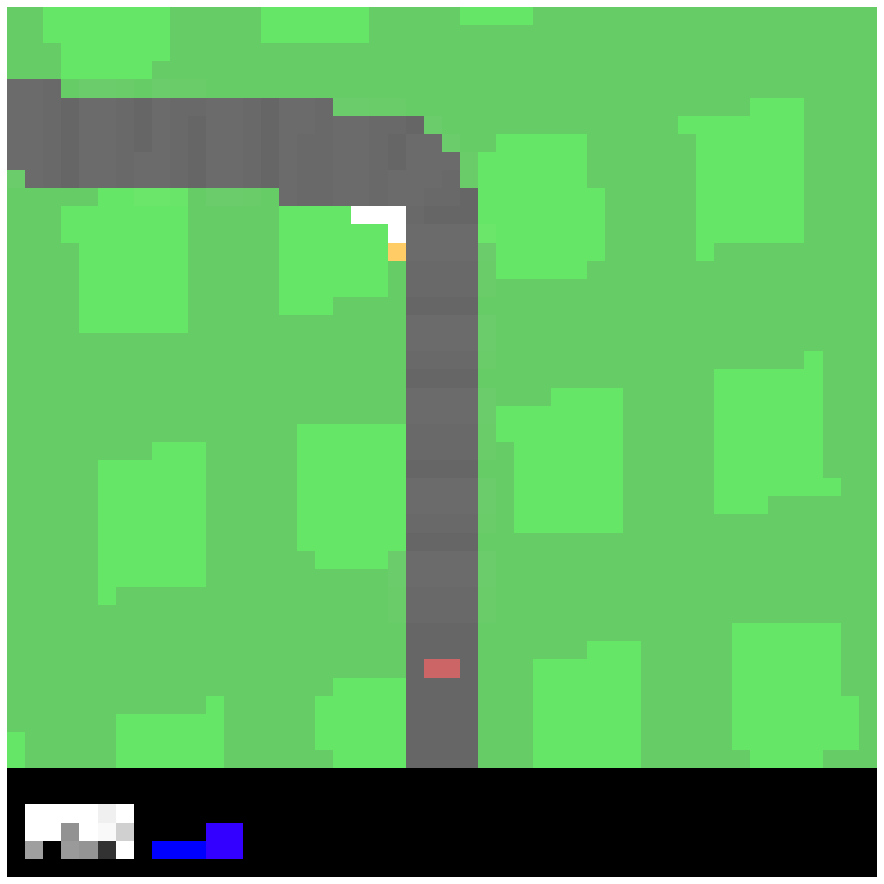

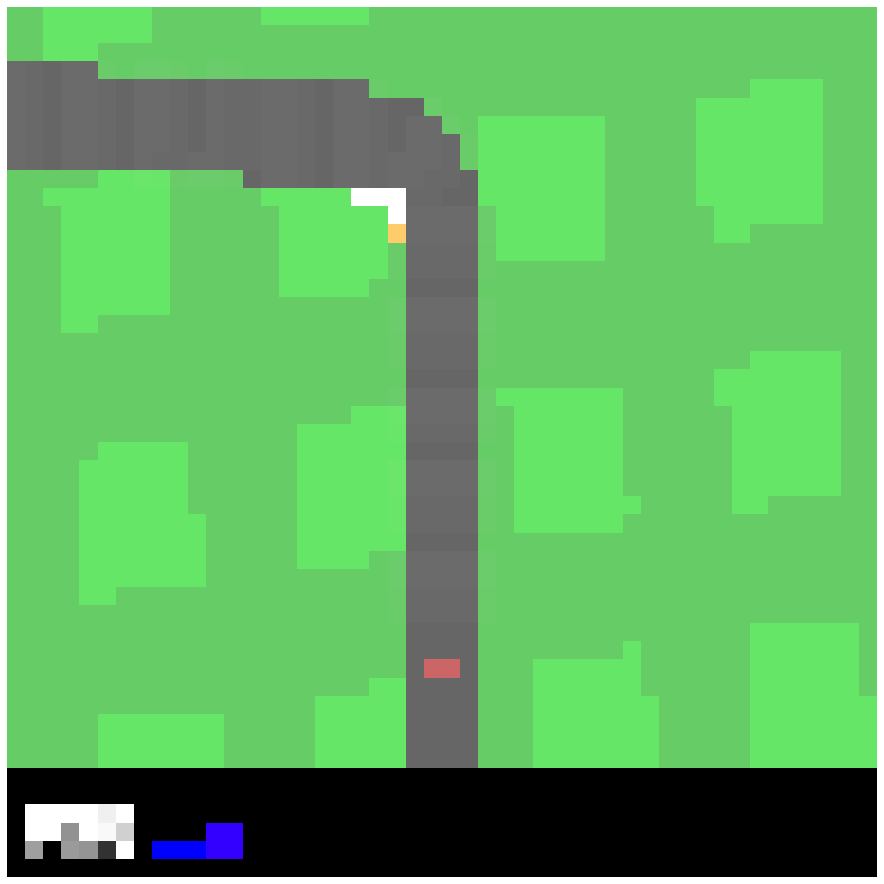

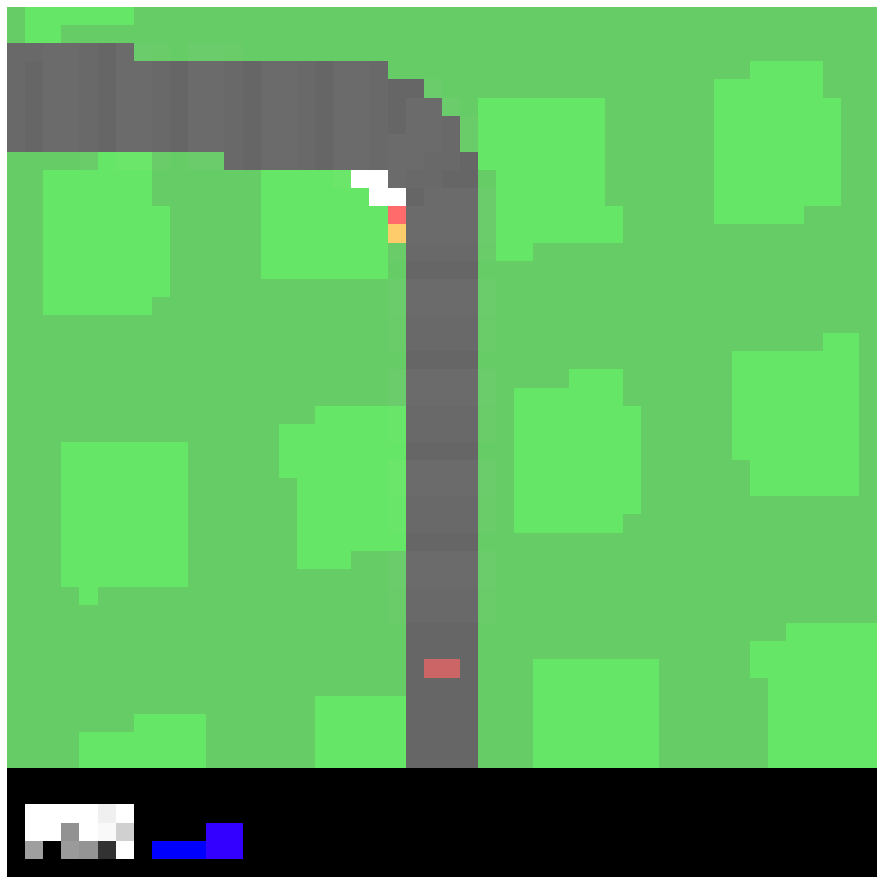

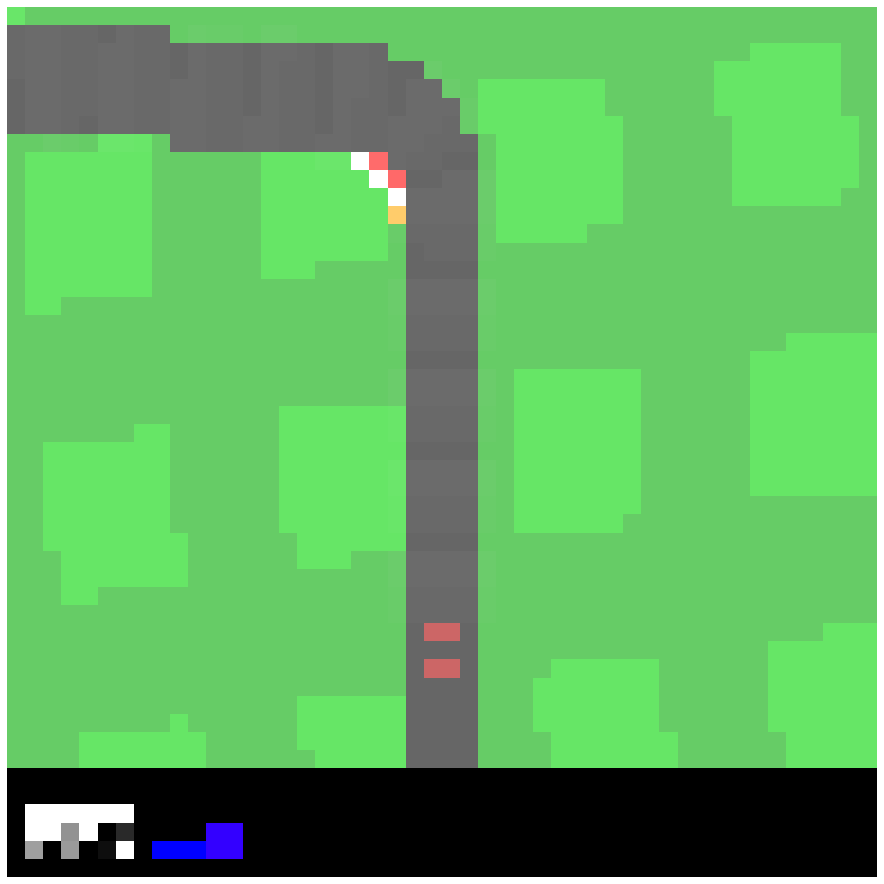

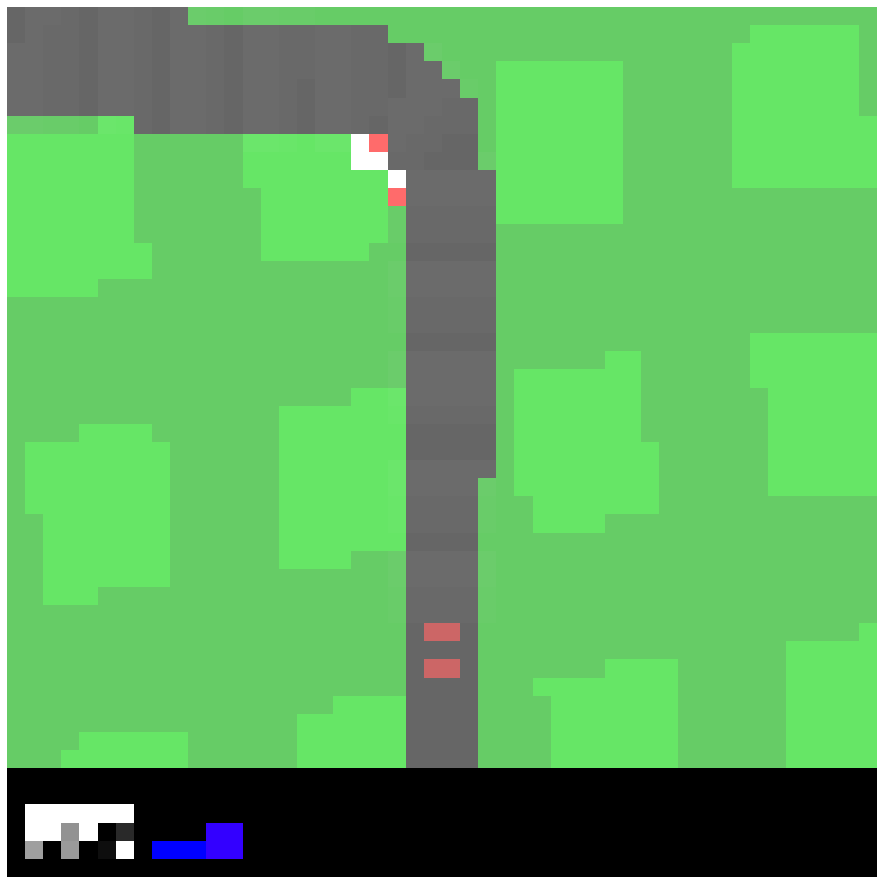

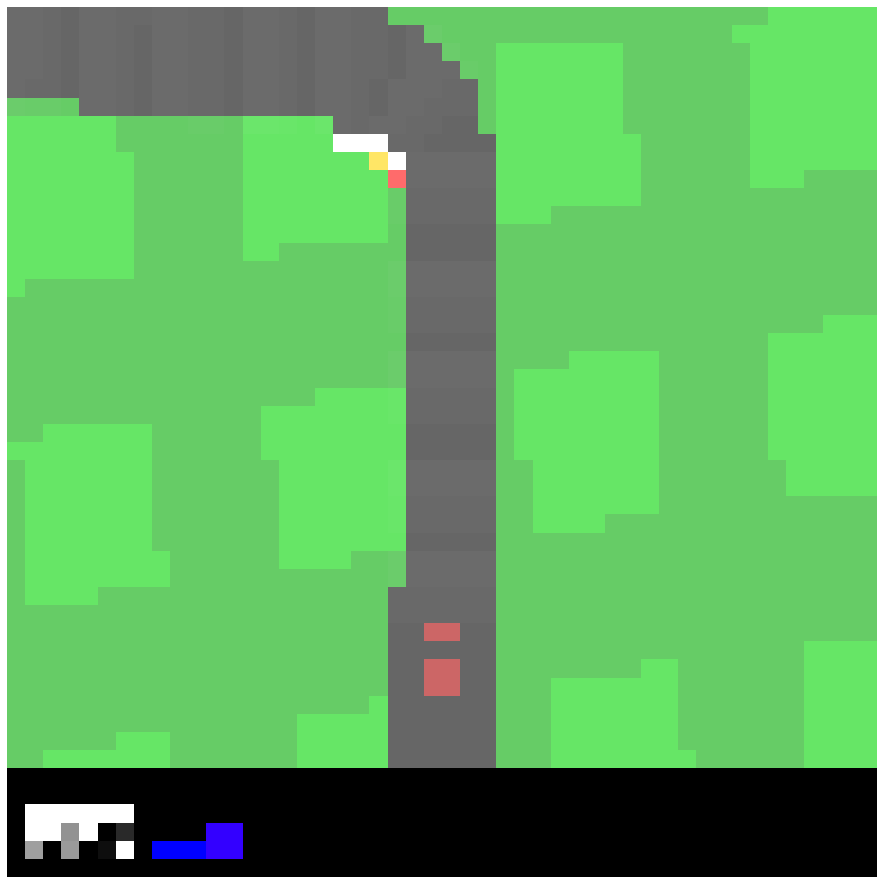

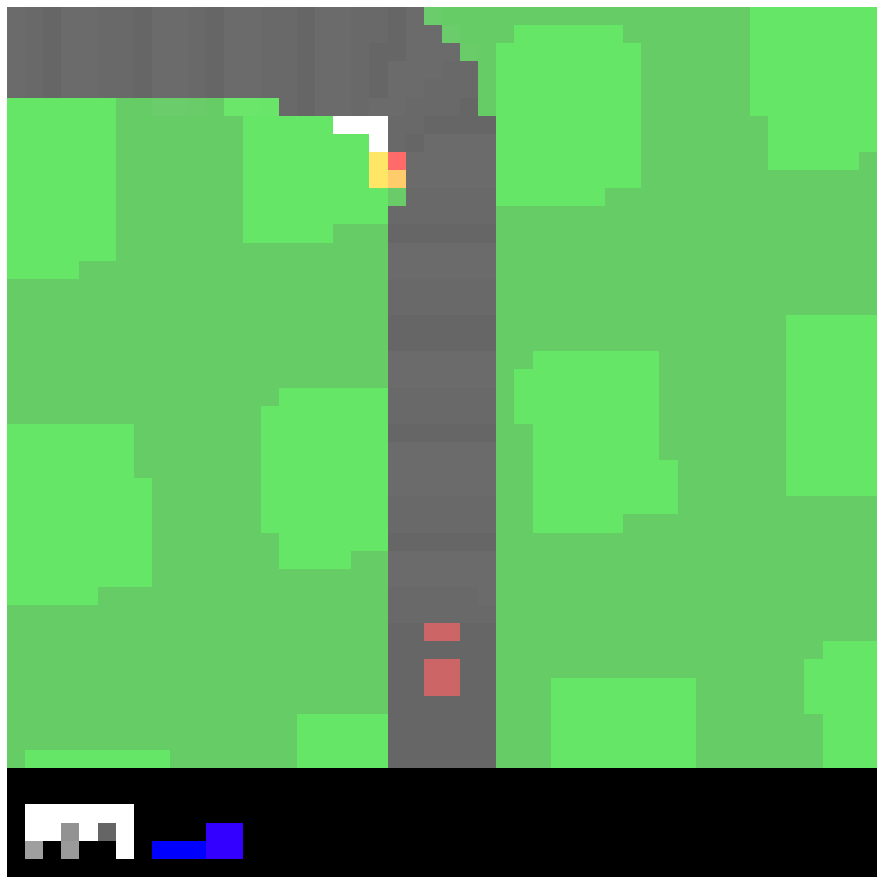

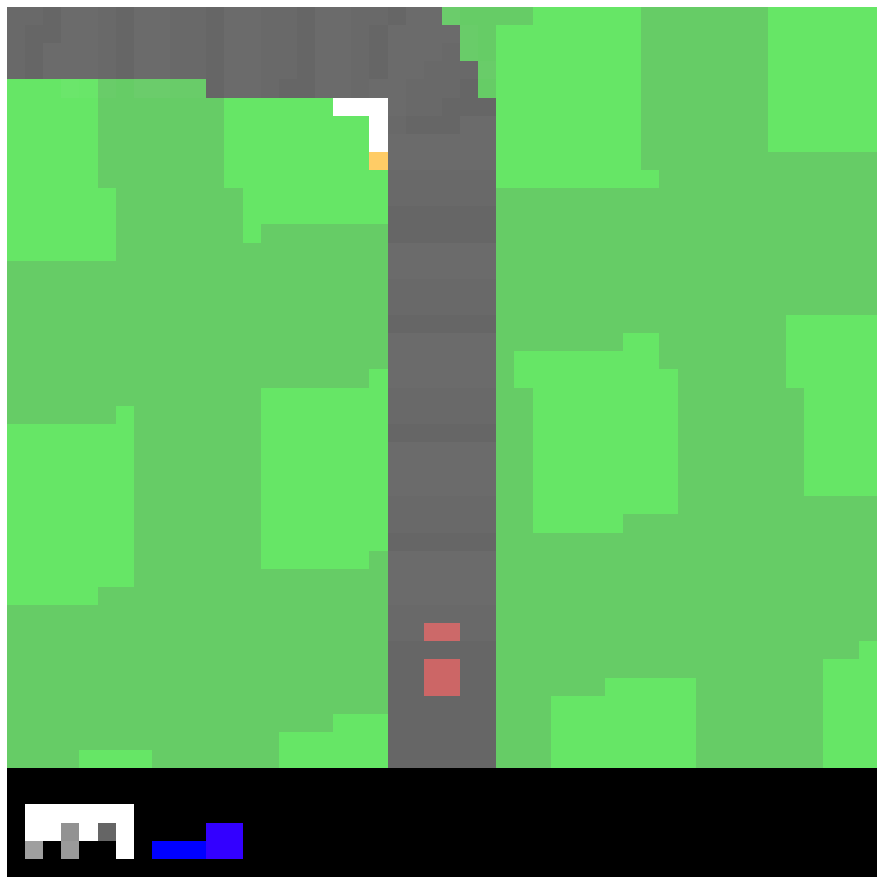

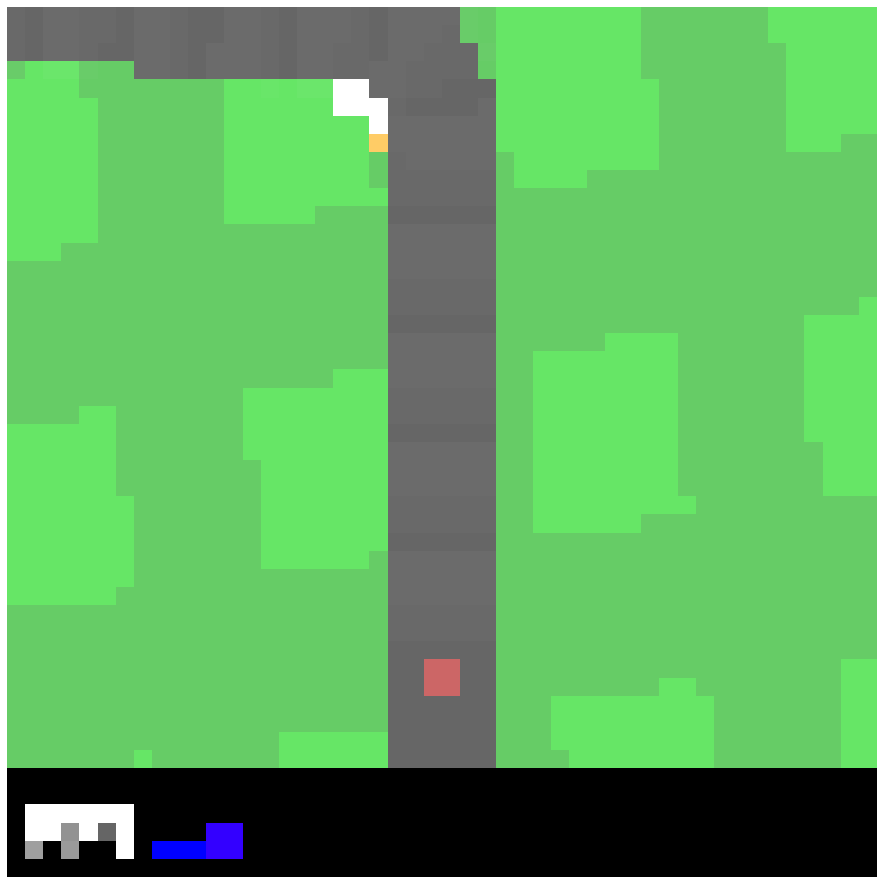

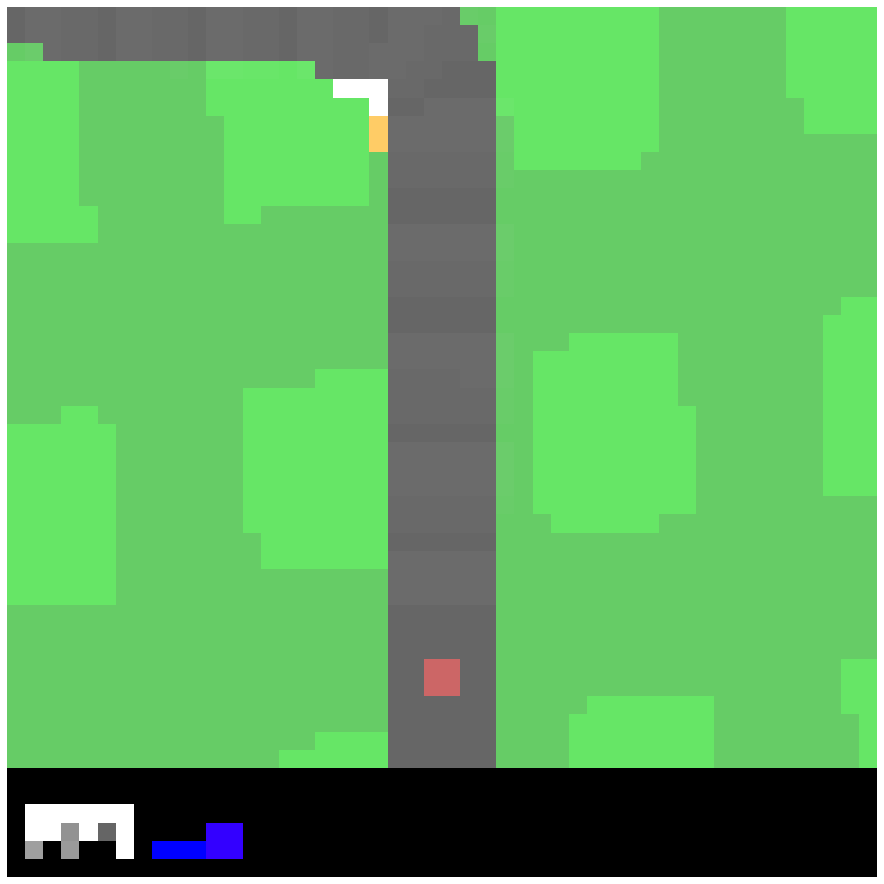

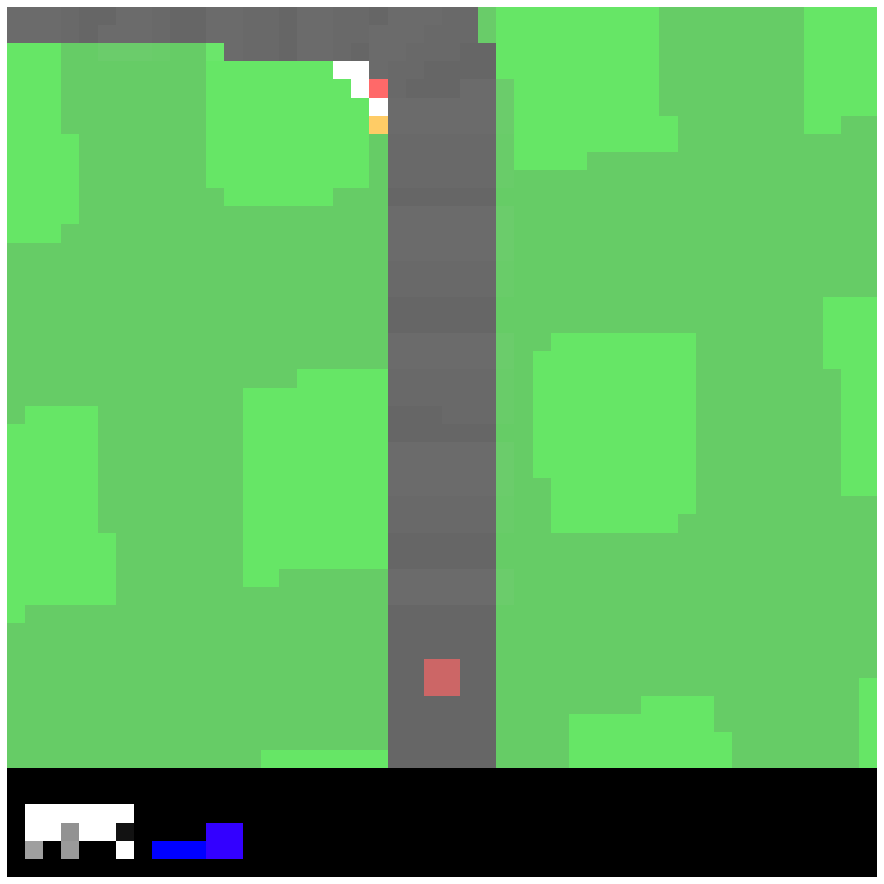

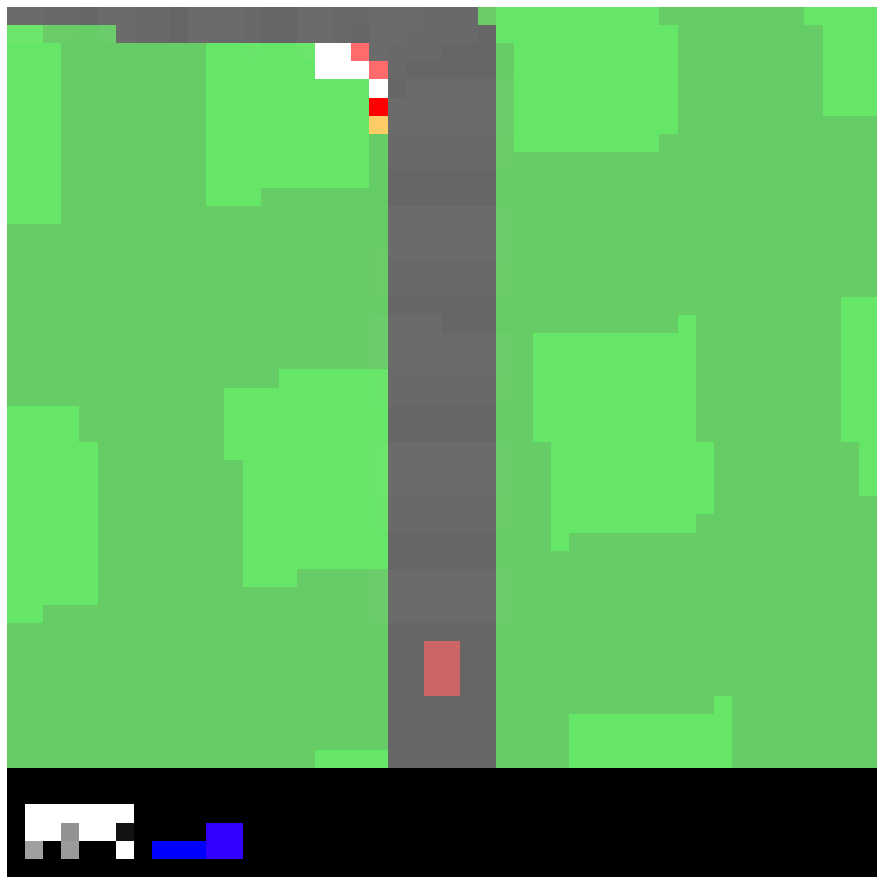

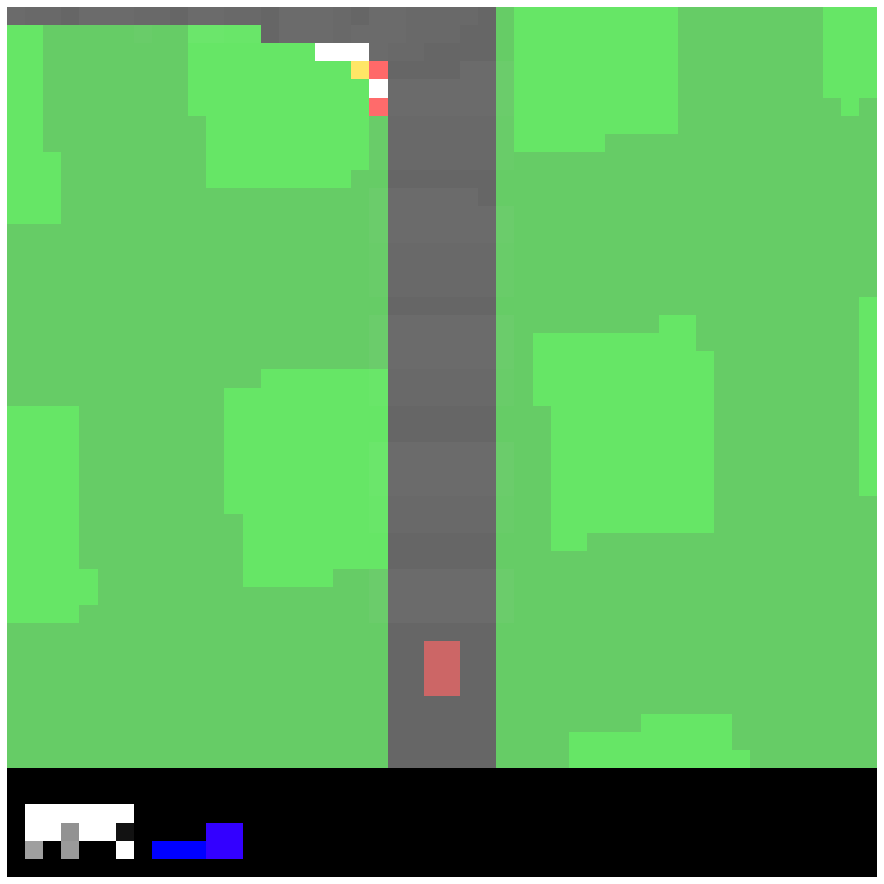

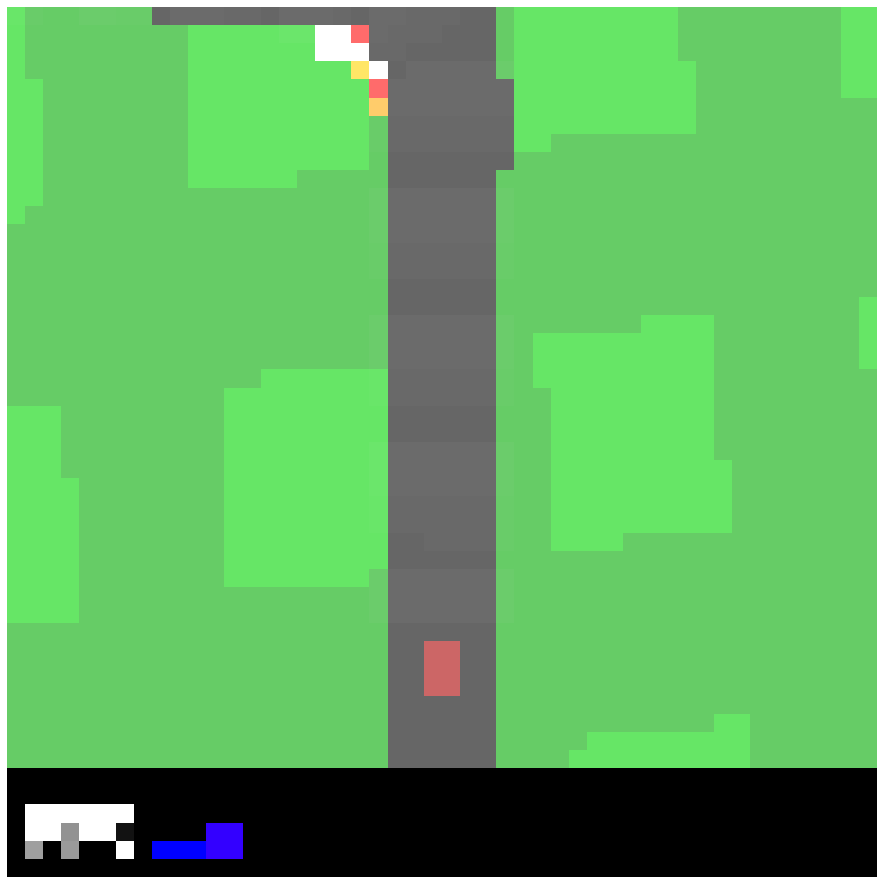

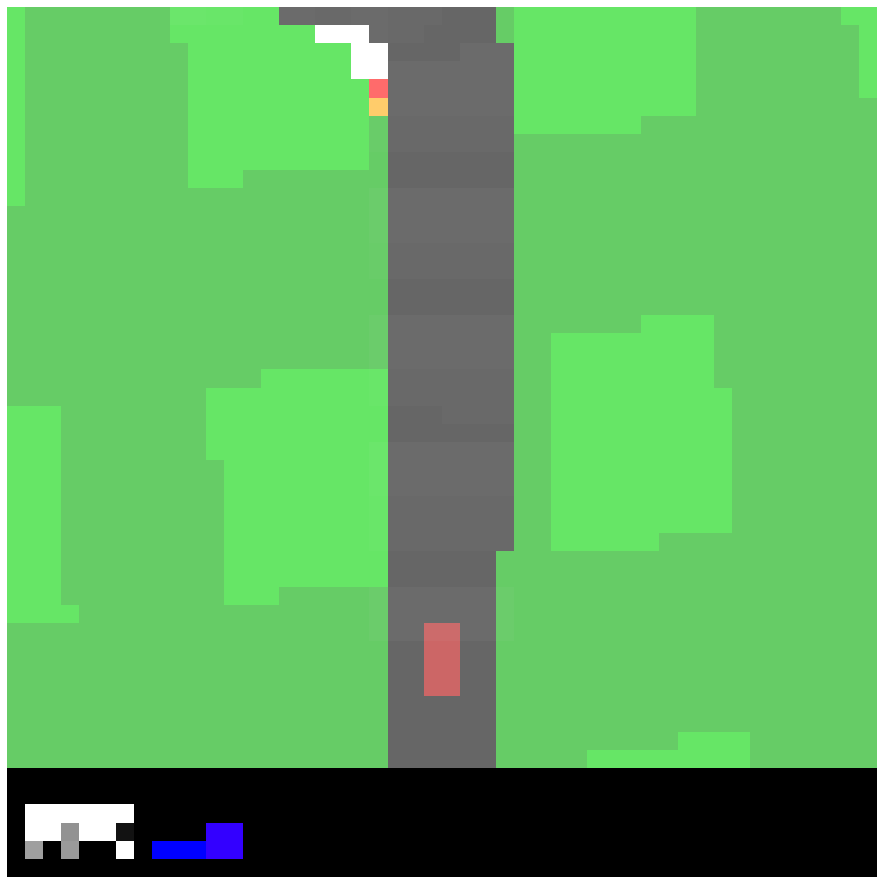

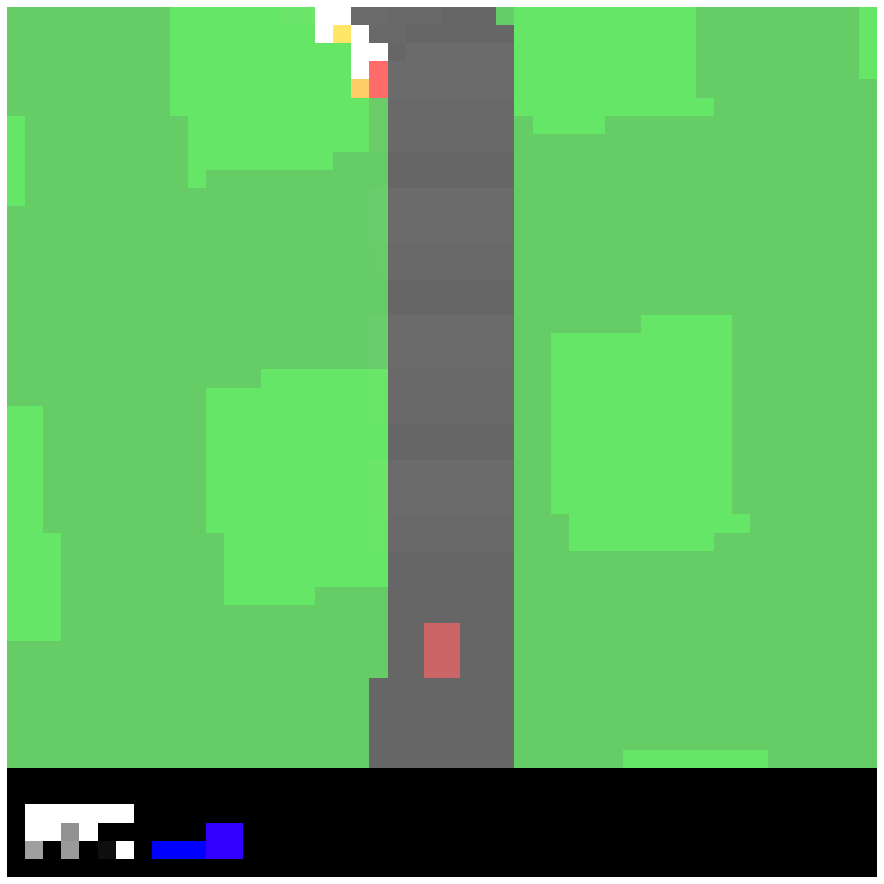

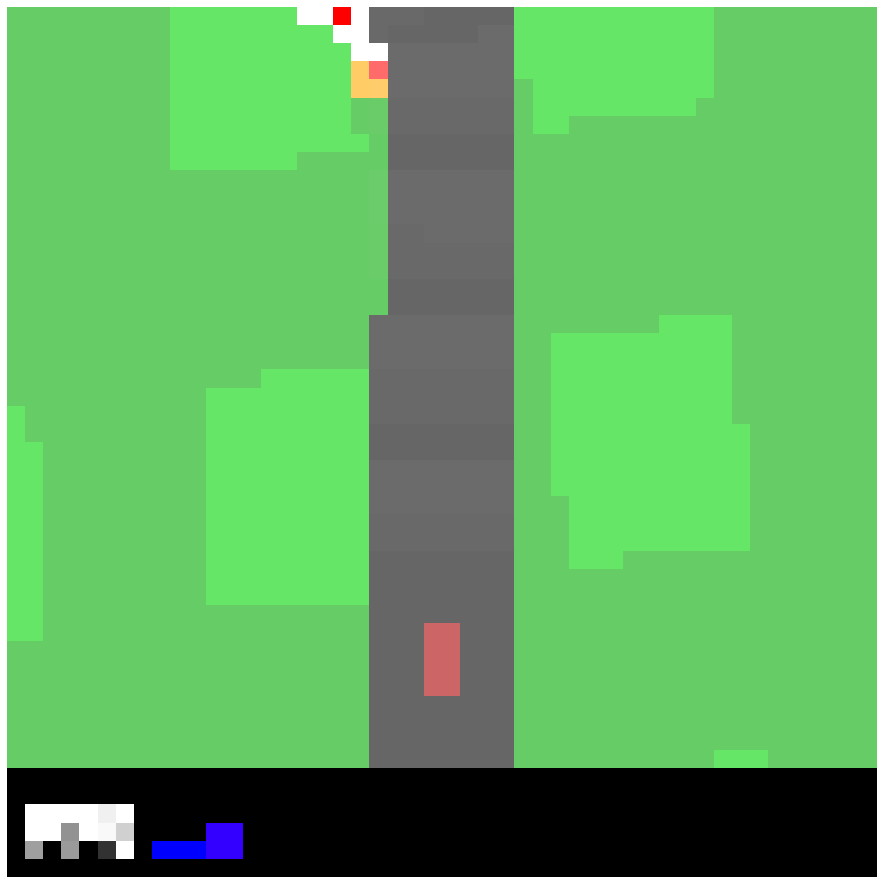

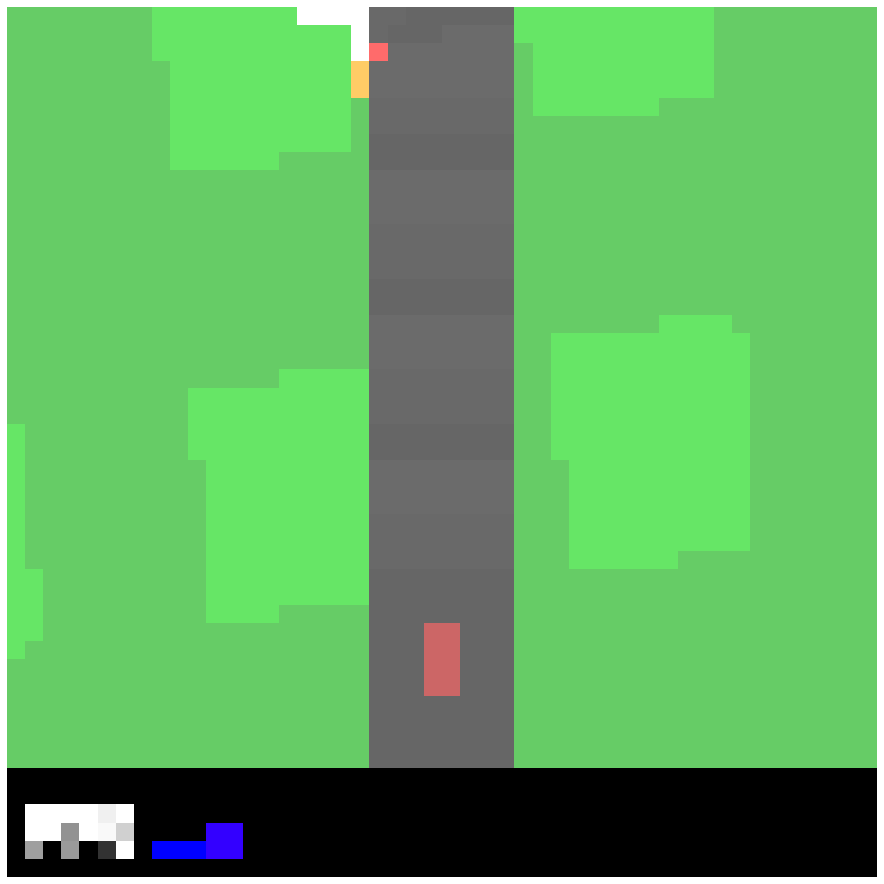

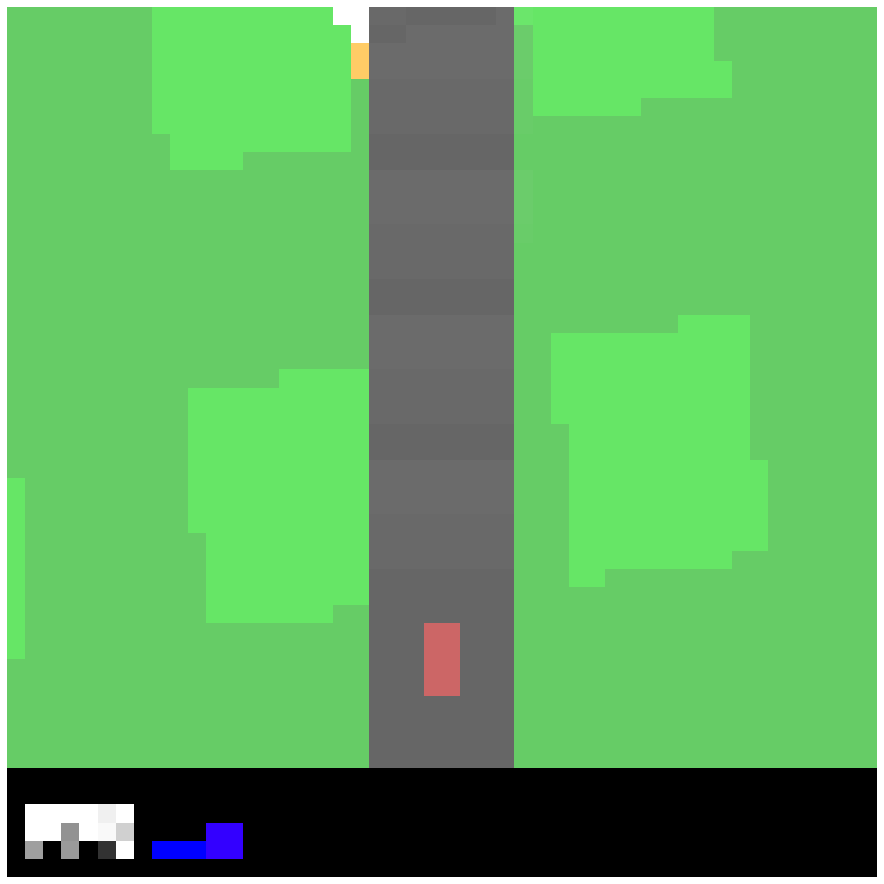

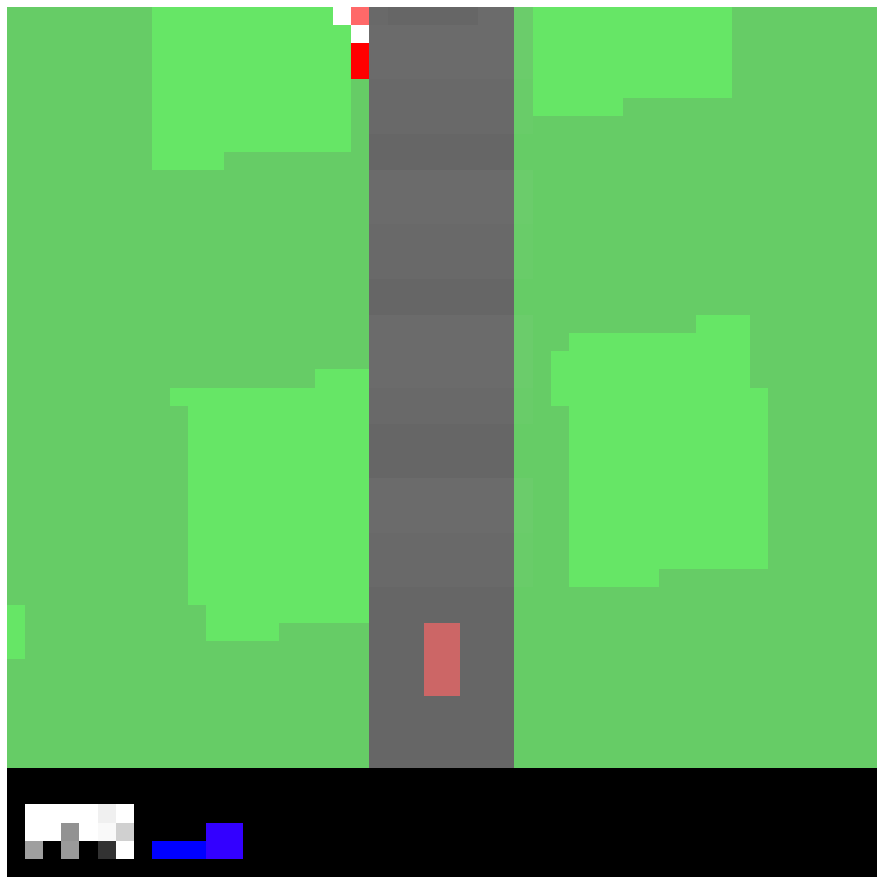

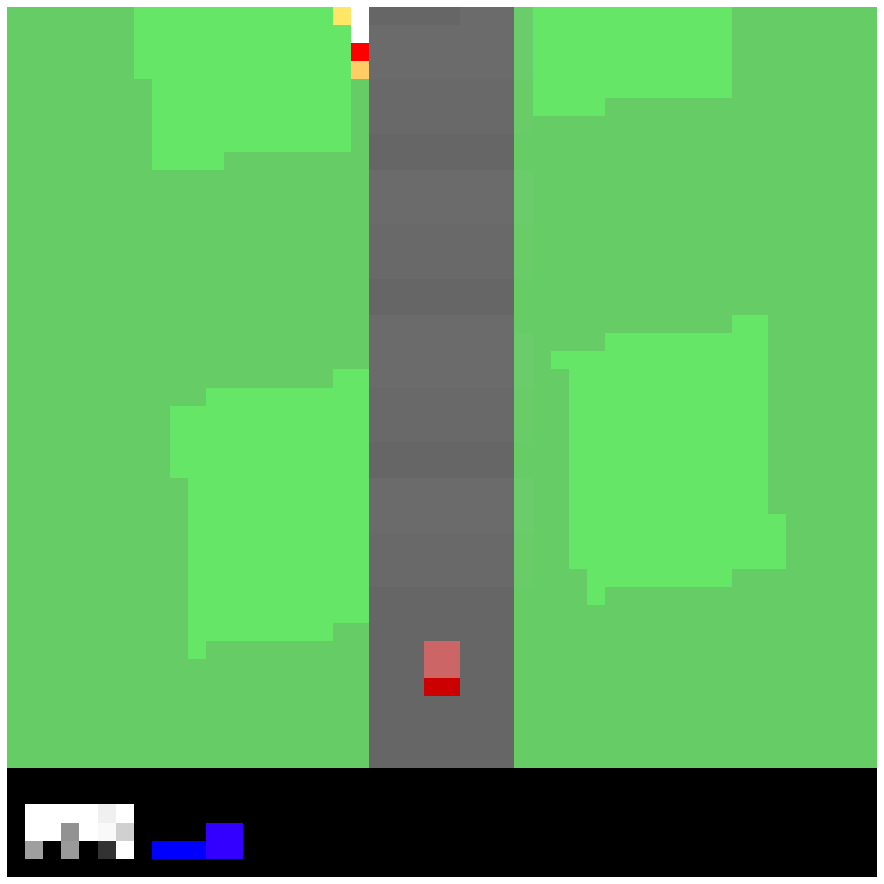

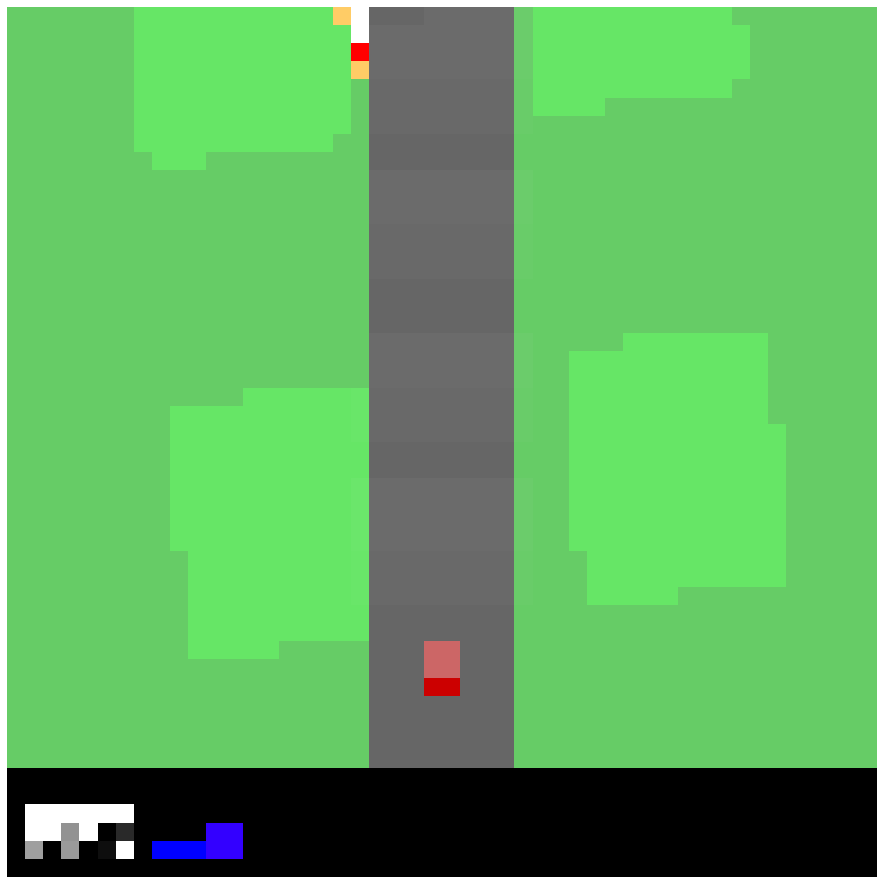

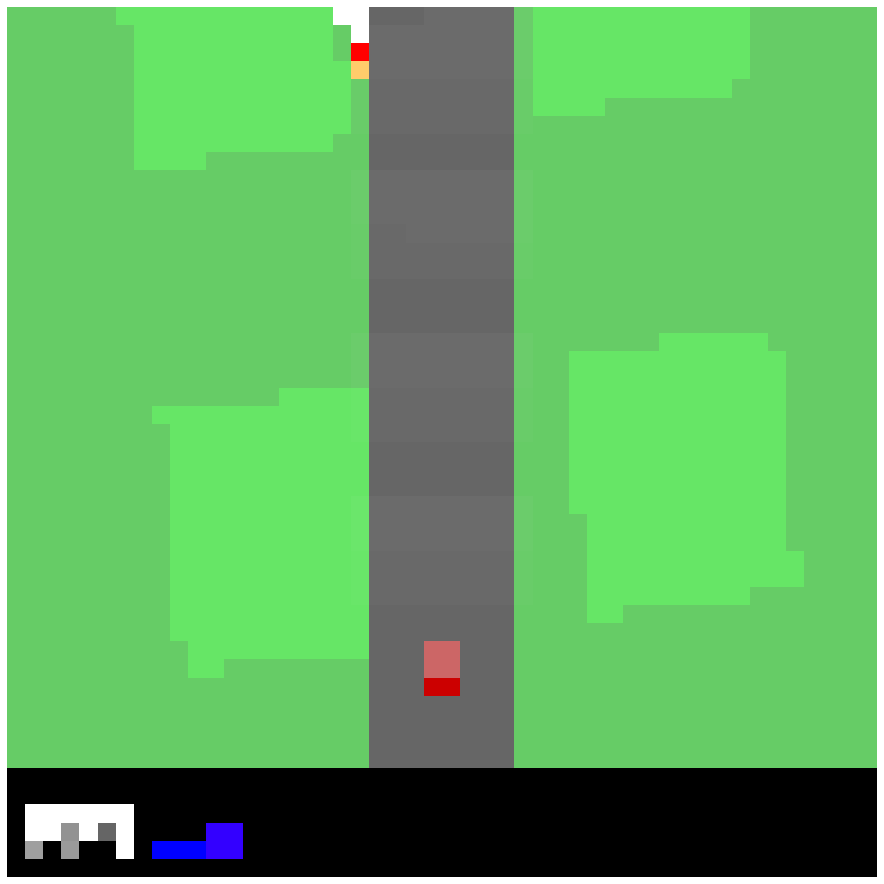

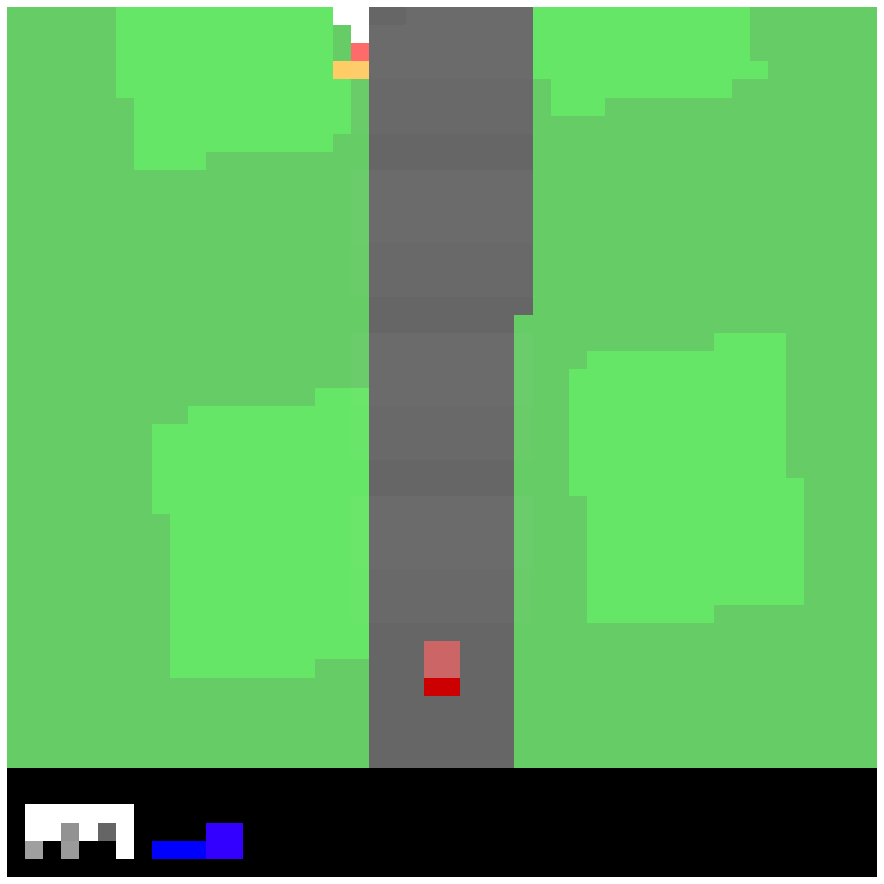

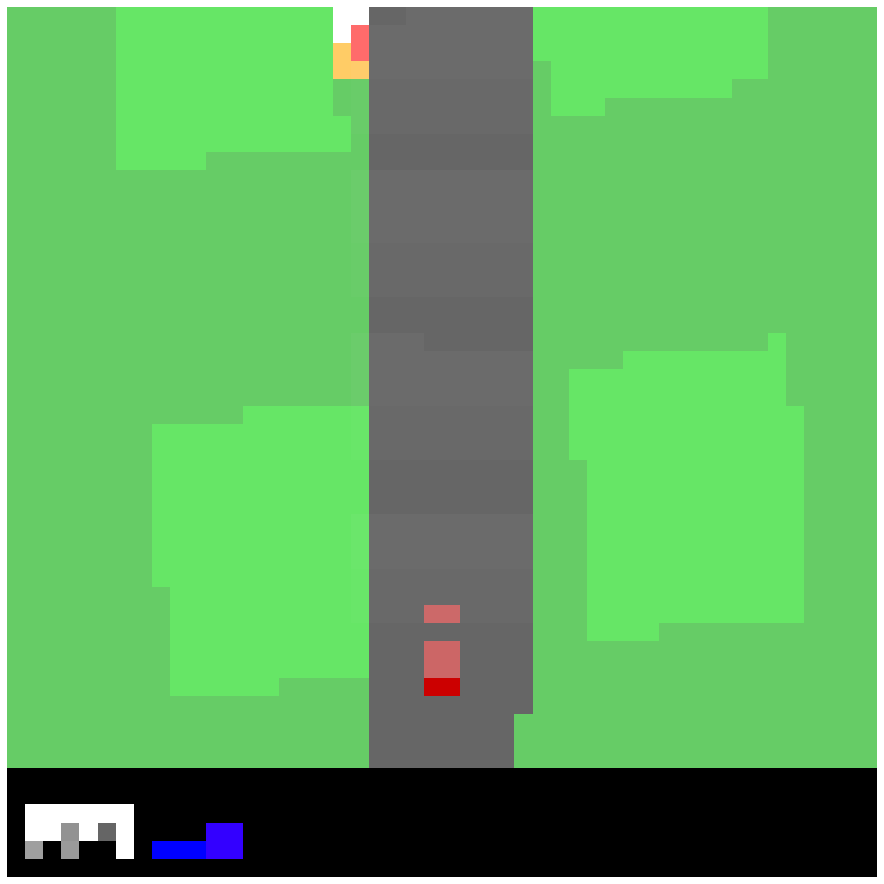

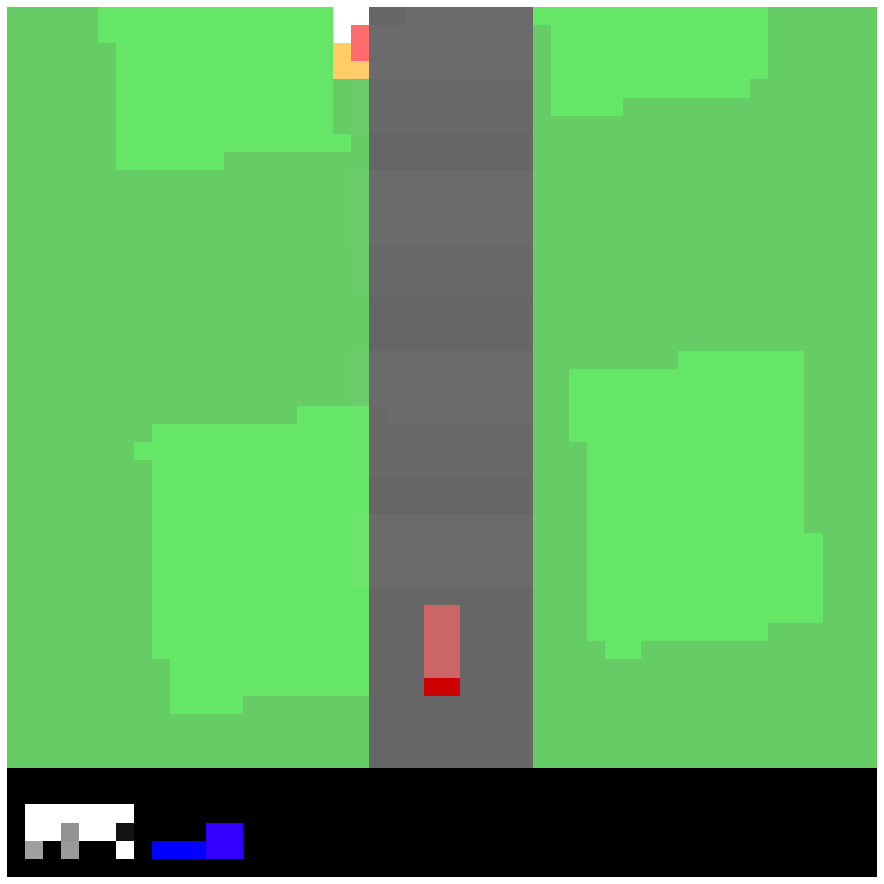

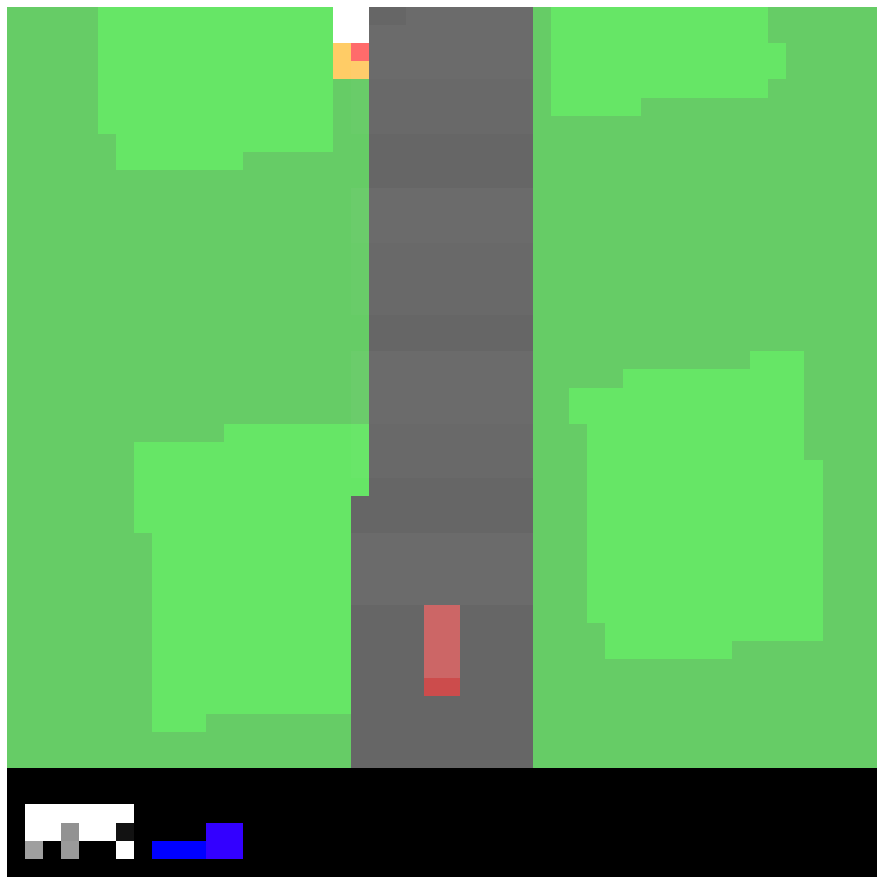

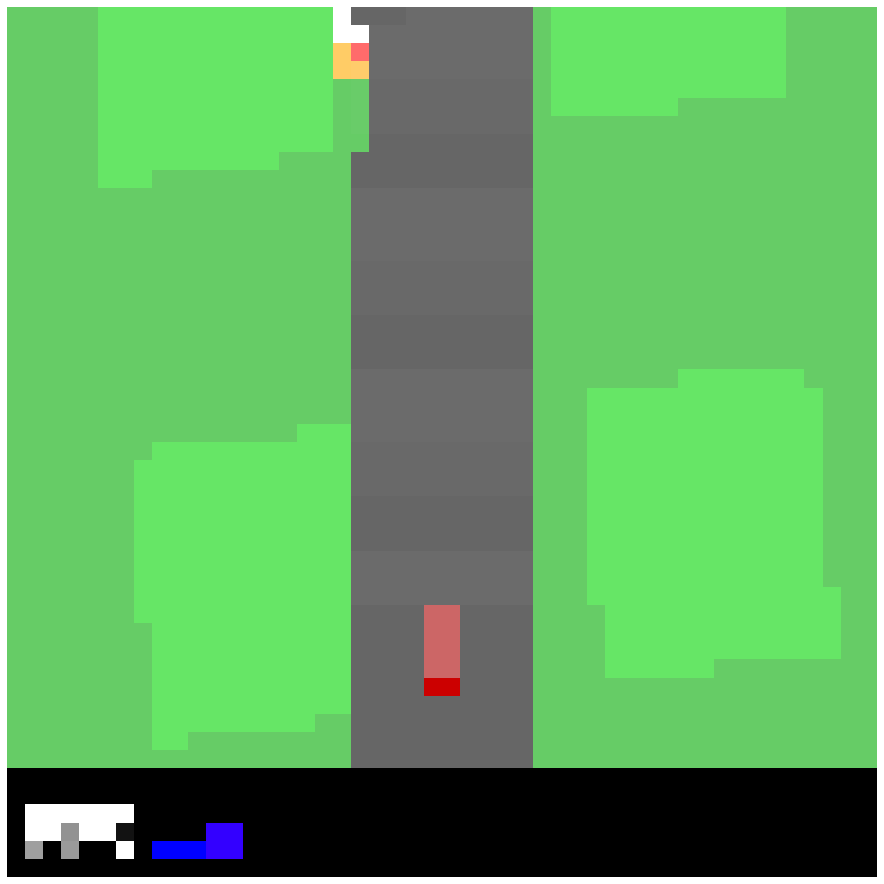

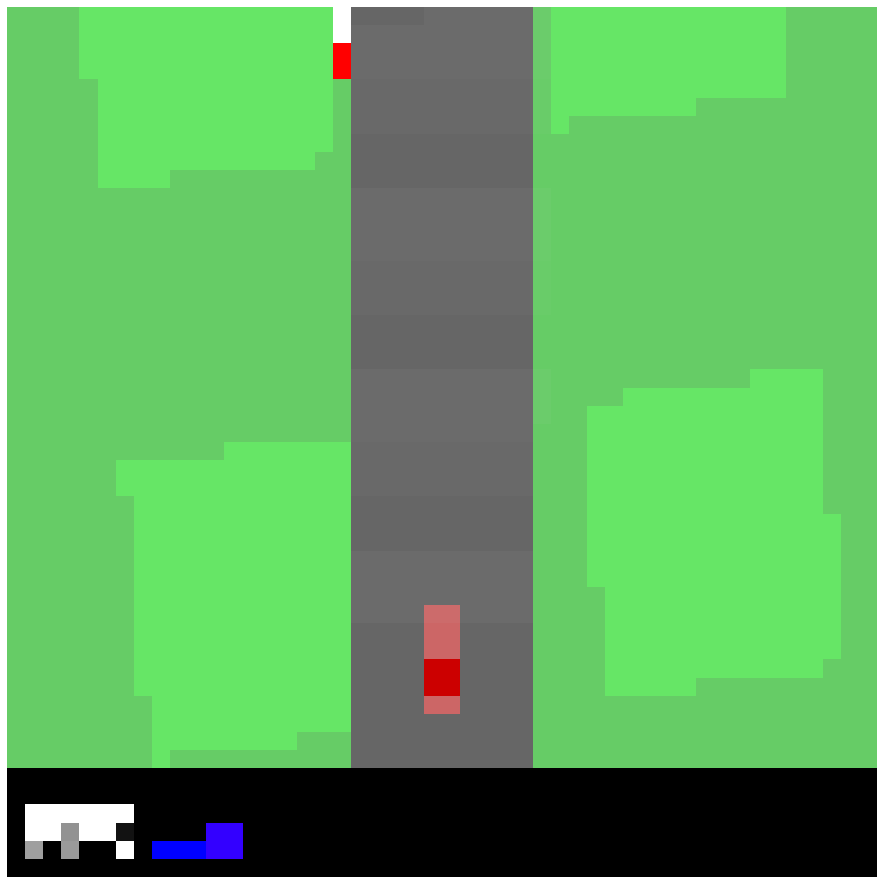

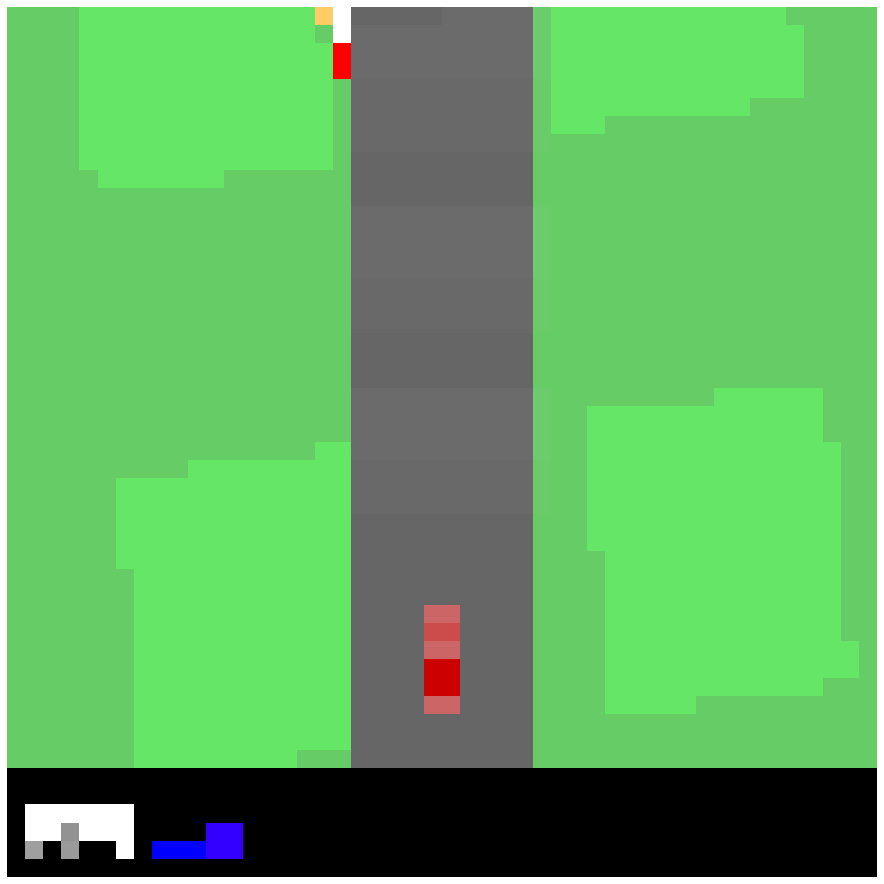

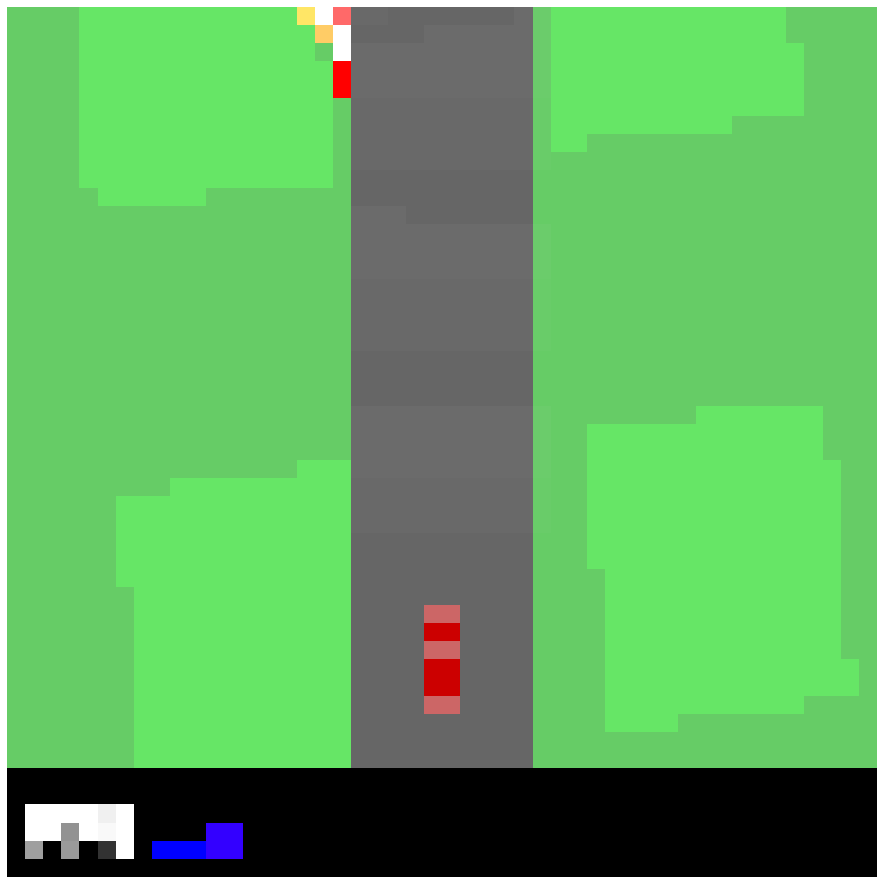

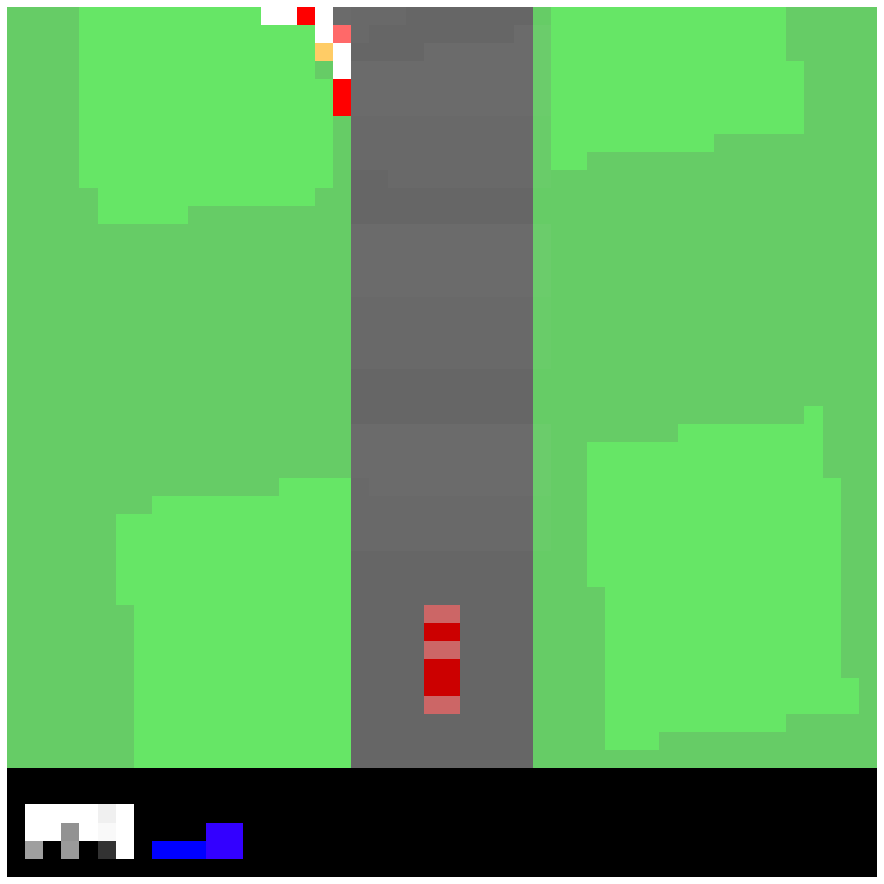

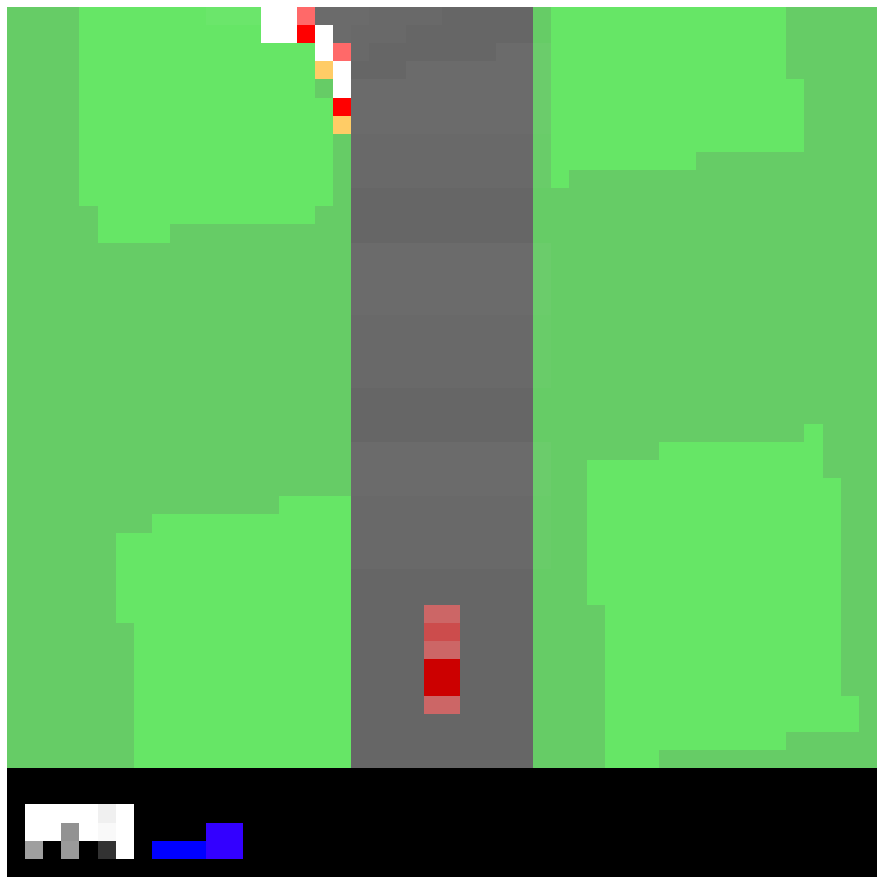

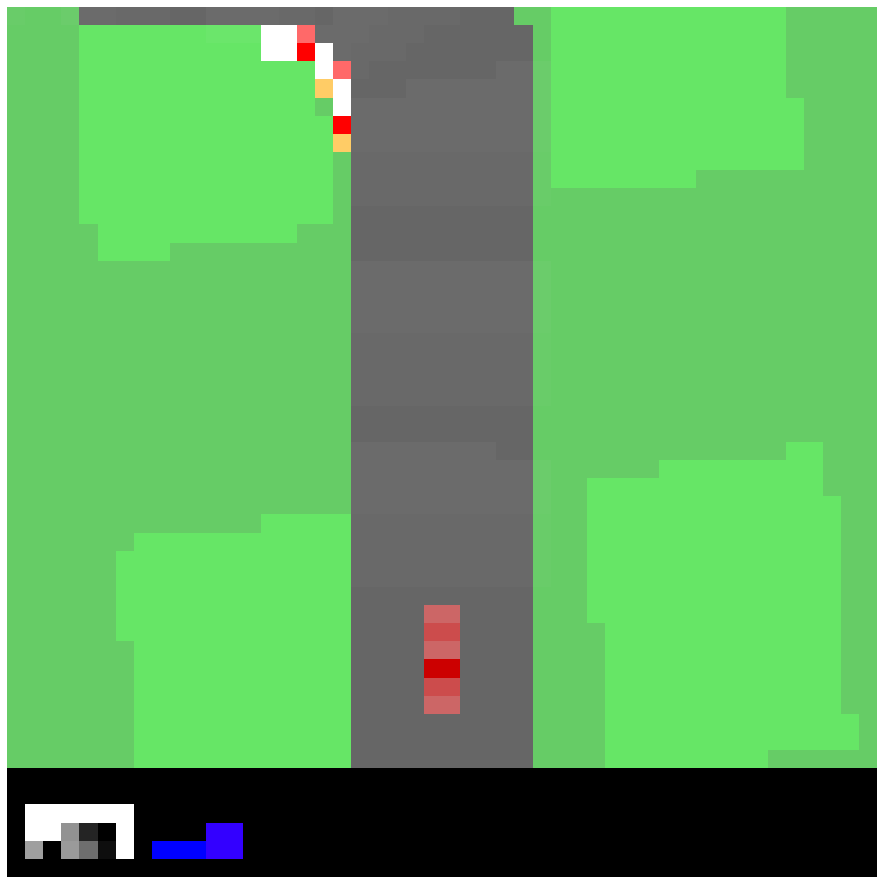

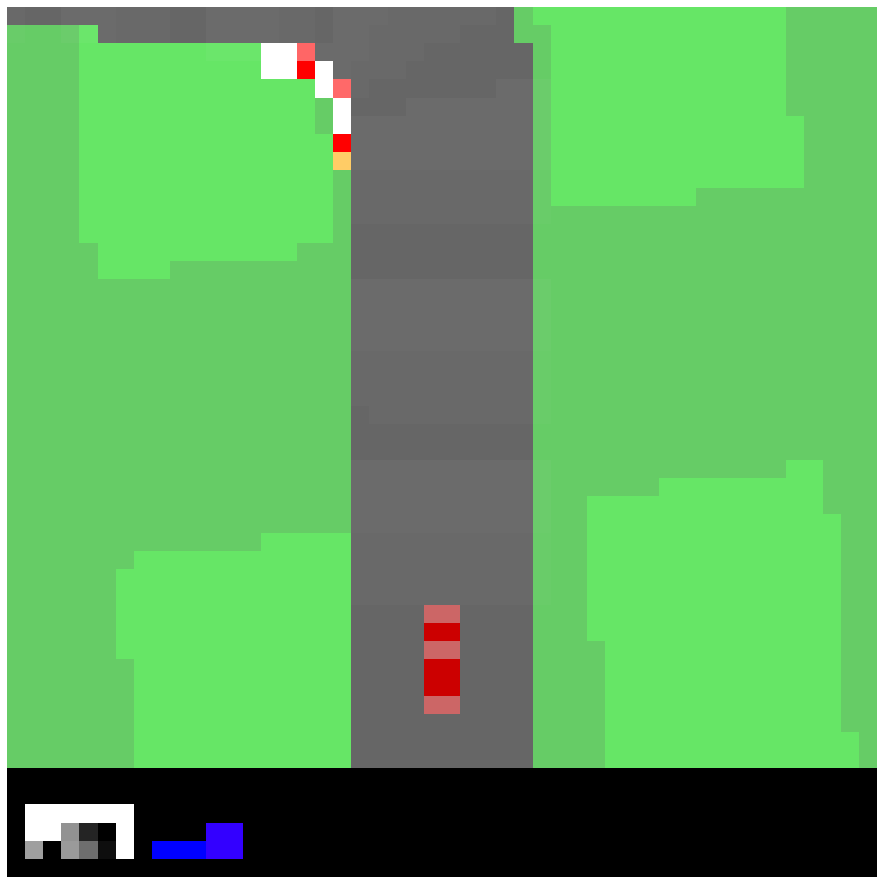

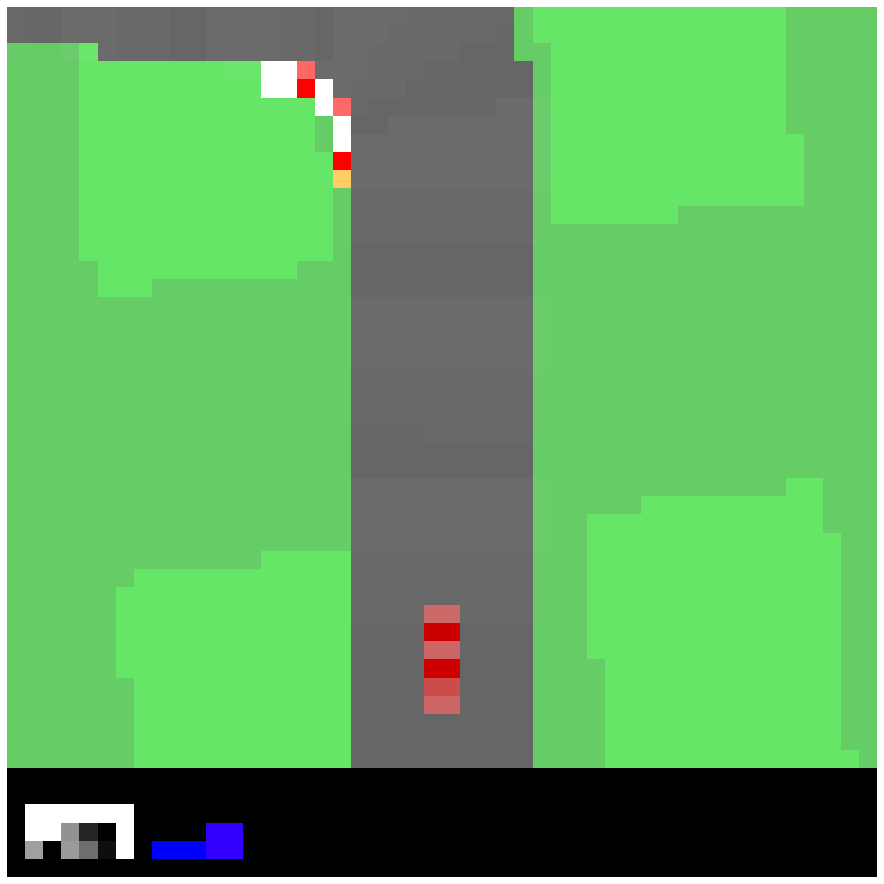

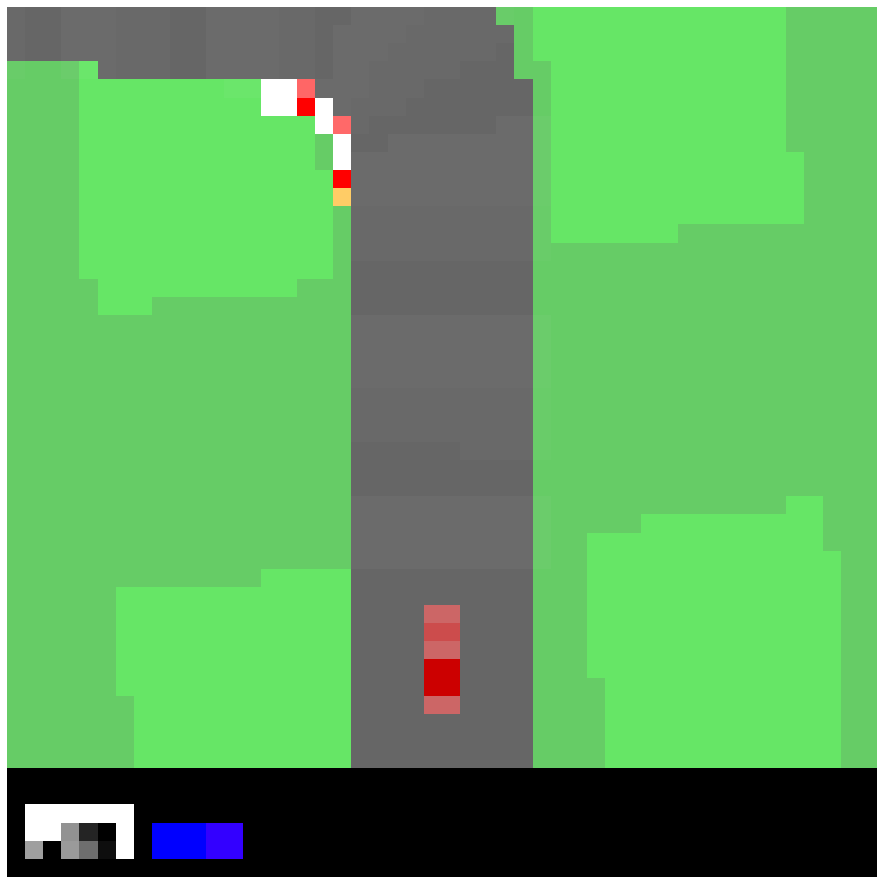

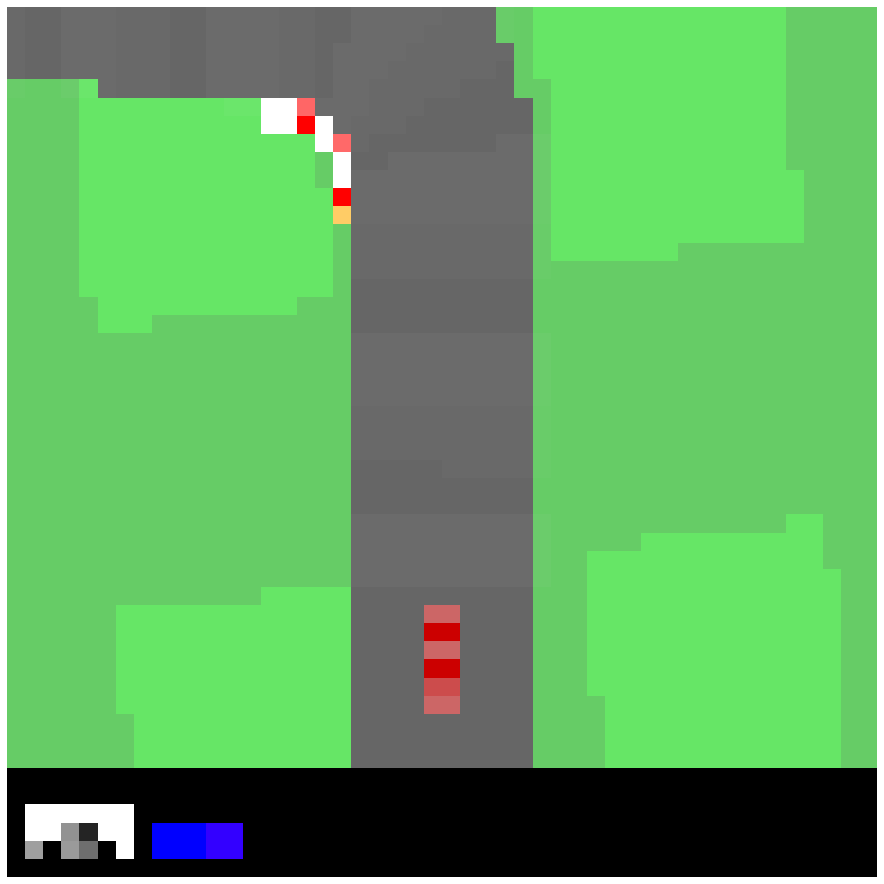

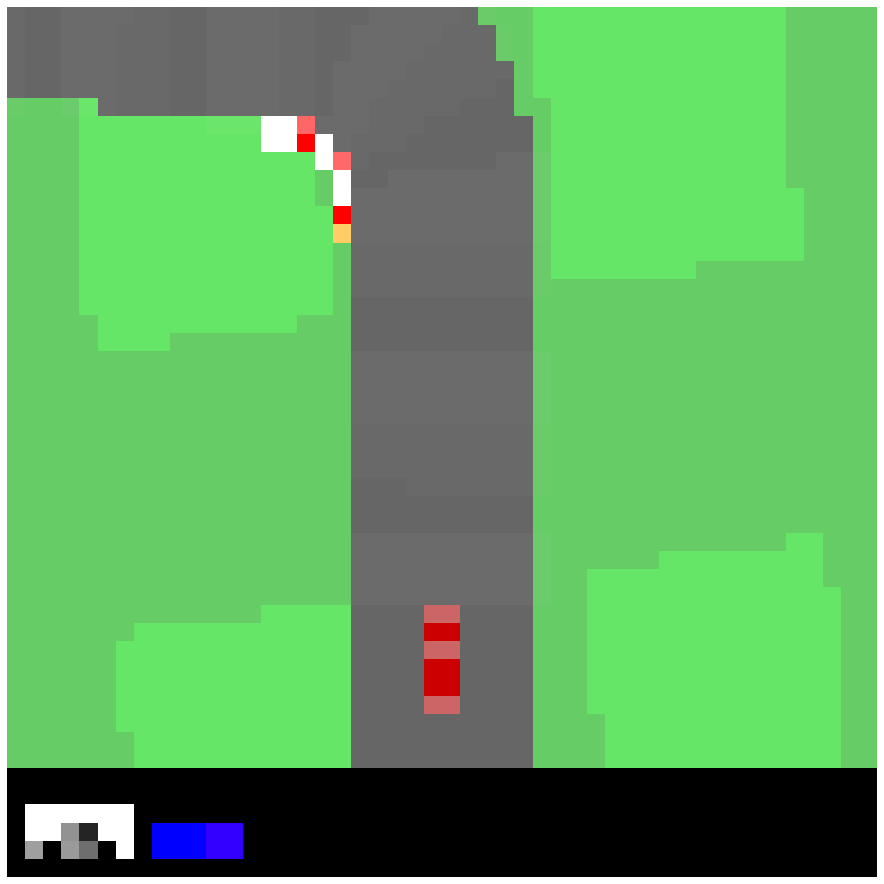

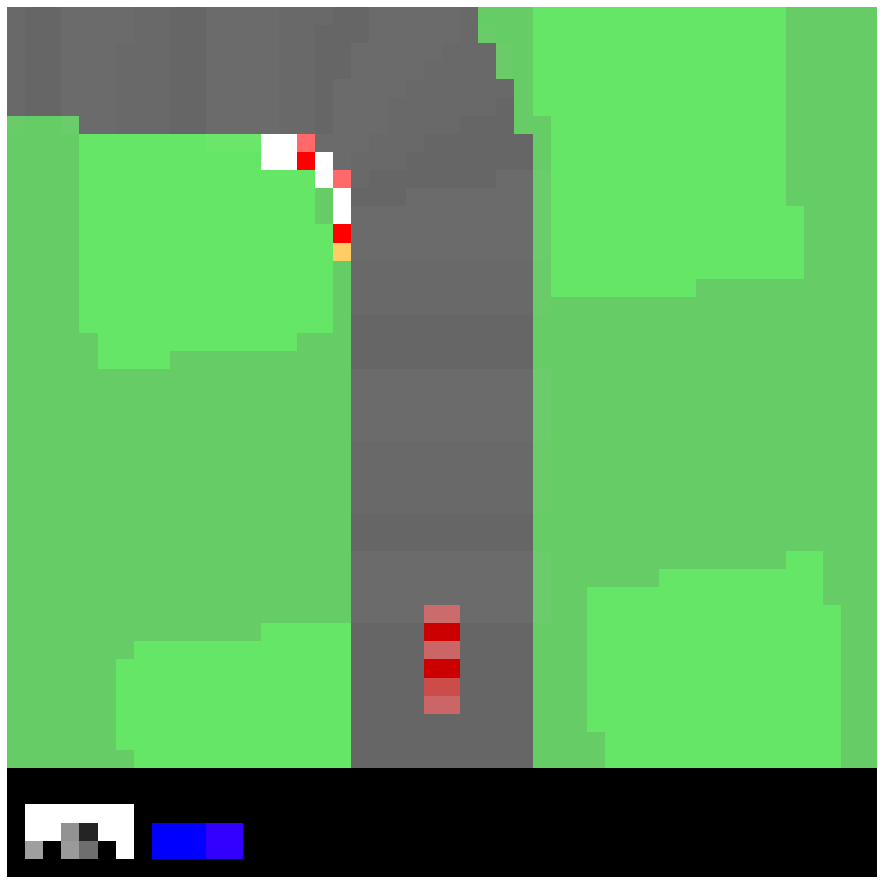

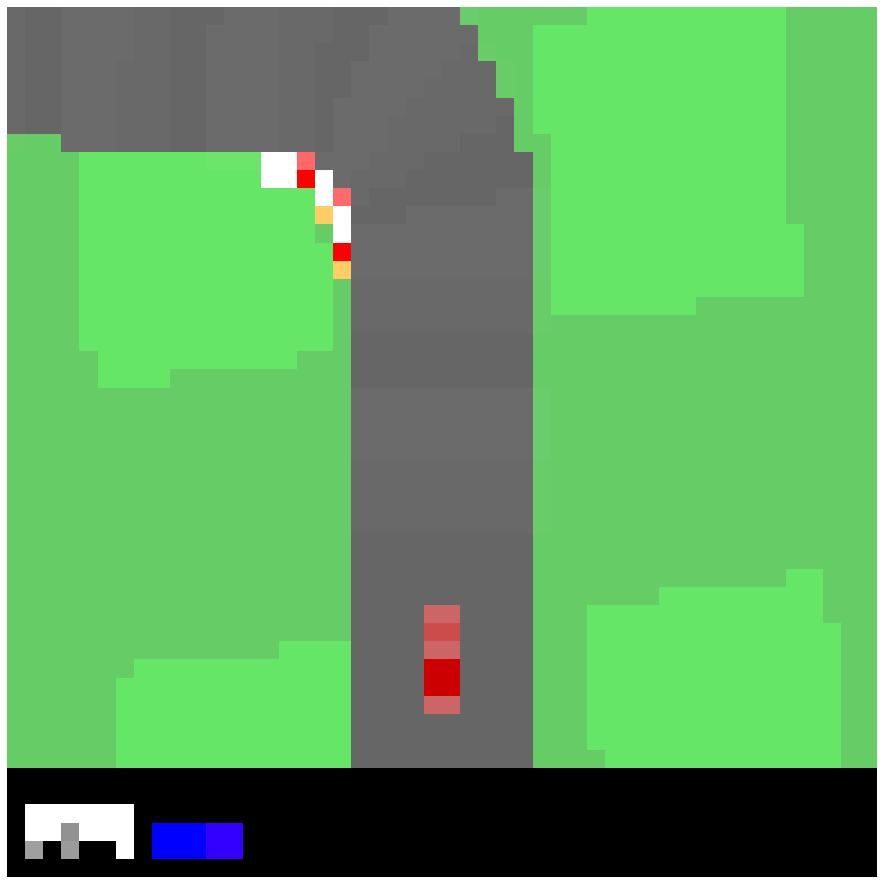

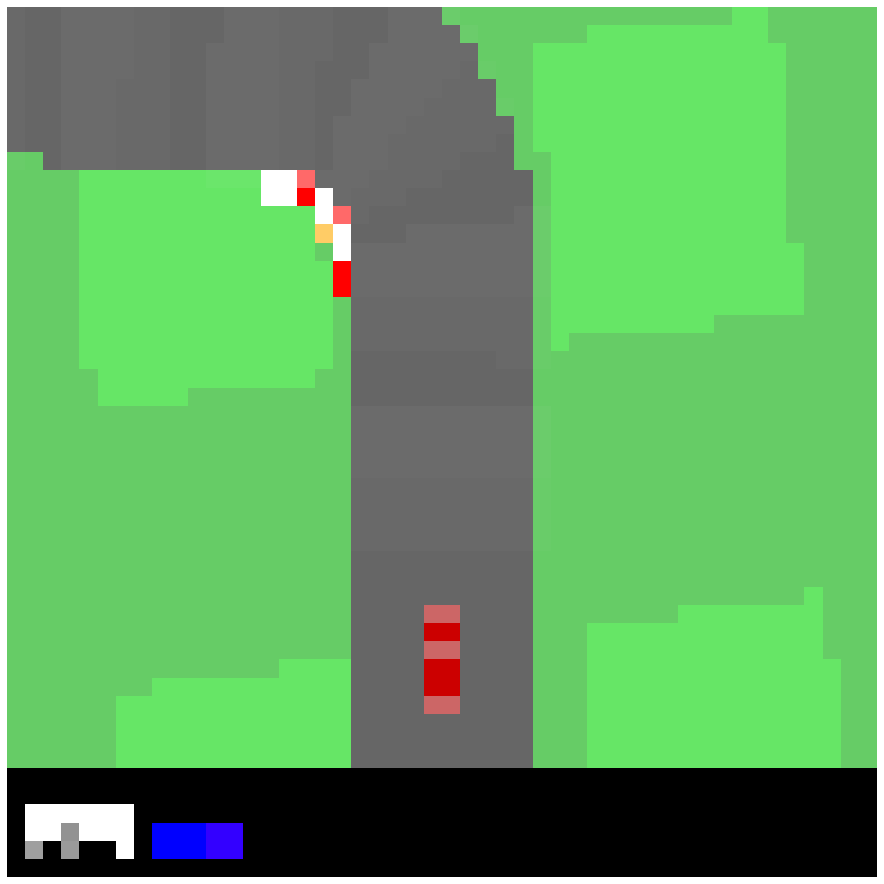

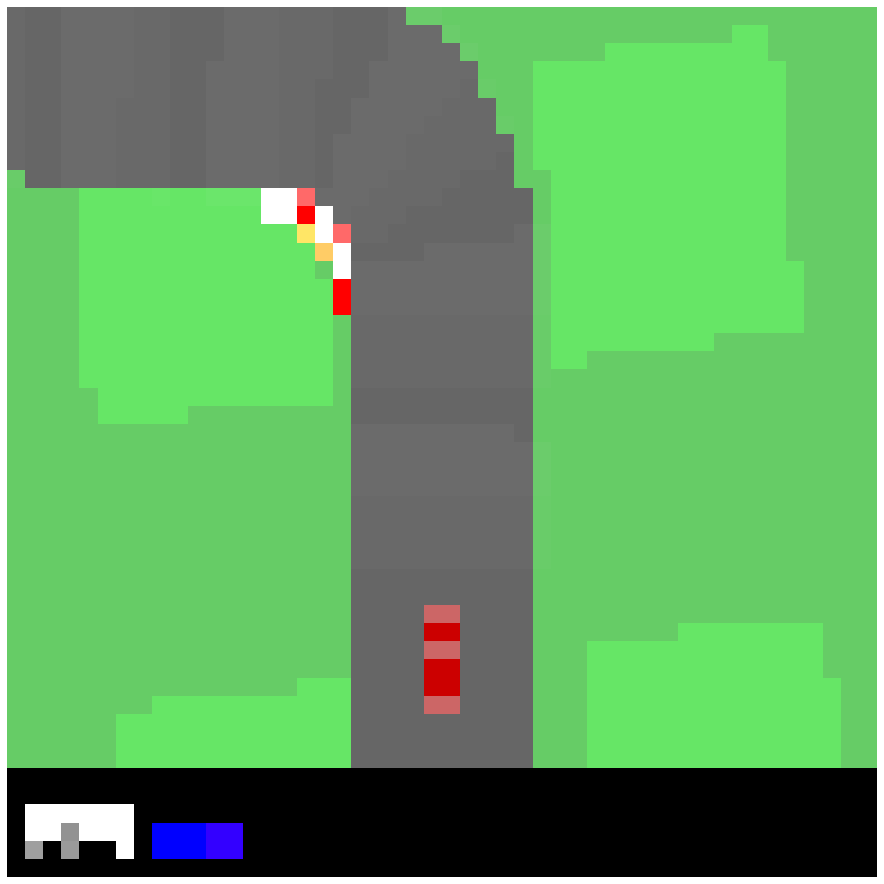

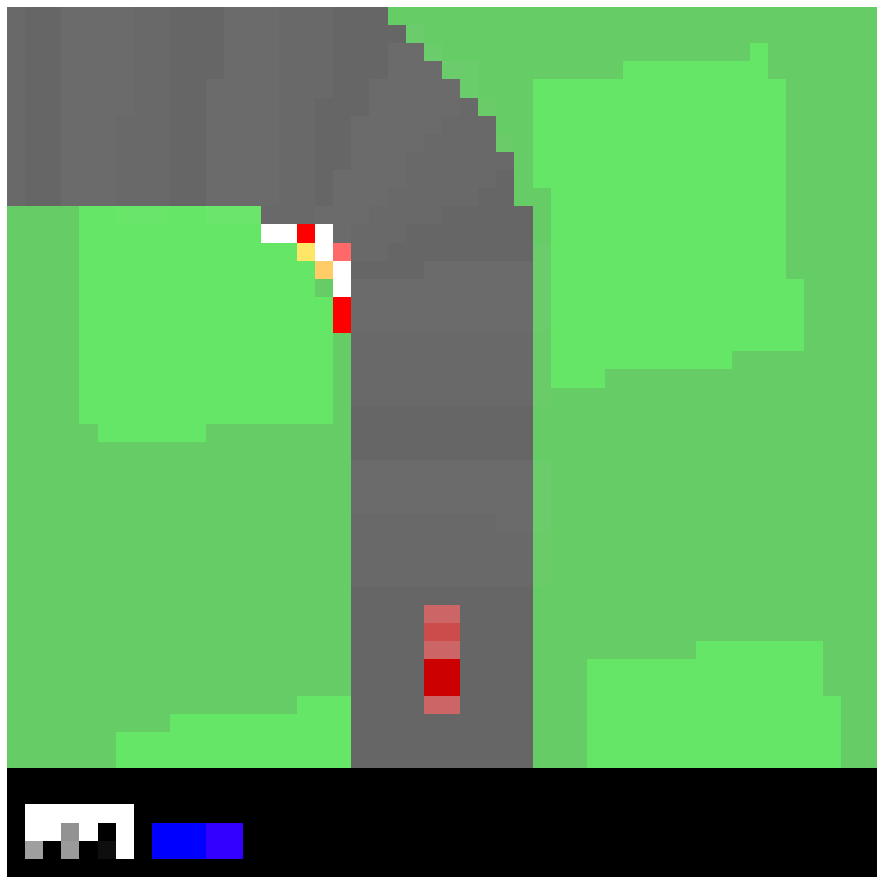

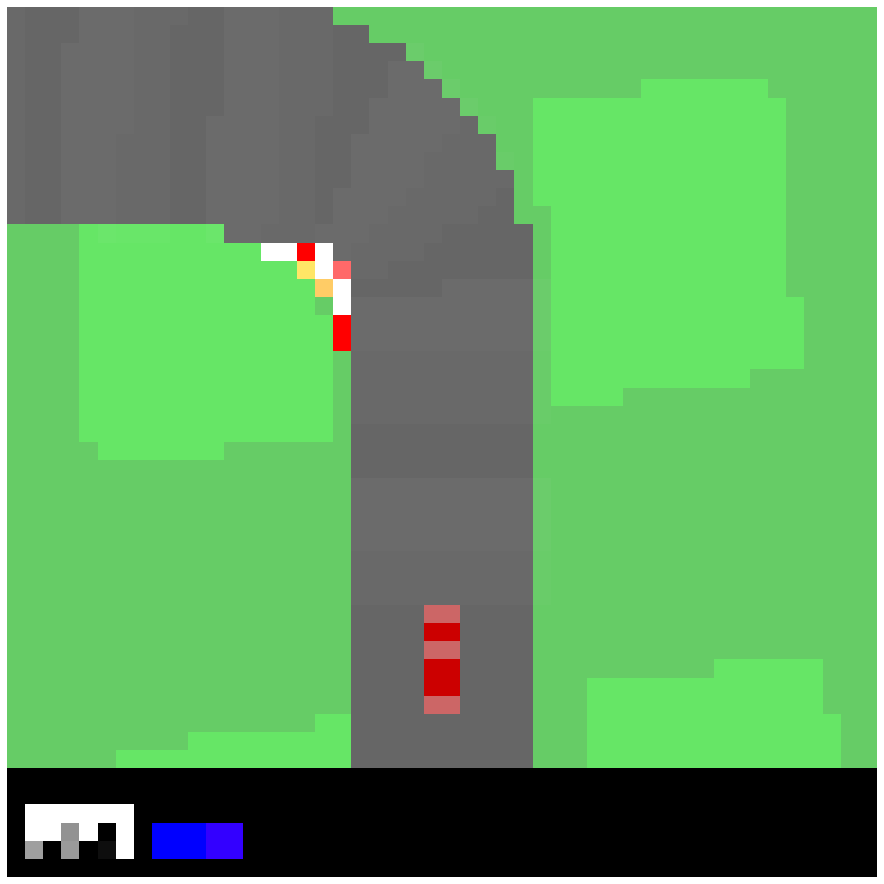

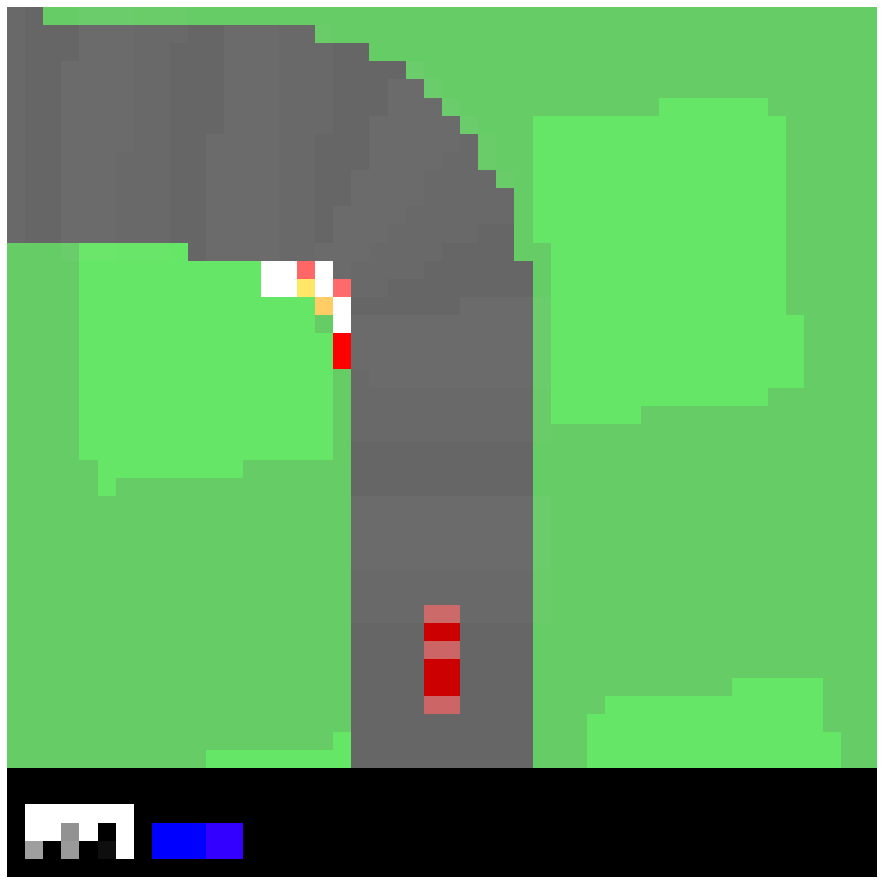

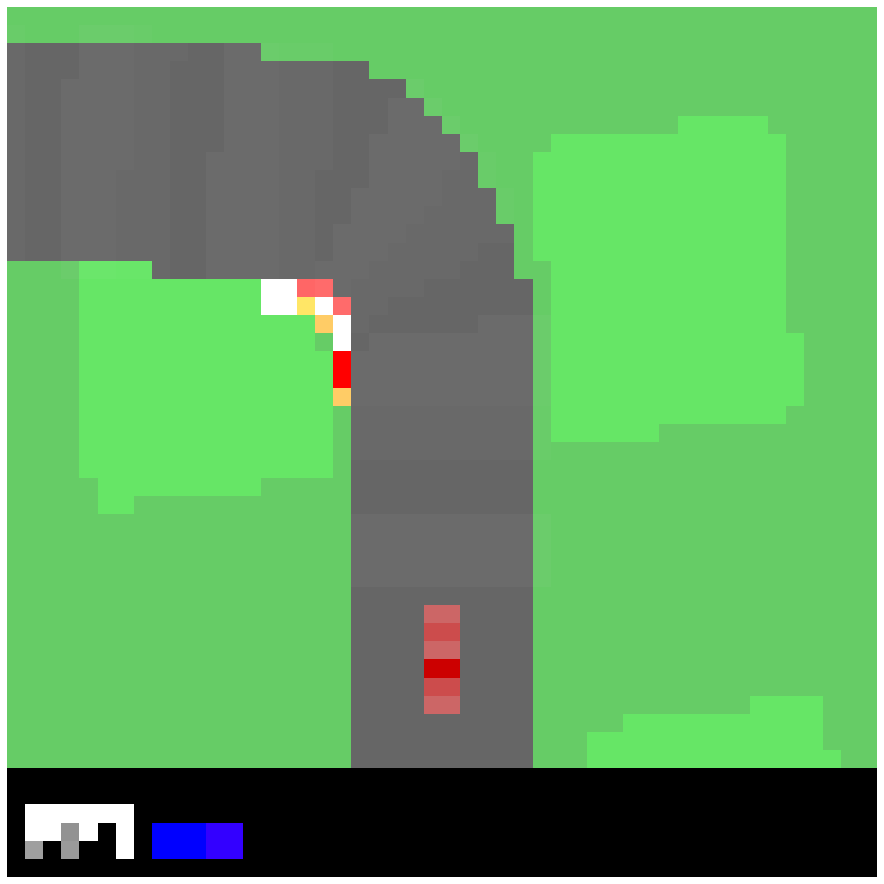

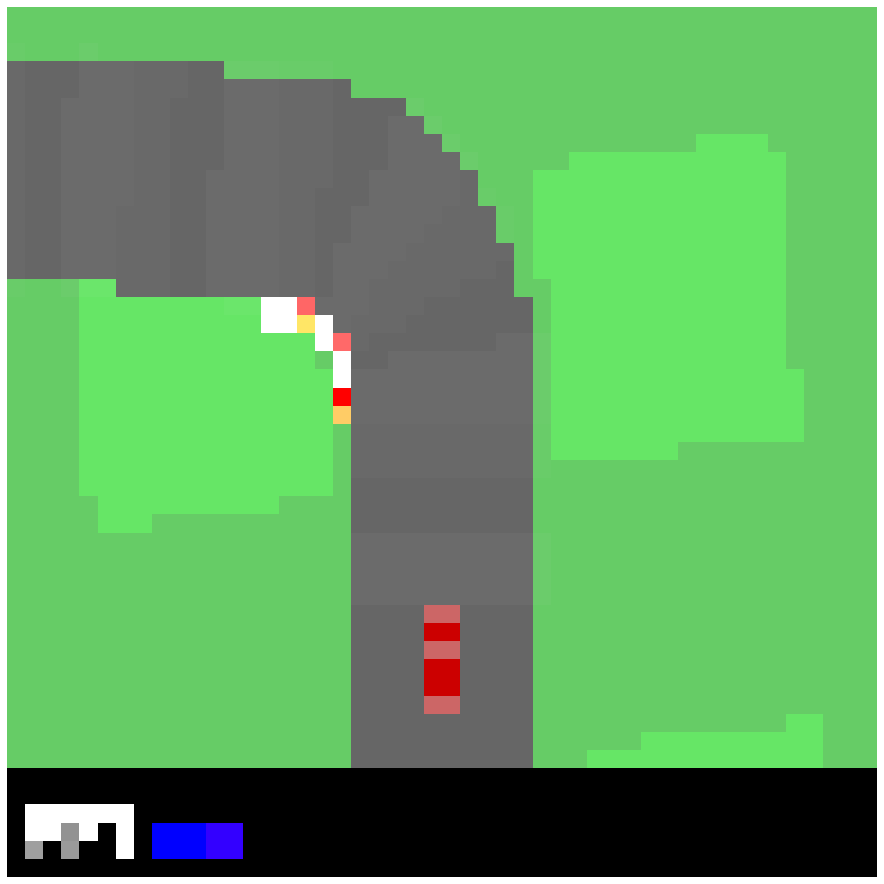

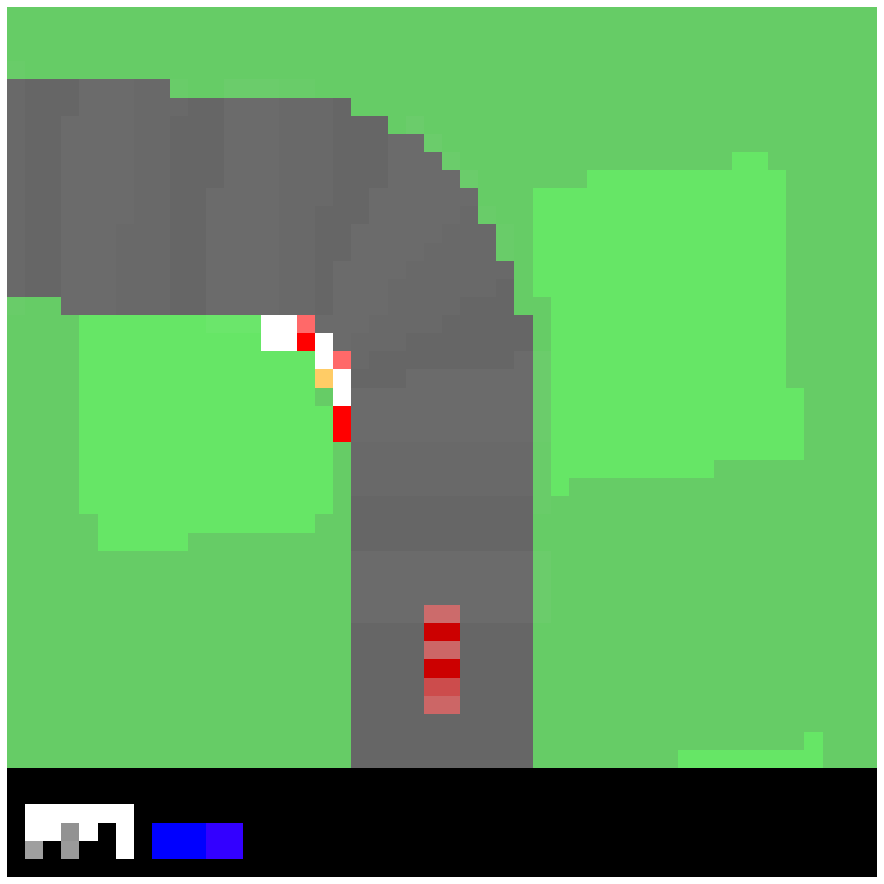

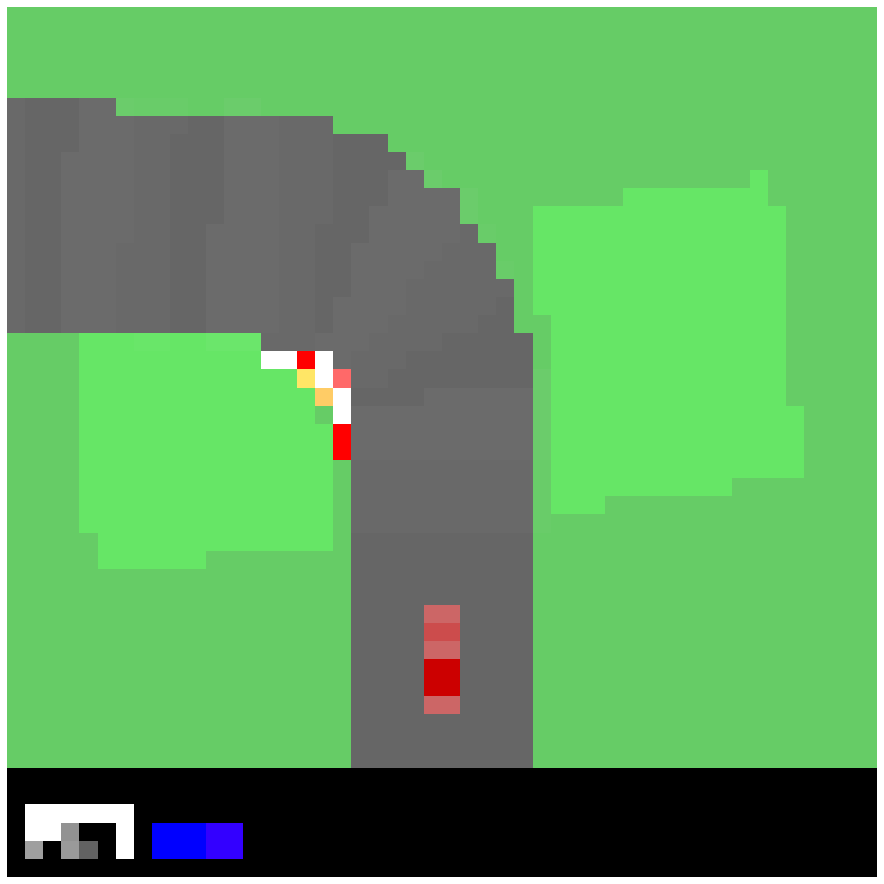

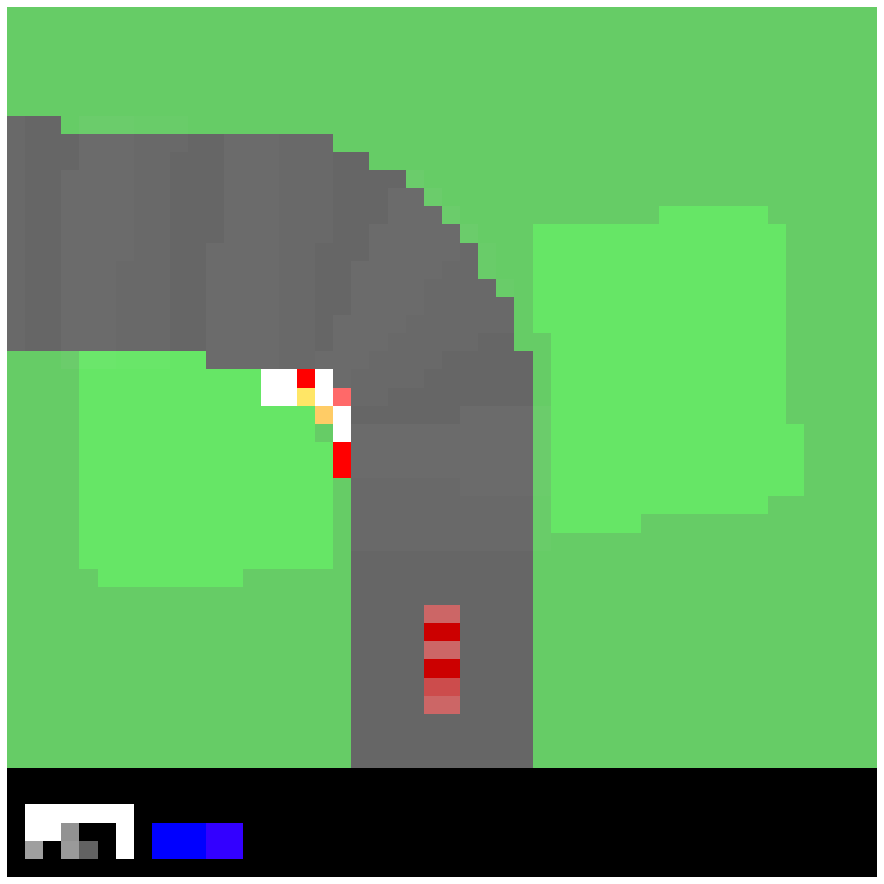

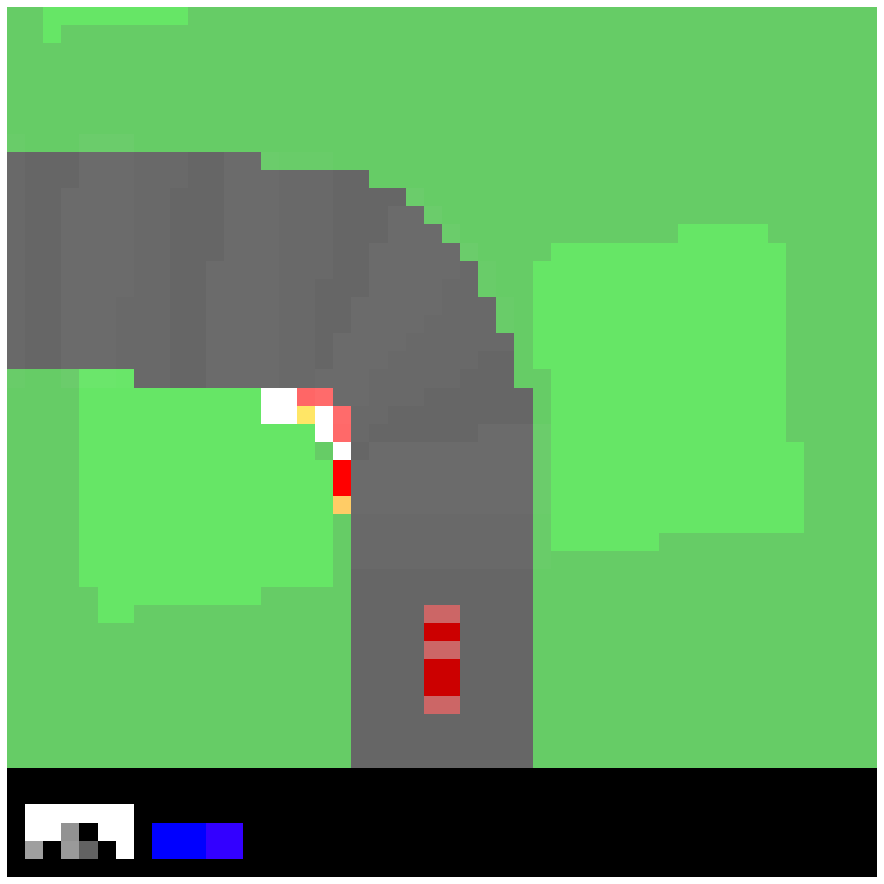

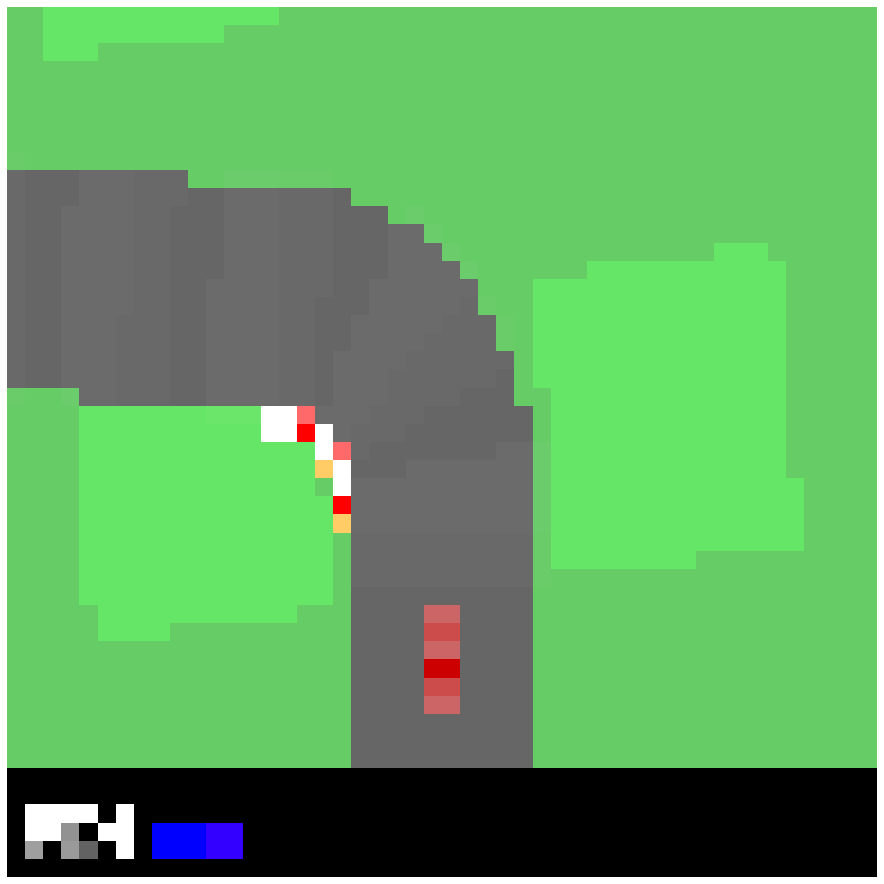

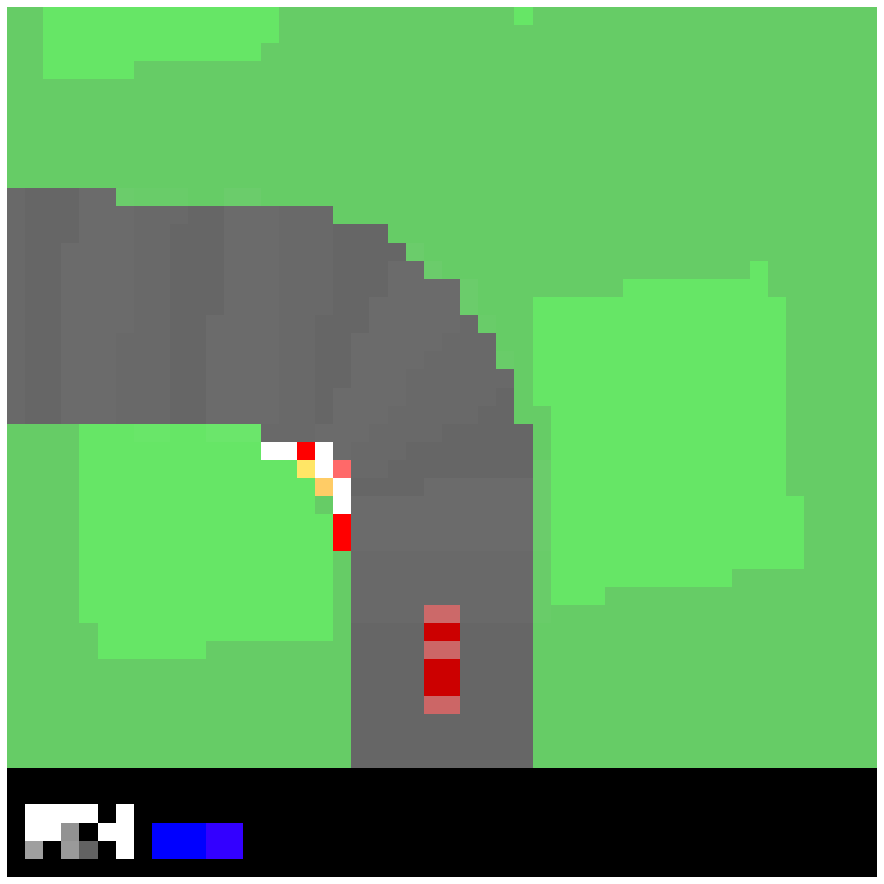

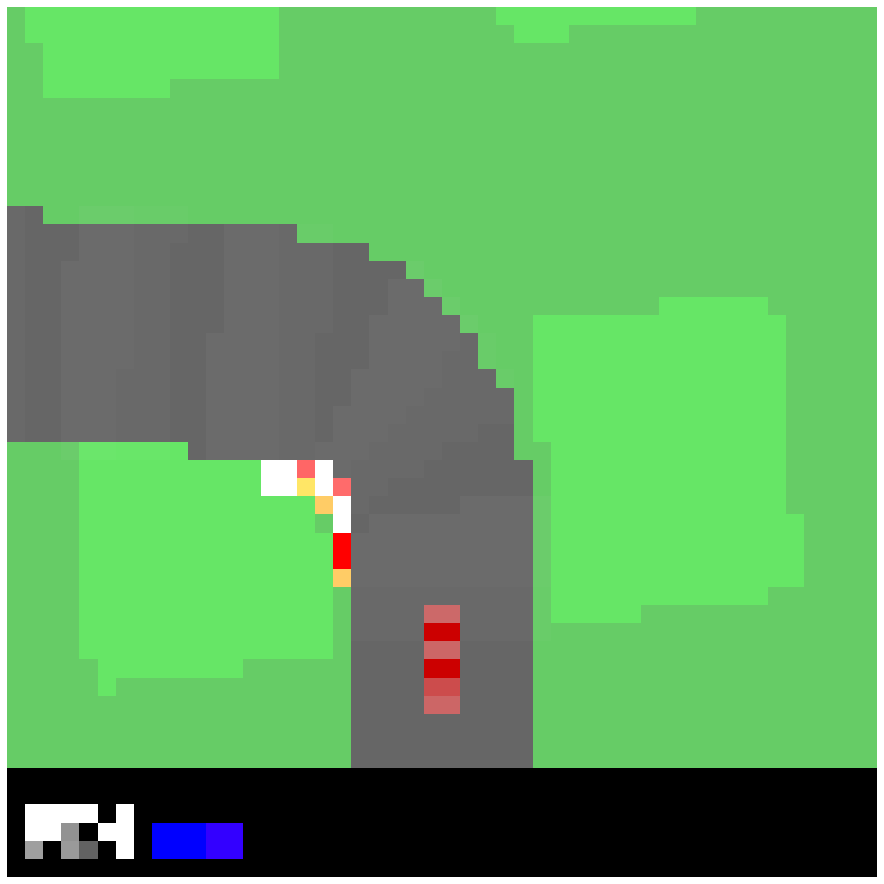

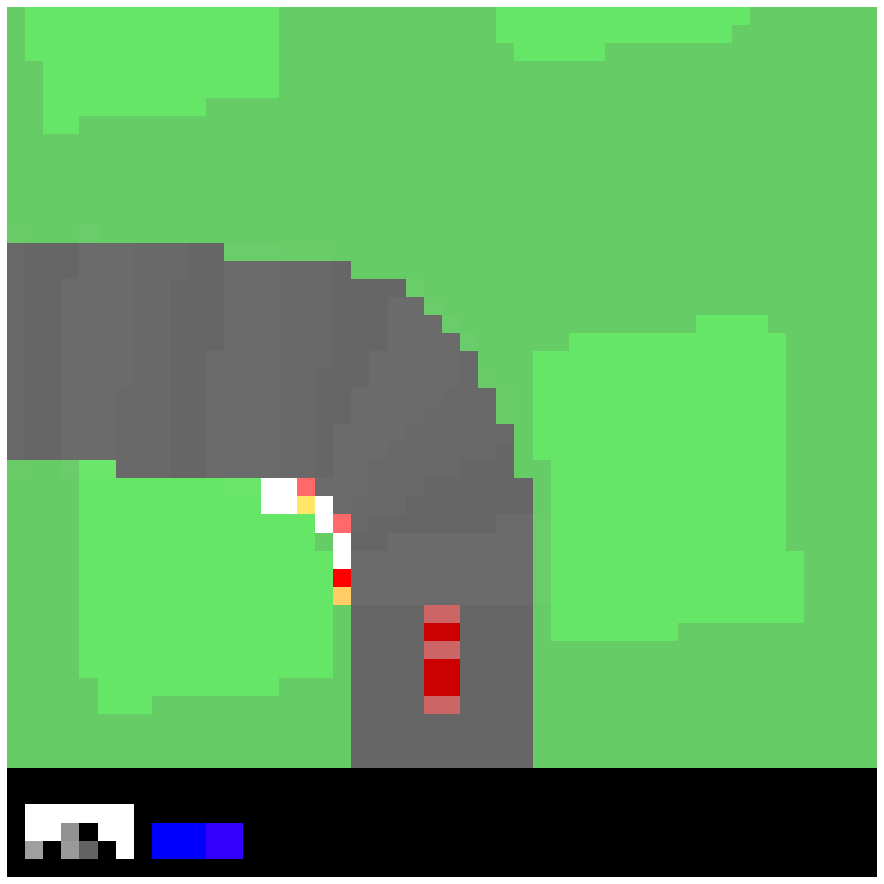

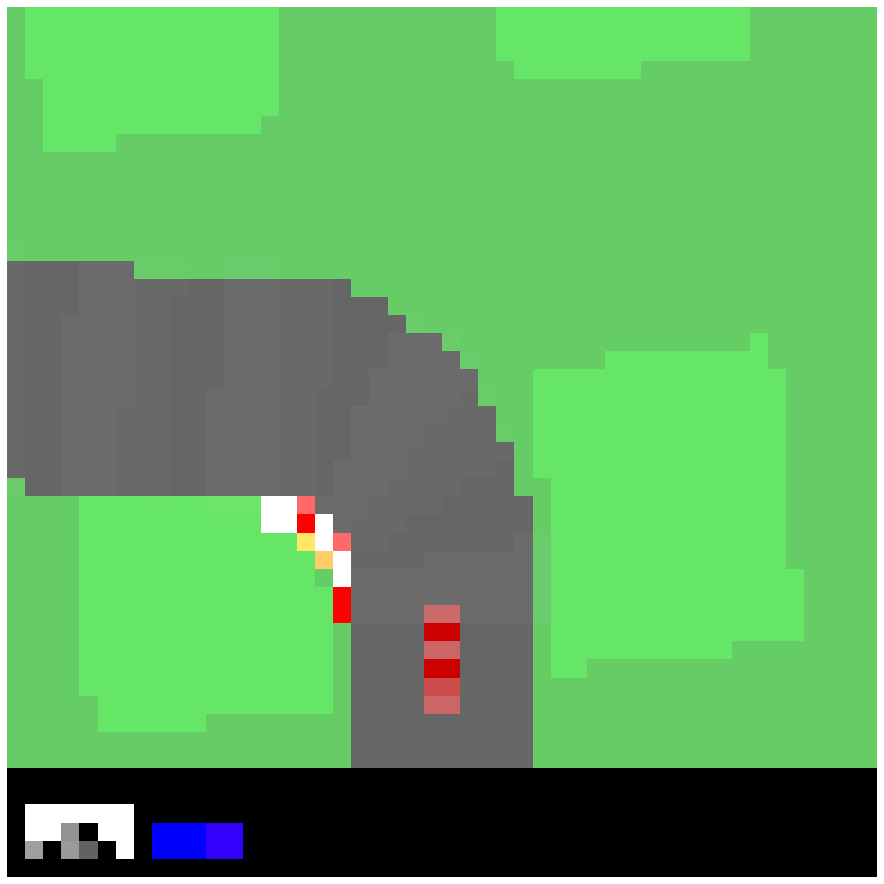

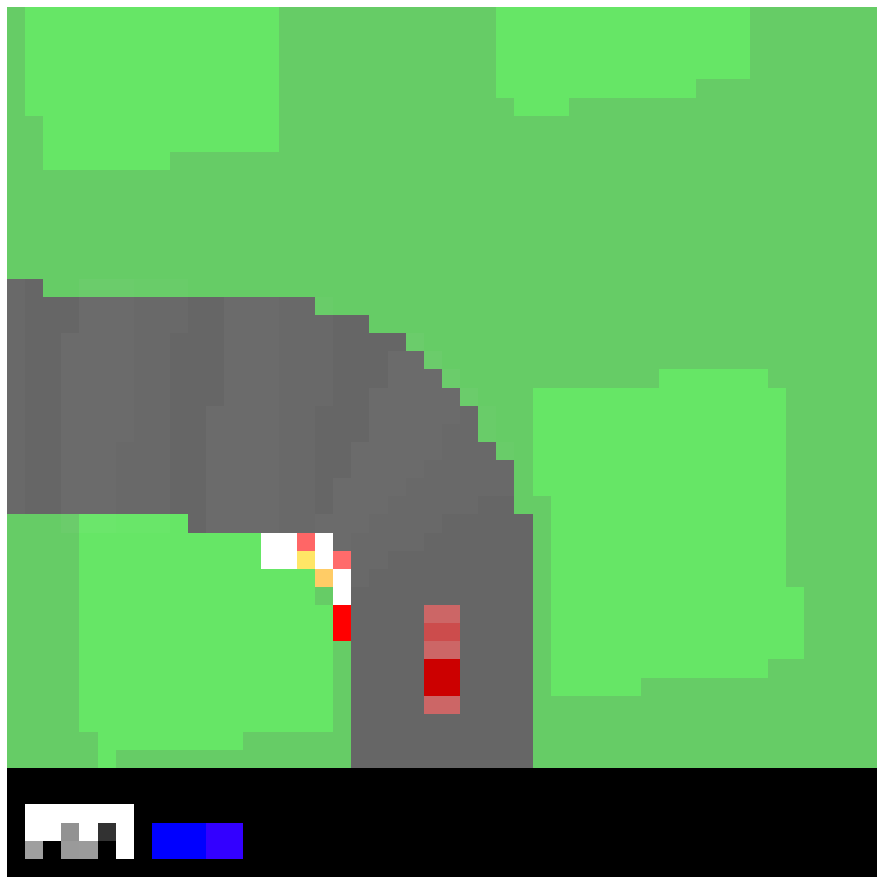

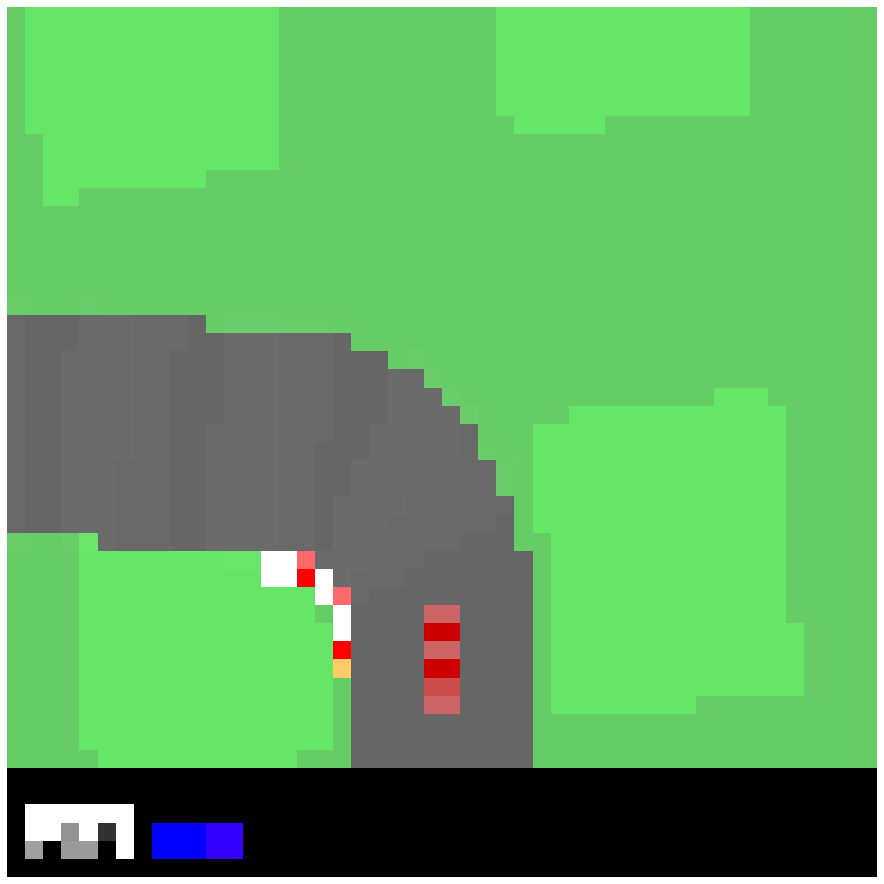

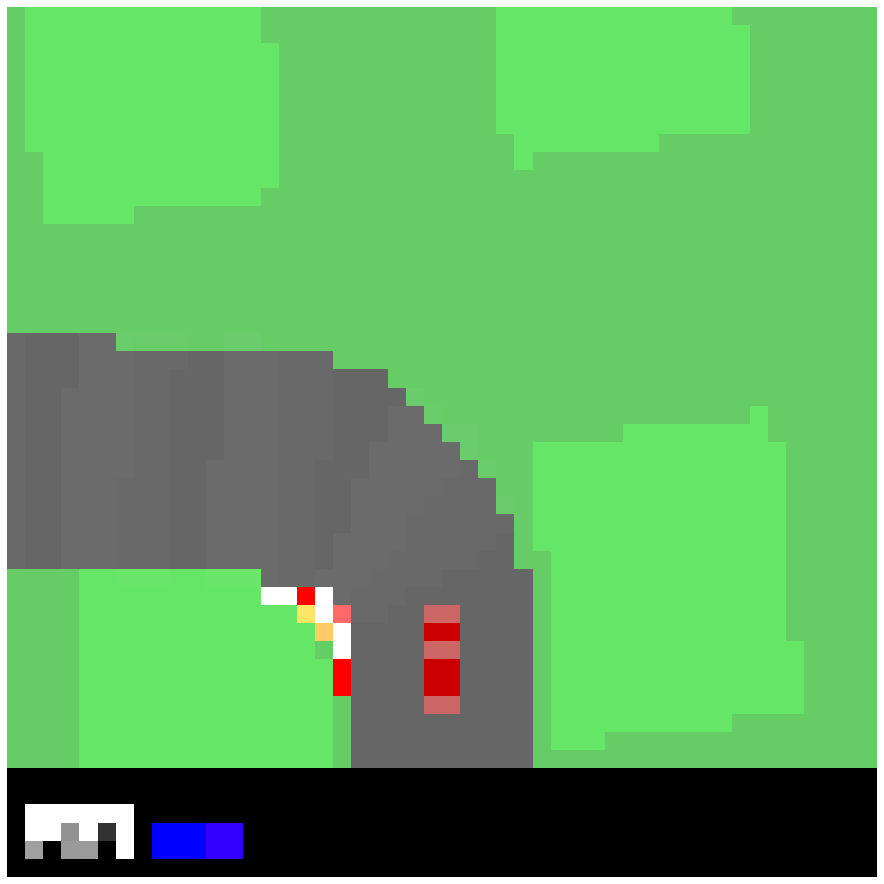

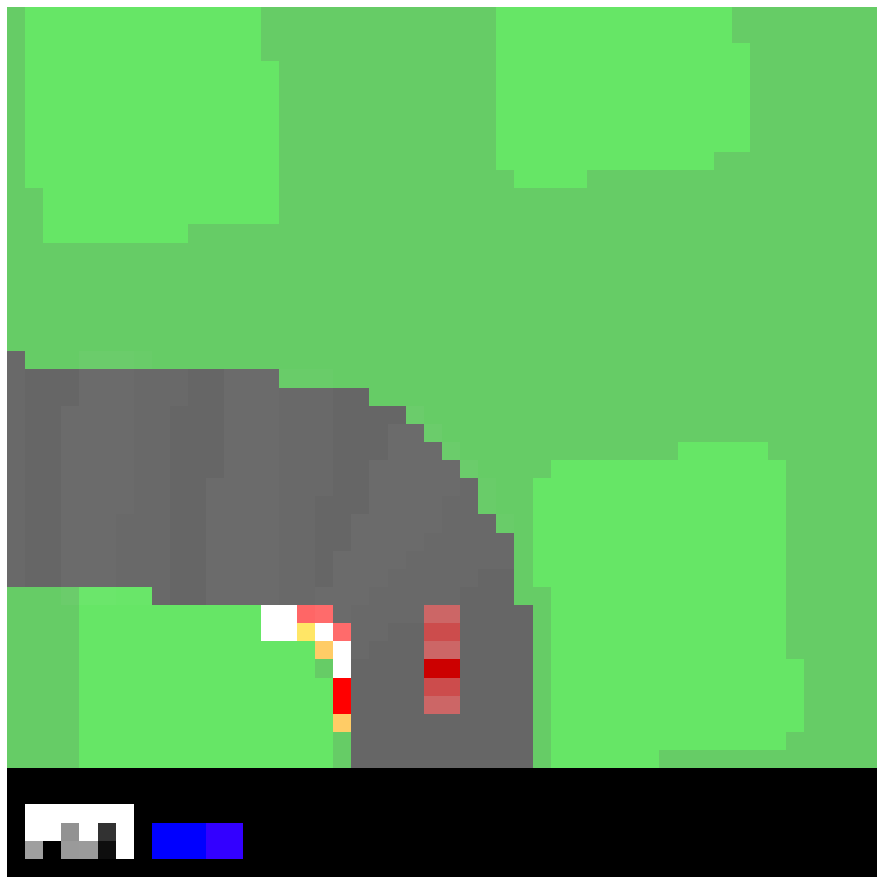

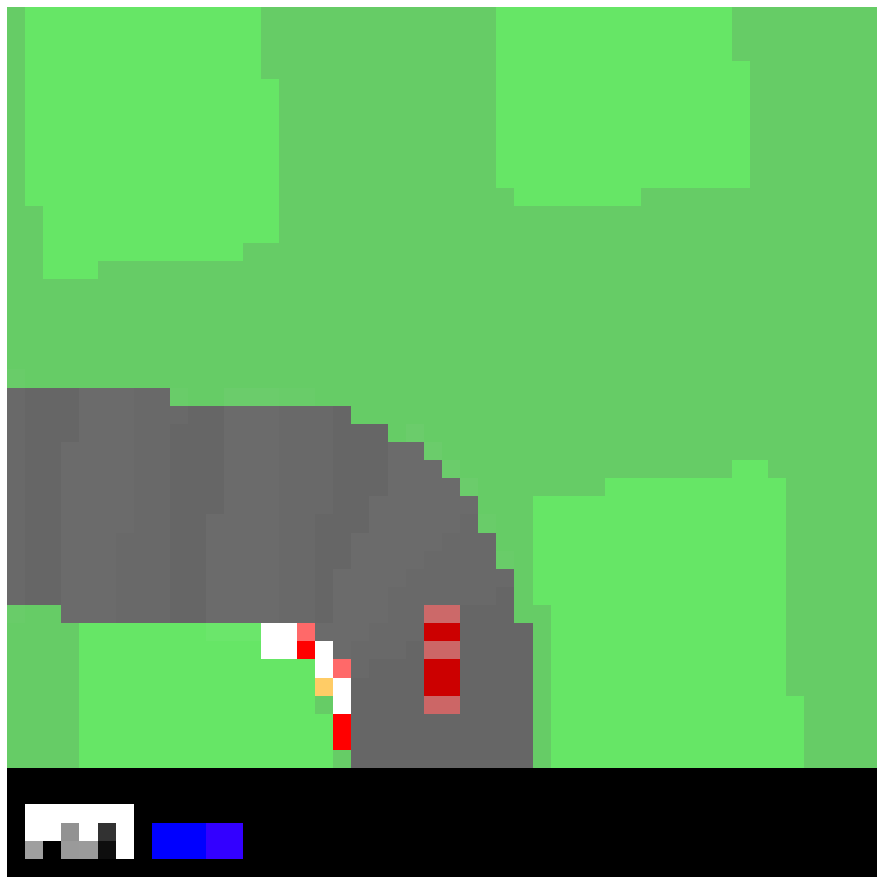

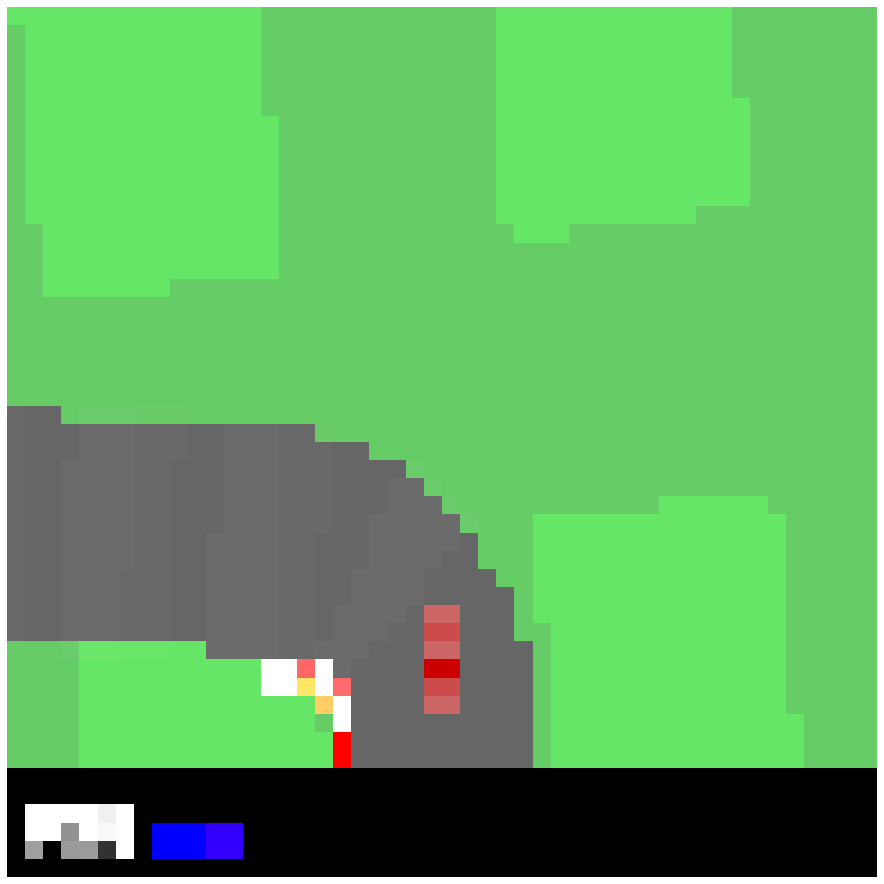

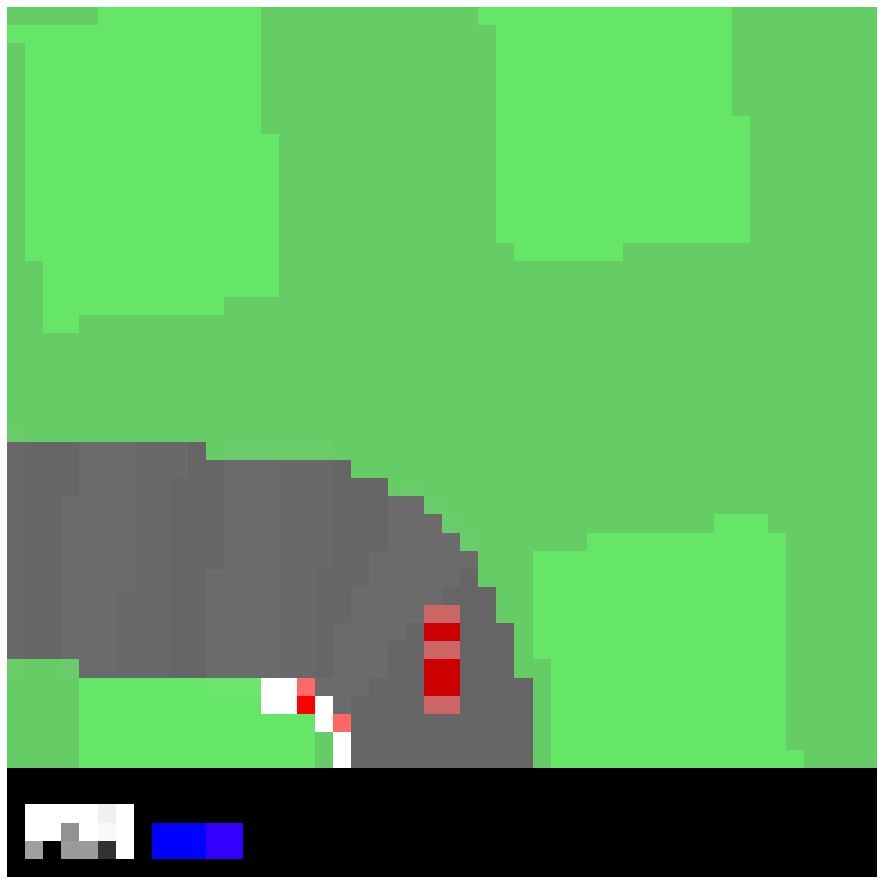

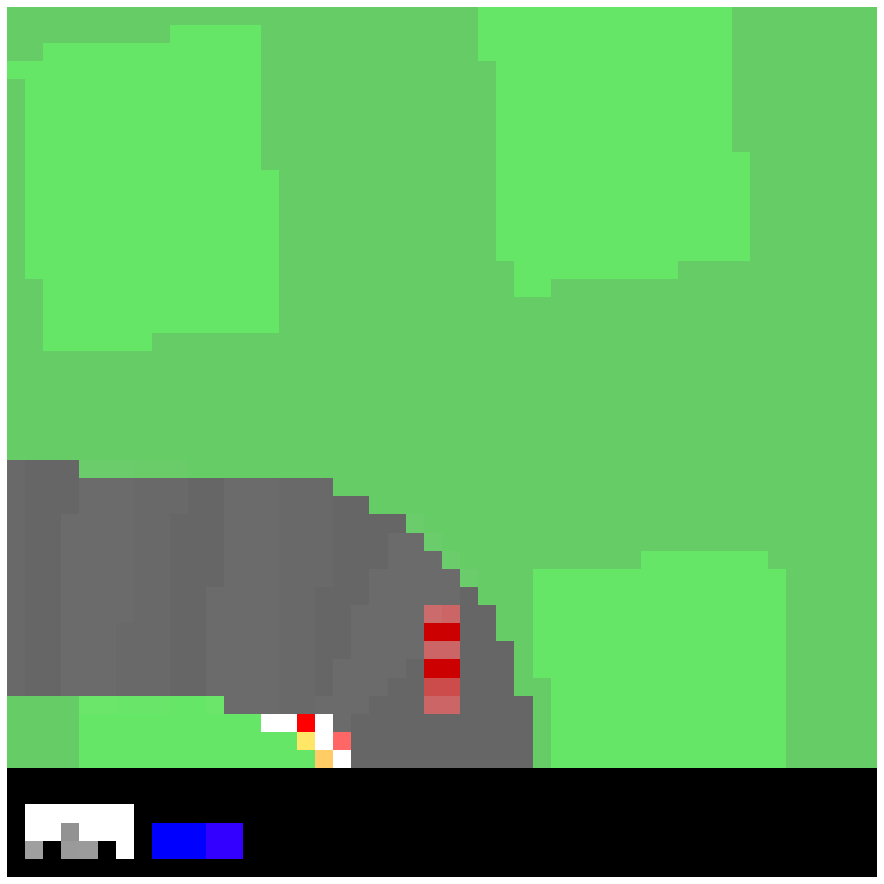

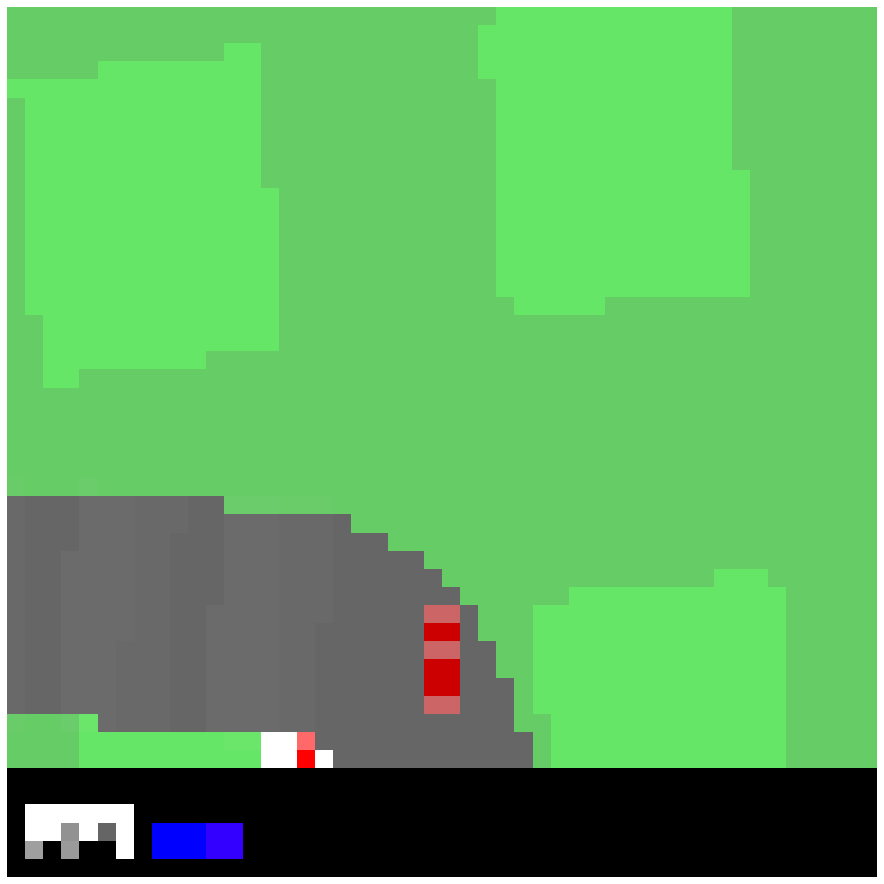

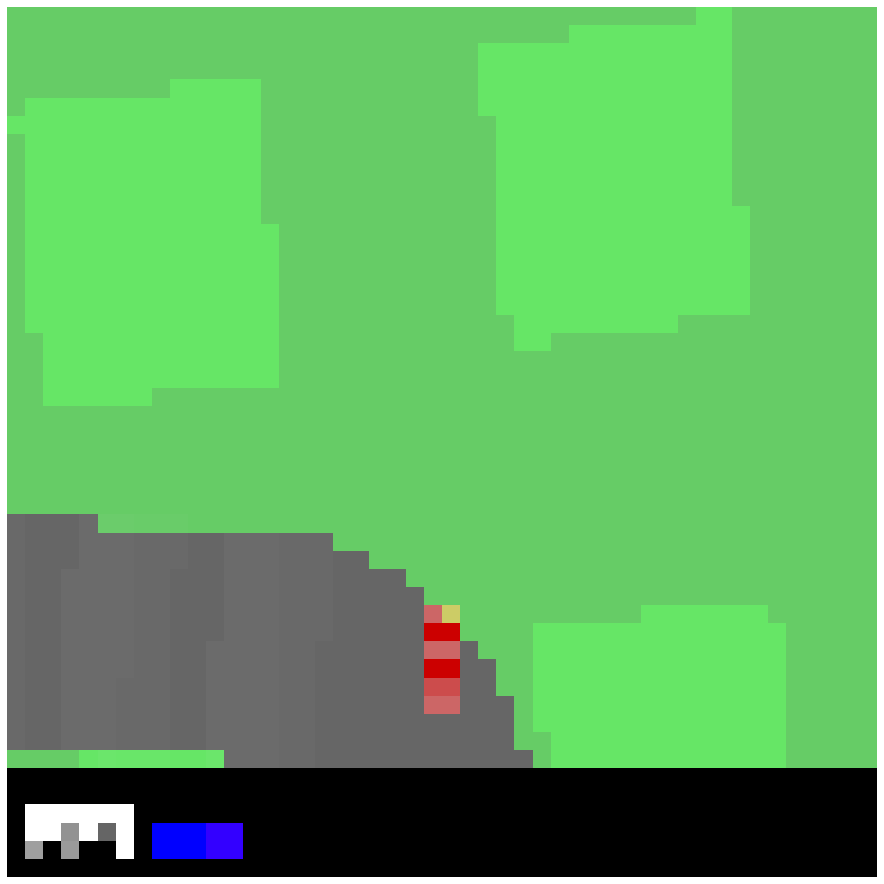

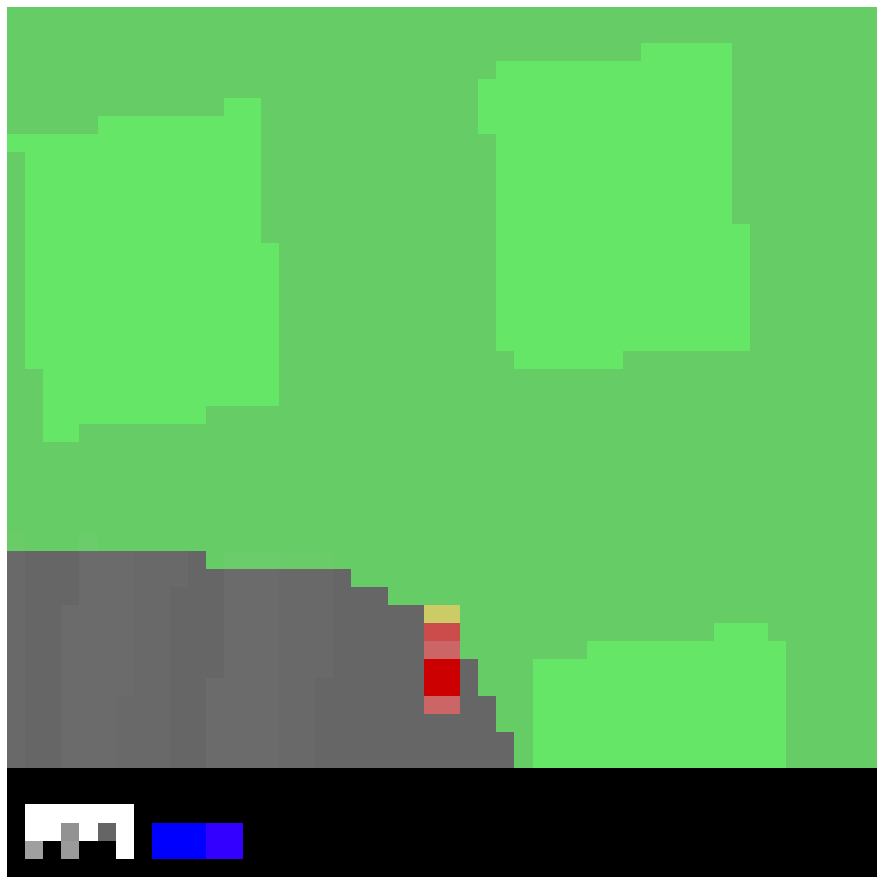

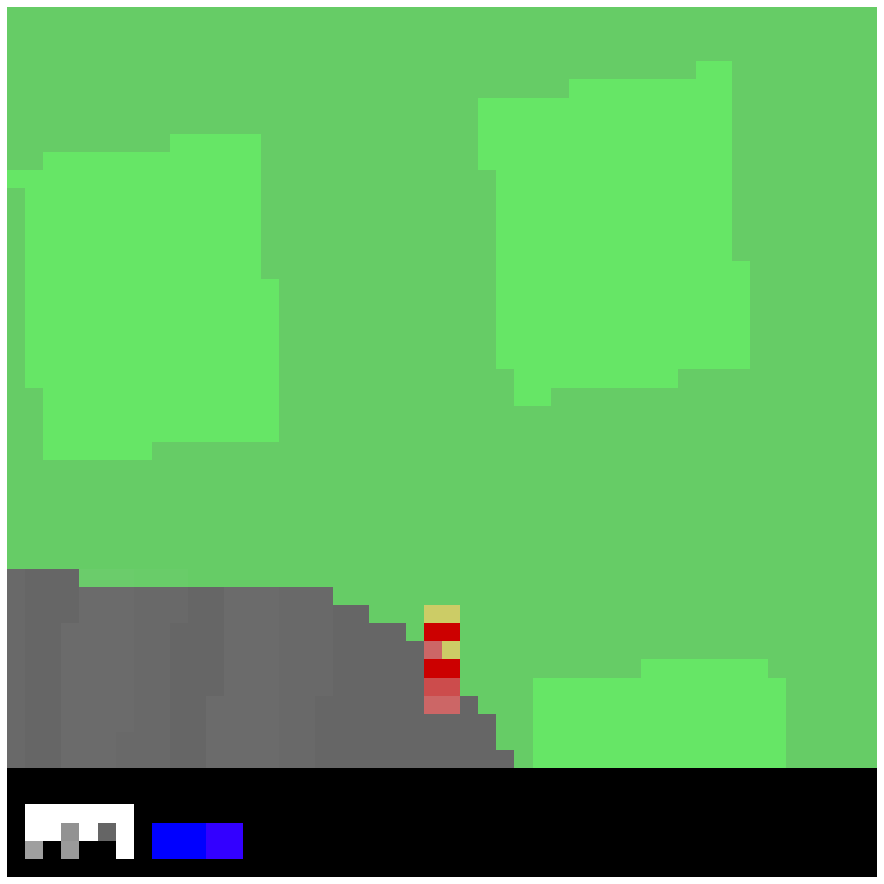

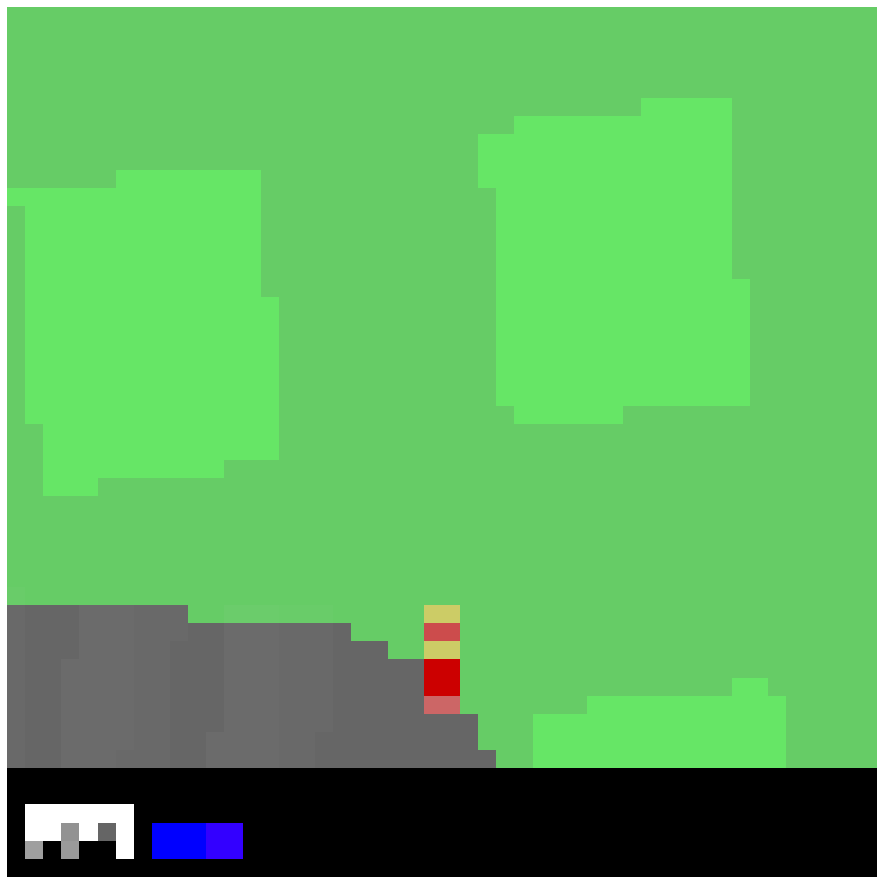

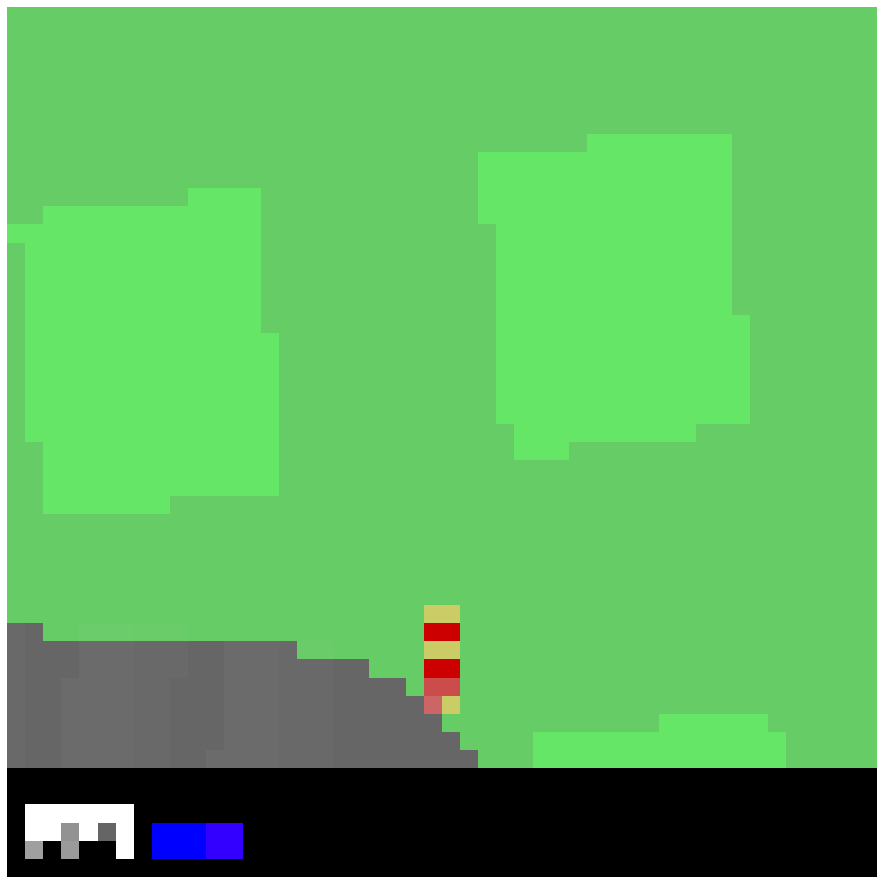

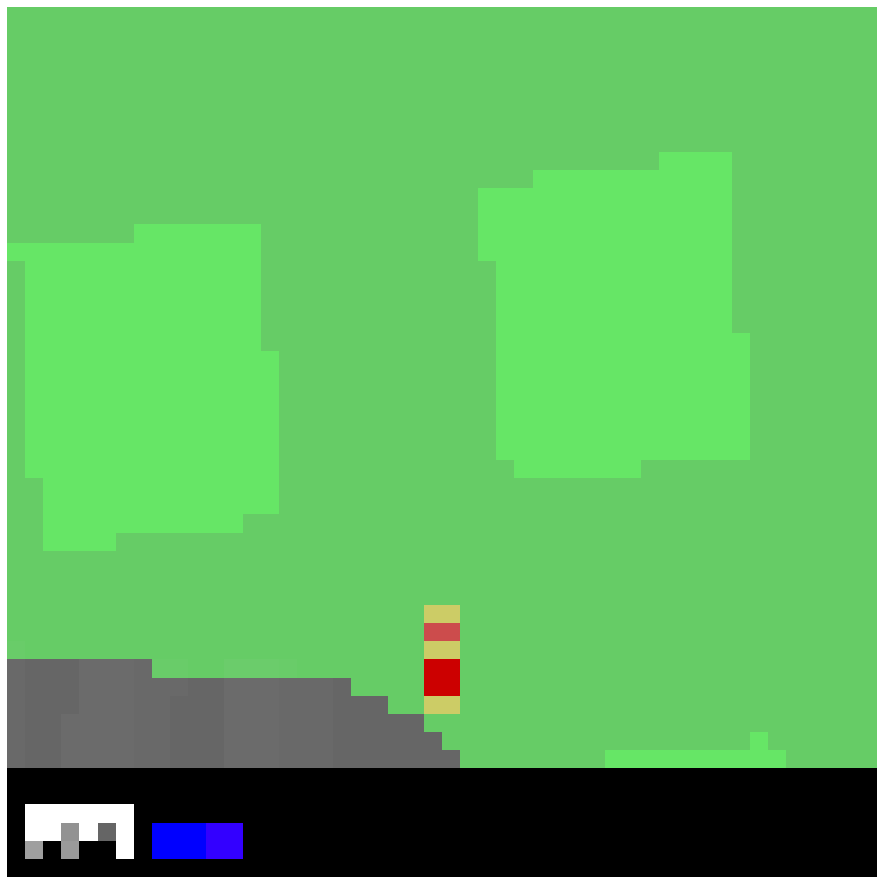

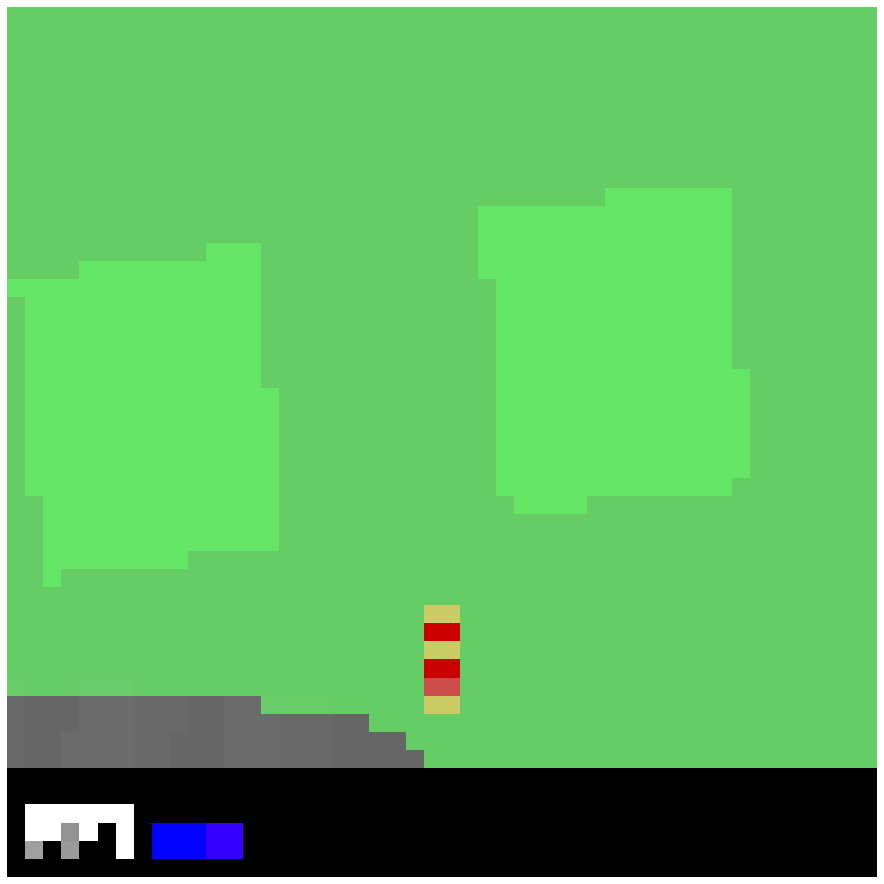

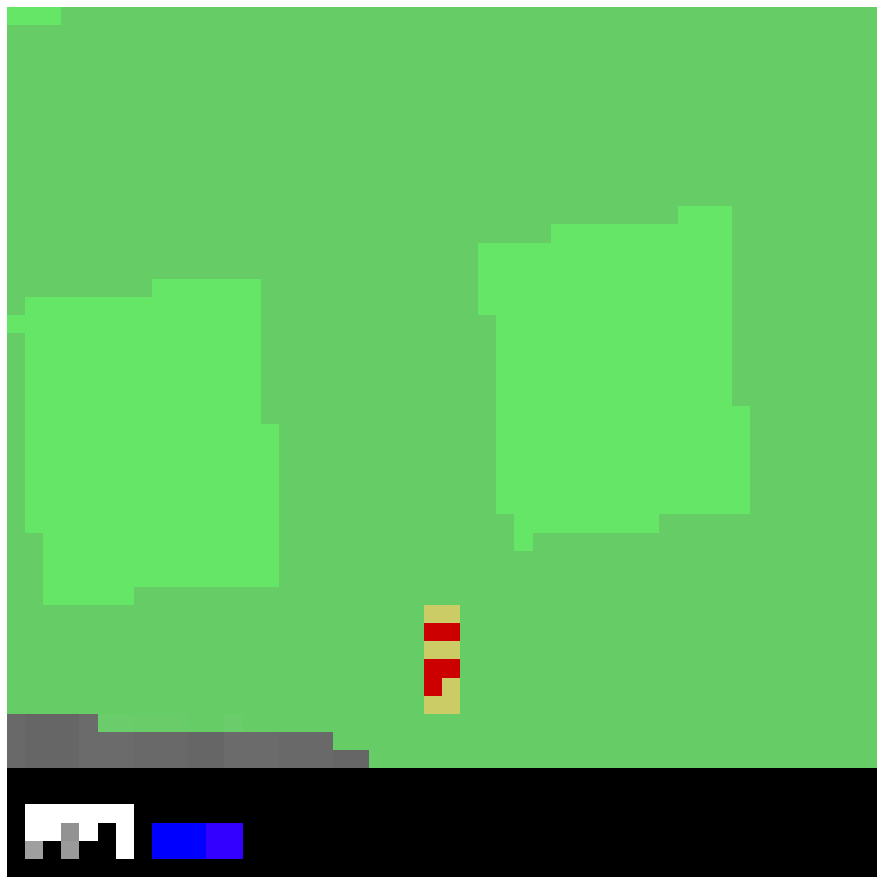

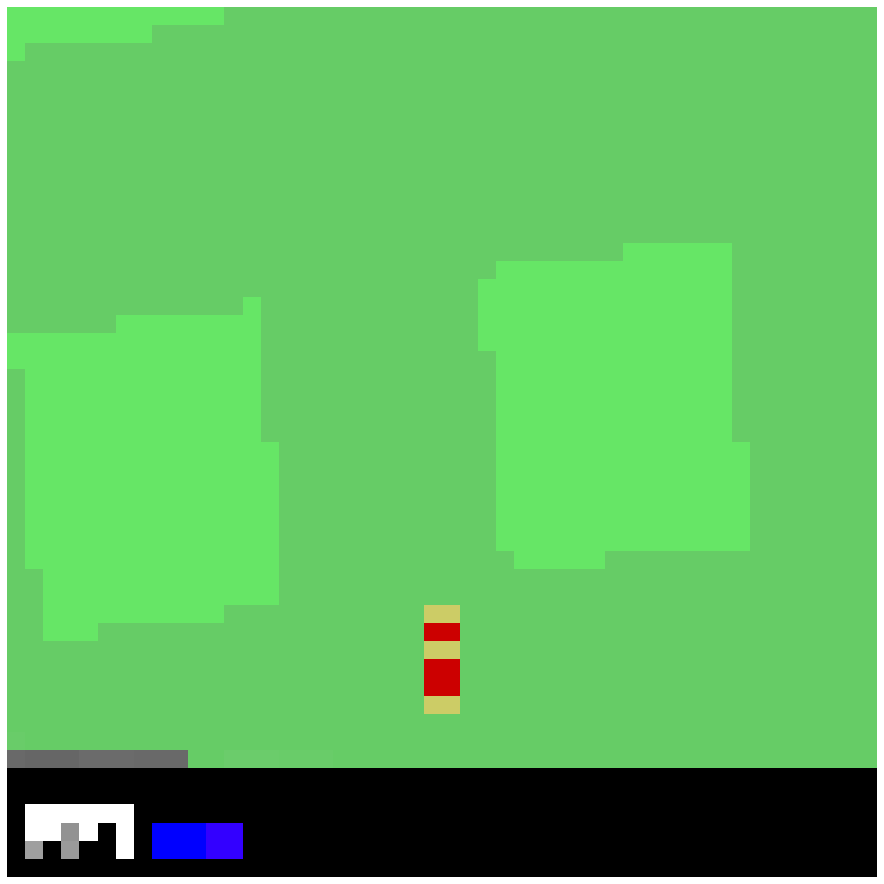

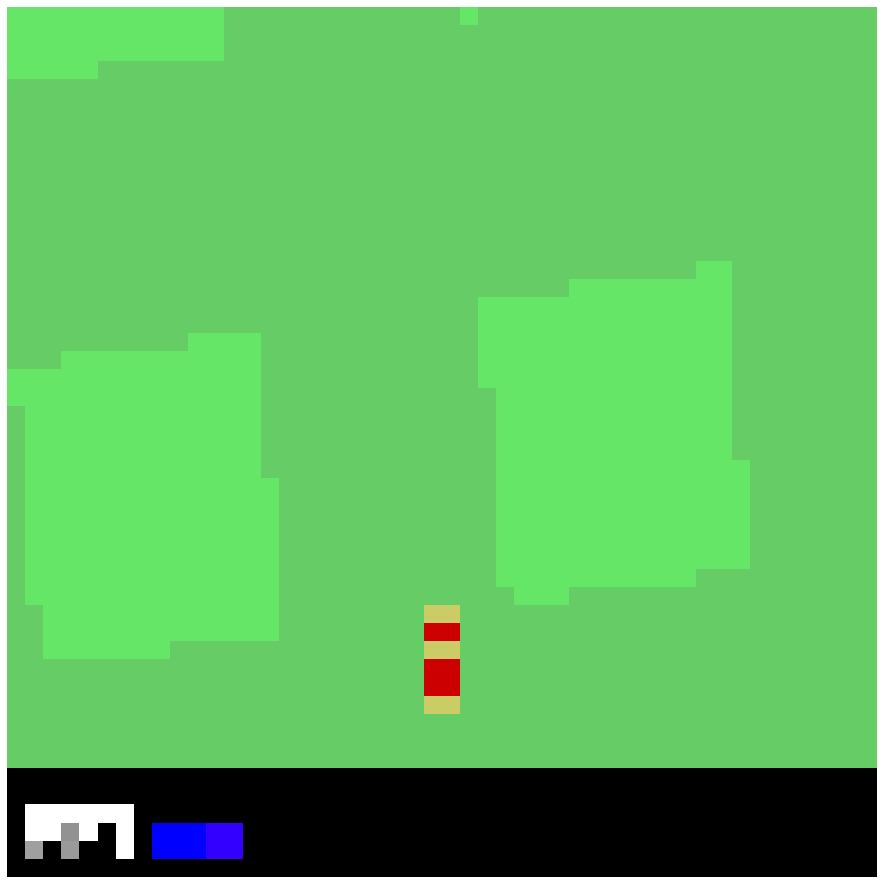

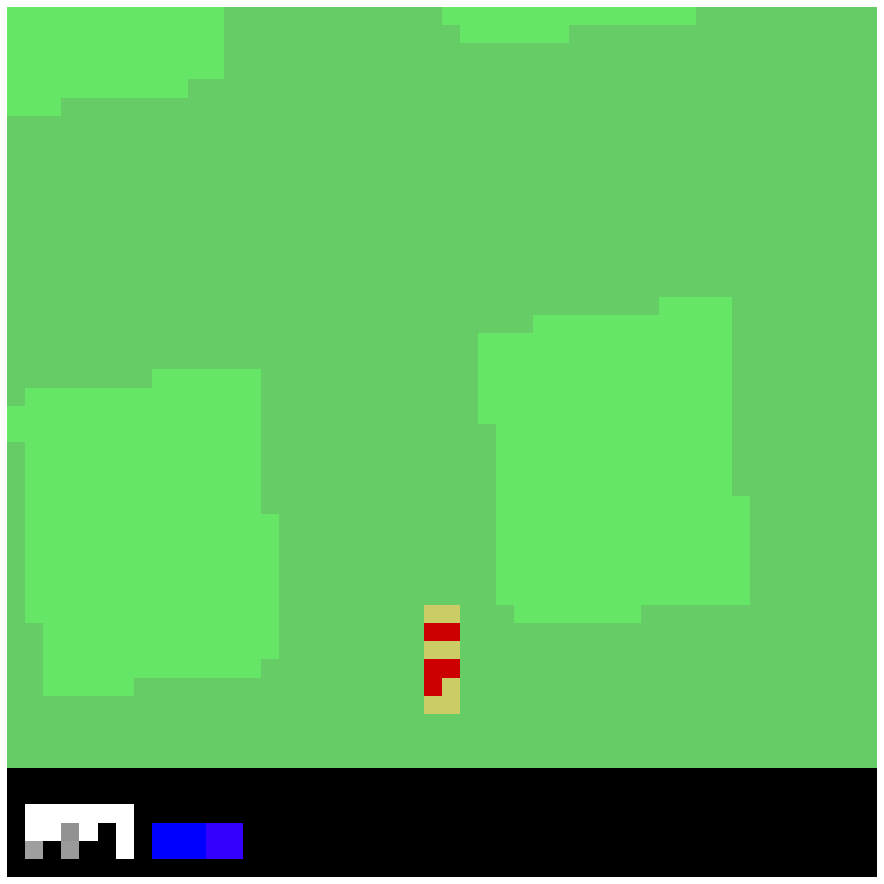

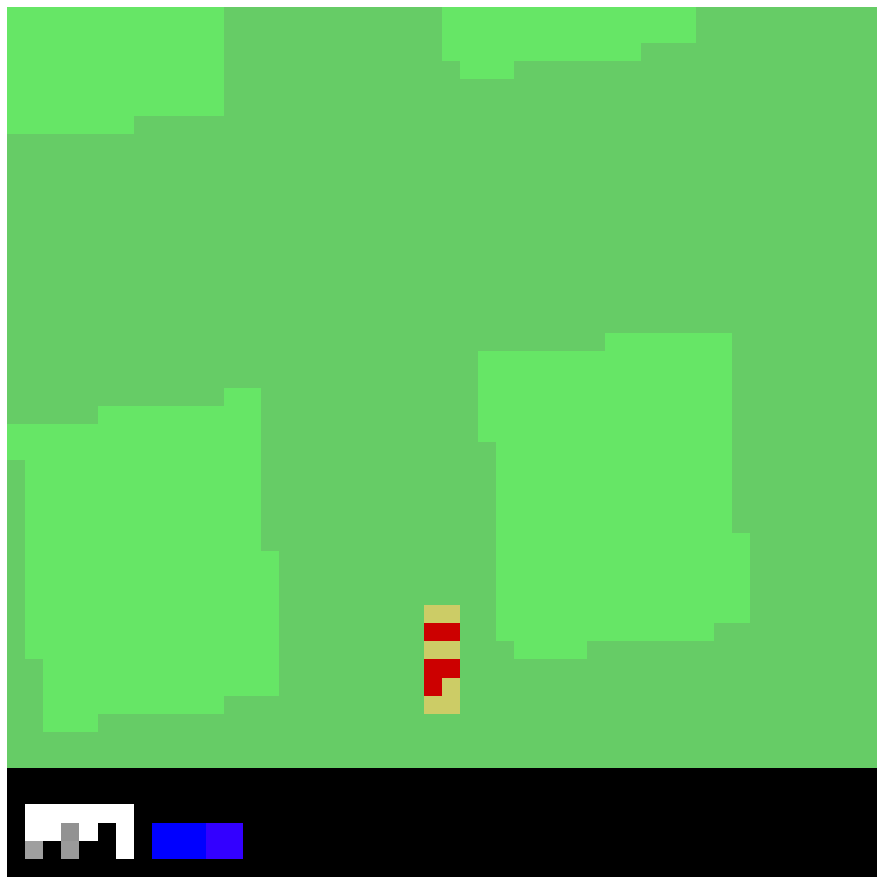

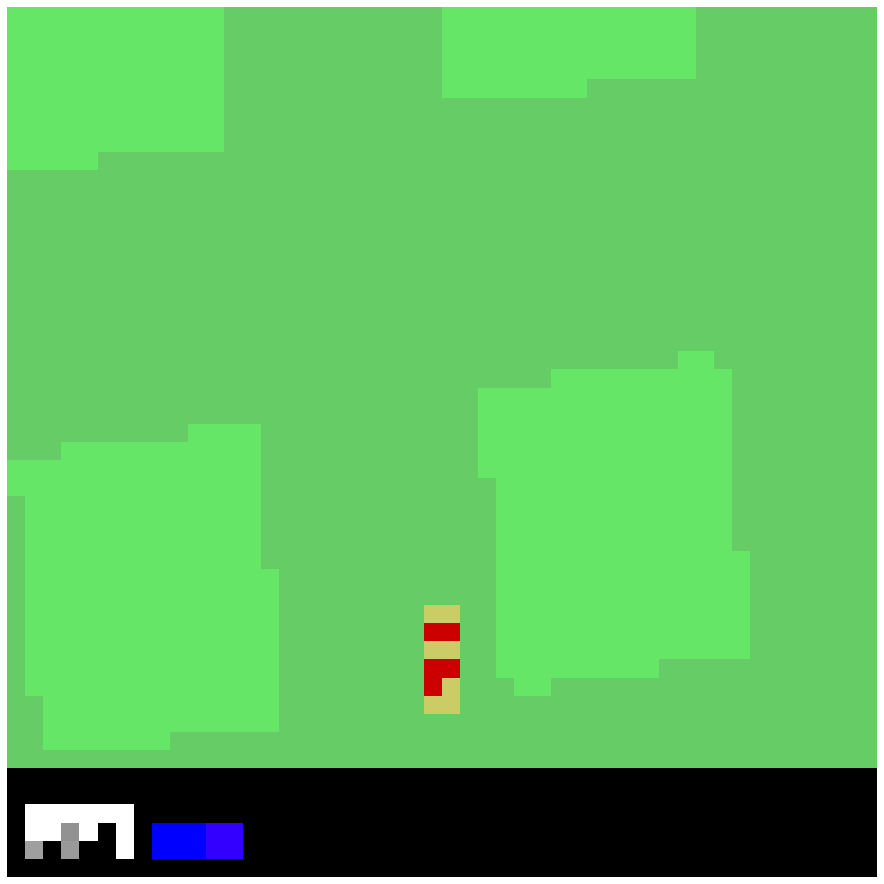

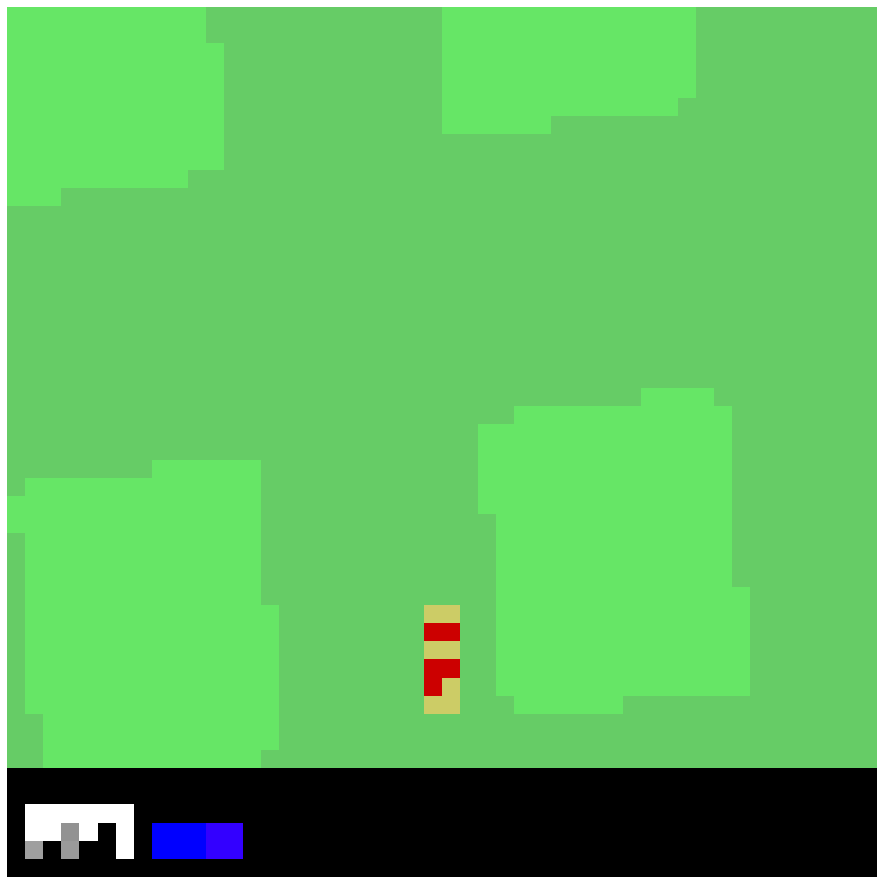

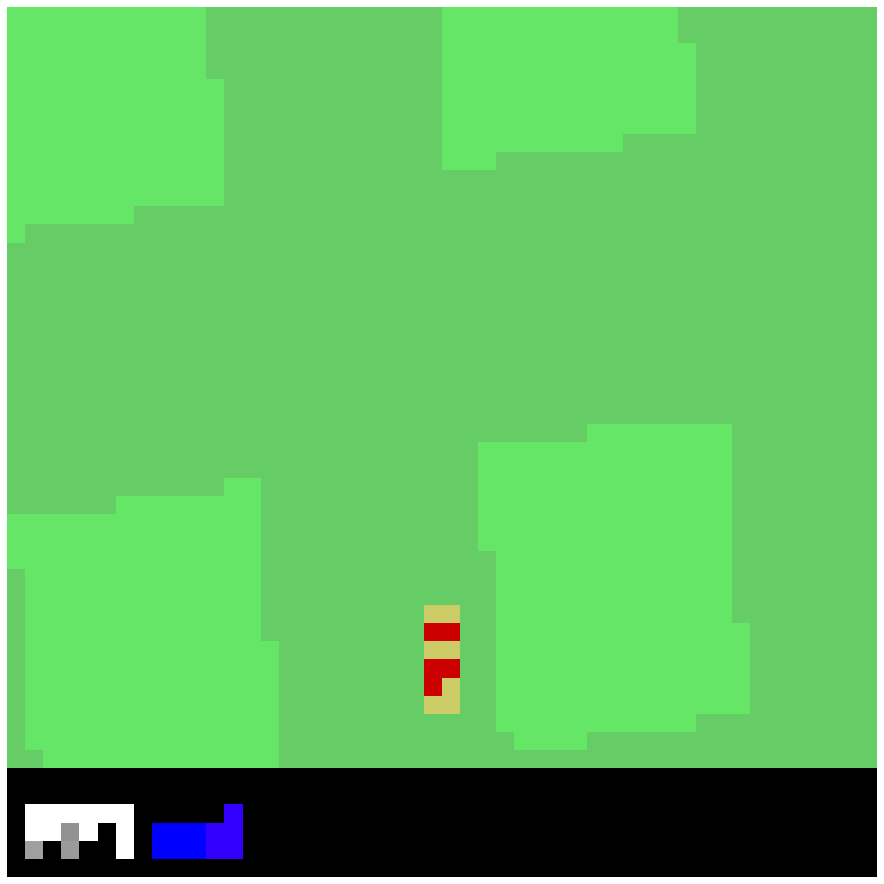

In [32]:
input_size = 96
output_size = 48
bin_size = input_size // output_size

env = gym.make("CarRacing-v0")
s = env.reset()

for i in range(100):

    s, reward, done, _ = env.step([0.0, 1.0, 0.0])
    s_cropped = s.reshape((output_size, bin_size, output_size, bin_size, 3)).max(3).max(1)

    plt.figure(figsize=(16, 16))
    plt.imshow(s_cropped)
    plt.axis('off')
    plt.show()

env.close()



